In [34]:
import numpy as np
import os
import json
import re
import itertools
import collections
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from pathlib import Path

import smfret.fit as fit

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import TwoStateQuickDynamicTraceSet
from smfret.dataset import MatlabTraceSet
from smfret.dataset import FRETTraceSet
from smfret.multi_task_learning import SavedTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import sklearn

import functools
import umap
import scipy

from sciplotlib import style as spstyle

In [2]:
rng = np.random.default_rng()

In [3]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')
encoder = keras.models.load_model('saved_models/best_model/encoder-20240111-045226.h5', compile=False)

In [4]:
def interpolate_position_embedding(position_embedding, periodicity=40):
    """Interpolates the position embedding vectors."""
    vectors = []
    w = position_embedding.variables[0]
    for i in range(w.shape[0]):
        if i == 0:
            vectors.append(w[i, :])
        elif i < periodicity:
            vectors.append(w[i, :])
        else:
            vectors.append(w[i - periodicity + 1, :])
    position_embedding.variables[0].assign(tf.stack(vectors, axis=0))

In [5]:
position_embedding = encoder.layers[-1].transformer.position_embedding
interpolate_position_embedding(position_embedding, periodicity=40)

In [6]:
NN_K = 50  # how many nearest neighbors are considered for the score

In [7]:
def calculate_distance(embedding):
    """Calculates the distance matrix from the embeddings."""
    distance = (
        tf.expand_dims(tf.einsum('ik,ik->i', embedding, embedding), axis=-1)
        + tf.expand_dims(tf.einsum('ik,ik->i', embedding, embedding), axis=0)
        - 2.0 * tf.einsum('ik,jk->ij', embedding, embedding))
    return distance

In [8]:
def get_perplexity(embedding, label, branching_factor, use_excess_definition=True, normalize=True):
    """Calculates the perplexity of a trace's neighbors.""" 
    distance = calculate_distance(embedding)
    top_k_results = tf.math.top_k(
        -distance, k=branching_factor + 1, sorted=True, name=None
    )
    top_k_idx = top_k_results.indices.numpy()
    n = embedding.shape[0]
    perplexity = []
    for i in range(n):
        this_label = label[i]
        neighbour_label = label[top_k_idx[i, :].flatten()]
        unique_labels = set(neighbour_label)
        shannon_entropy = 0
        for l in unique_labels:
            p = np.mean(neighbour_label == l)
            shannon_entropy -= p * np.log(p)
        perplexity.append(shannon_entropy)
    return np.array(perplexity)

In [9]:
# naming the simulation conditions

# SNR
class SNR:
    c = (6, 10)  # clean
    n = (1, 4)  # noisy

# FRET value

class FRET_VALUE:
    l = (0.1, 0.3)  # low
    m = (0.4, 0.6)  # mid
    h = (0.7, 0.9)  # high

# kinetic rate
class KINETIC_RATE:
    s = (0.01, 0.05)  # slow
    f = (0.1, 0.5)  # fast


def condition_to_param(n_state, snr, fret_value, kinetic_rate):
    snr_params = []
    fret_value_params = []
    kinetic_rate_params = []
    for s in snr:
        snr_params.append(getattr(SNR, s))
    for s in fret_value:
        fret_value_params.append(getattr(FRET_VALUE, s))
    for s in kinetic_rate:
        kinetic_rate_params.append(getattr(KINETIC_RATE, s))
    
    return int(n_state), snr_params, fret_value_params, kinetic_rate_params


def condition_to_name(n_state, snr, fret_value, kinetic_rate):
    return f"{n_state}-{snr}-{fret_value}-{kinetic_rate}"

def name_to_condition(name):
    n_state, snr, fret_value, kinetic_rate = name.split('-')
    return n_state, snr, fret_value, kinetic_rate

In [10]:
rng = np.random.default_rng()

def make_transition_prob_fn(ks):
    counter = -1
    def transition_prob_fn():
        nonlocal counter
        counter += 1
        n = len(ks)
        return rng.uniform(low=ks[counter % n][0], high=ks[counter % n][1])
    return transition_prob_fn

def make_fret_value_fn(Es):
    counter = -1
    def fret_value_fn():
        nonlocal counter
        counter += 1
        n = len(Es)
        return rng.uniform(low=Es[counter % n][0], high=Es[counter % n][1])
    return fret_value_fn

In [11]:
# 1 state
names = []
combinations = list(itertools.product([1], ['c', 'n'], ['l', 'm', 'h'], ['s']))
for n_state, snr, fret_value, kinetic_rate in combinations:
    names.append(condition_to_name(n_state, snr, fret_value, kinetic_rate))

# 2 state
combinations = list(itertools.product([2], ['c', 'n'], ['lm', 'lh', 'mh'], ['s', 'f']))
for n_state, snr, fret_value, kinetic_rate in combinations:
    names.append(condition_to_name(n_state, snr, fret_value, kinetic_rate))

# 3 state
combinations = list(itertools.product([3], ['c', 'n'], ['lmh'], ['s', 'f']))
for n_state, snr, fret_value, kinetic_rate in combinations:
    names.append(condition_to_name(n_state, snr, fret_value, kinetic_rate))

print('Total number of considered conditions =', len(names))

Total number of considered conditions = 22


In [12]:
def generate_embedding_and_label(trace_sets, start_frame, encoder, max_frame=2000, max_traces=4000, balance_labels=True):
    """Generates the embeddings and labels."""

    embeddings = []
    labels = []
    colors = []
    color_count = 1
    image_files = []
    traces = []
    
    count = 0
    for trace_set in trace_sets:
        trim_size = len(trace_set.time) // 100 * 100
        trace_set.trim(trim_size)
        trace_set.trim(max_frame, start_frame=start_frame)
        trace_set.broadcast_data_to_traces()
        print(trace_set.size)
        if count + trace_set.size > max_traces:
            break
        else:
            count += trace_set.size
                
        with tf.device('/CPU:0'):
            label = np.max(trace_set.label, axis=-1)
            if balance_labels:
                n_included = np.sum(label == 1)
                n_excluded = np.sum(label == 0)
                if n_included == 0 or n_excluded == 0:
                    continue
                indices = np.arange(len(label))
                ratio = int(n_excluded / n_included)
                # ratio = 0
                if ratio > 1:
                    indices = np.concatenate([indices[label == 1], indices[label ==0][::ratio]])
                    label = label[indices]
                    trace_set = trace_set.get_subset(indices)

            embedding = encoder.predict(trace_set.to_tensor(), batch_size=8)
            embeddings.append(embedding)
            labels.append(label)
            traces.extend(trace_set.traces)
    return embeddings, labels

In [84]:
embeddings = []
labels = []
for name in names:
    file = f'saved_dataset/atlas/{name}.npz'
    trace_set = SavedTraceSet(file=file, size=5000)
    e, label = generate_embedding_and_label([trace_set], 0, encoder, max_frame=2000, max_traces=20000, balance_labels=False)
    embeddings.extend(e)
    labels.append(np.array([name] * len(label[0])))
    del trace_set
    del label

5000
625/625 [==============================] - 34s 54ms/step
5000
625/625 [==============================] - 34s 54ms/step
5000
625/625 [==============================] - 34s 54ms/step
5000
625/625 [==============================] - 34s 55ms/step
5000
625/625 [==============================] - 53s 86ms/step
5000
625/625 [==============================] - 32s 51ms/step
5000
625/625 [==============================] - 32s 51ms/step
5000
625/625 [==============================] - 32s 51ms/step
5000
625/625 [==============================] - 39s 63ms/step
5000
625/625 [==============================] - 34s 54ms/step
5000
625/625 [==============================] - 33s 54ms/step
5000
625/625 [==============================] - 35s 56ms/step
5000
625/625 [==============================] - 268s 430ms/step
5000
625/625 [==============================] - 38s 61ms/step
5000
625/625 [==============================] - 37s 59ms/step
5000
625/625 [==============================] - 37s 59ms/step
5000
6

In [85]:
# for name in ['multistep']:
#     file = f'saved_dataset/atlas/{name}.npz'
#     trace_set = SavedTraceSet(file=file, size=2000)
#     e, label = generate_embedding_and_label([trace_set], 0, encoder, max_frame=2000, max_traces=20000, balance_labels=False)
#     e[0], label[0] = e[0][label[0] > 1, :], label[0][label[0] > 1]
#     embeddings.extend(e)
#     labels.append(np.array([name] * len(label[0])))

In [86]:
simulated_embedding = np.concatenate(embeddings, axis=0)
simulated_label = np.concatenate(labels, axis=0)
simulated_embedding = principal_projection(simulated_embedding, projection_matrices, PRINCIPAL_DIMENTIONS)

In [87]:
# perplexity_simulated = get_perplexity(simulated_embedding, simulated_label, branching_factor=10)
perplexity_simulated = np.zeros(simulated_embedding.shape[0])  # the distance matrix is too large to fit into the memory

In [88]:
def remove_outlier(x, m=2):
    center = np.mean(x, axis=0)
    std = np.sqrt(np.mean(np.square(x - center), axis=0))
    r = np.abs(x - center)
    is_outlier = np.any(r > std * m, axis=-1)
    return x[~is_outlier]

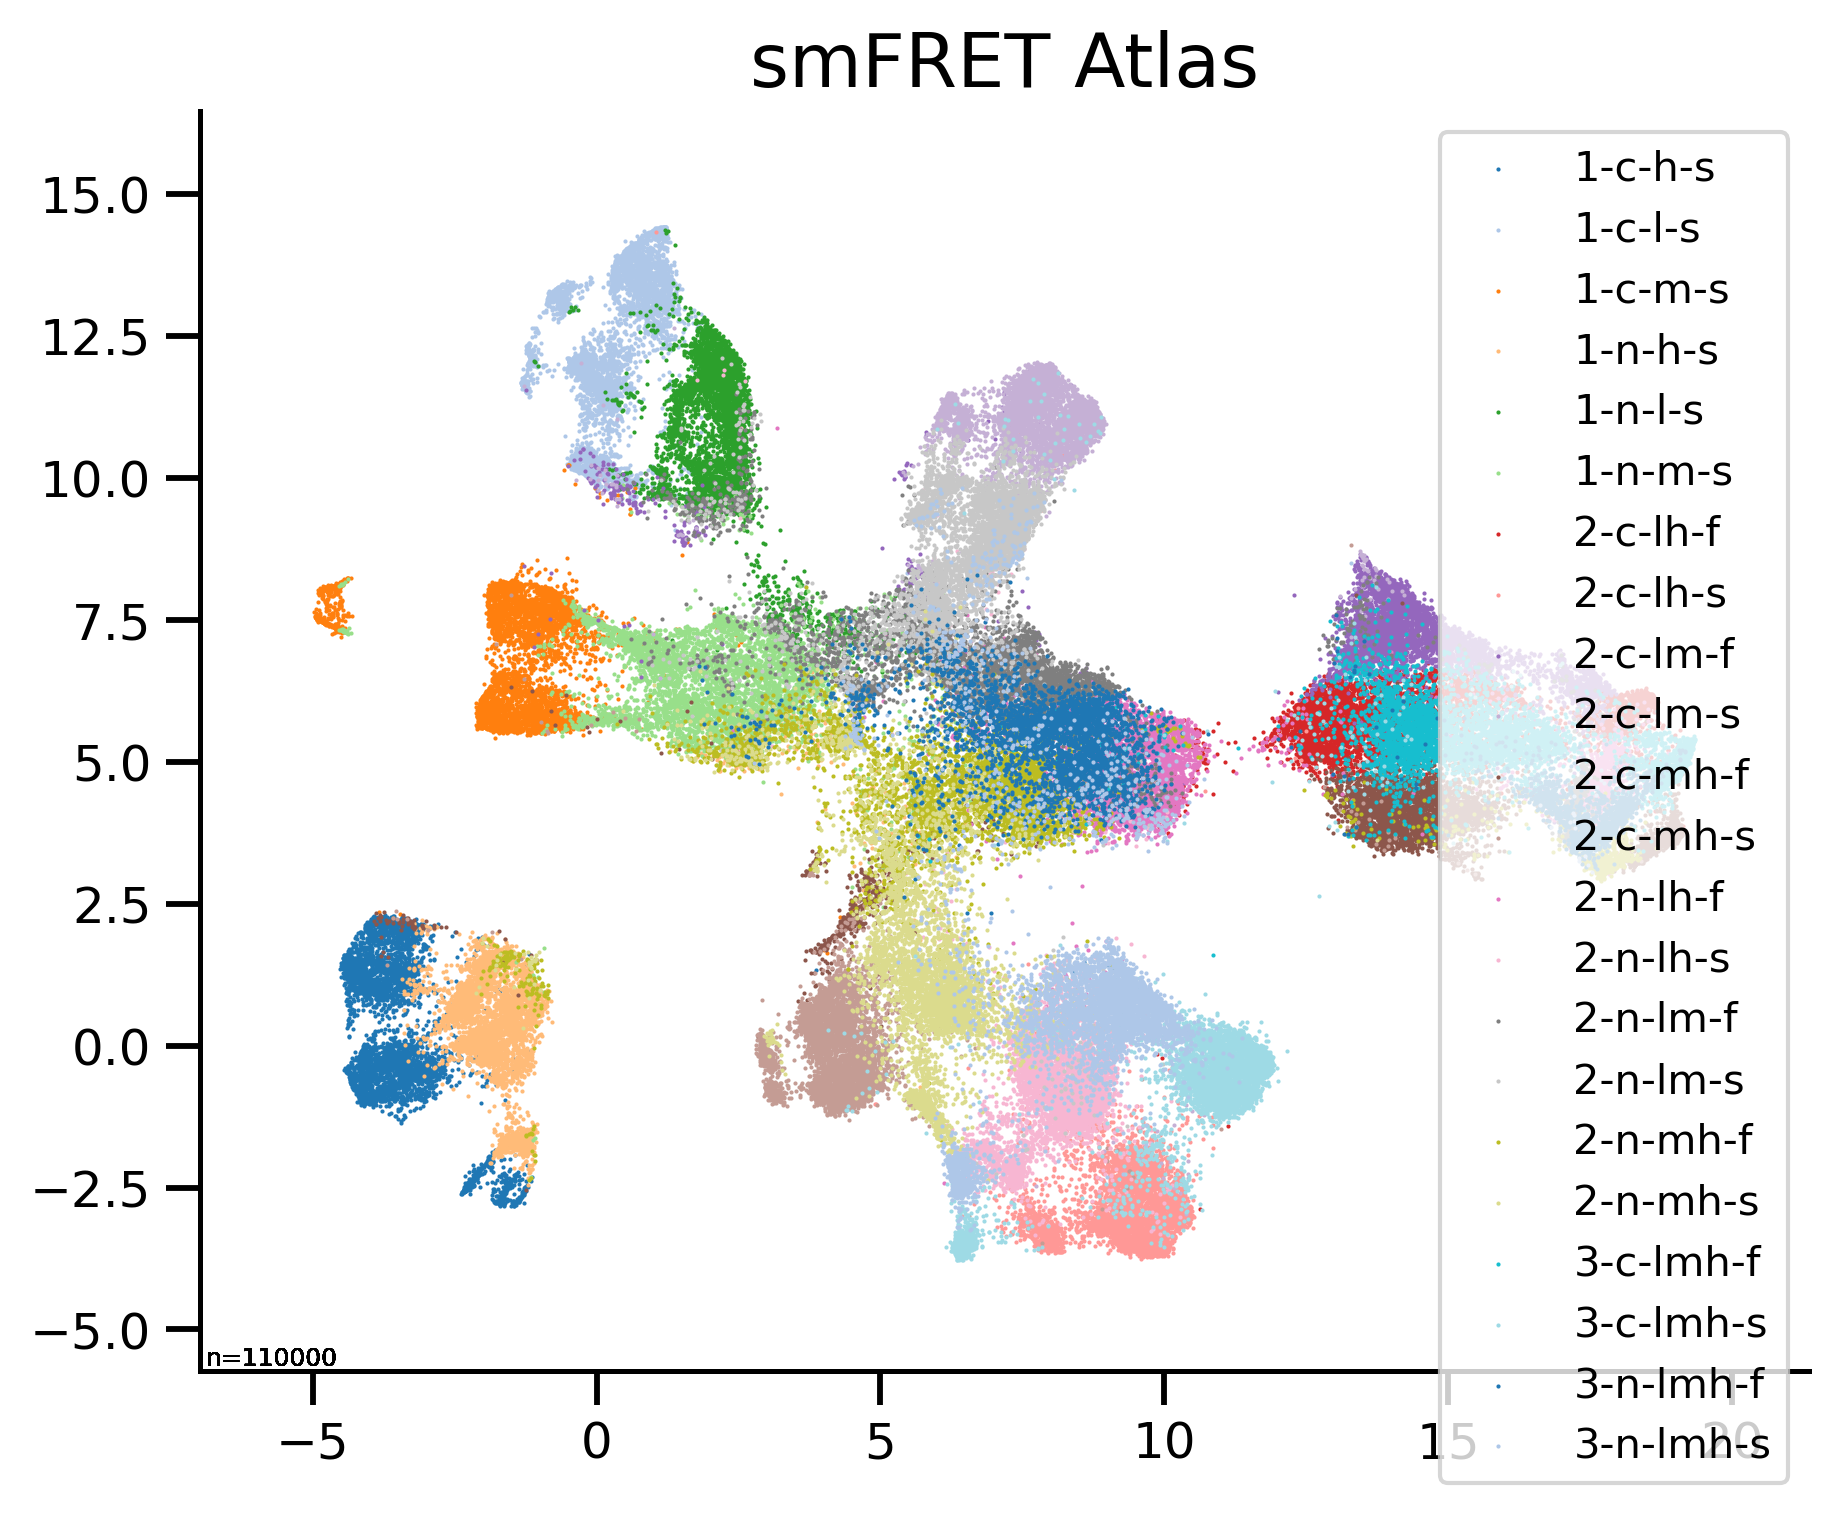

In [89]:
reducer = umap.UMAP(n_epochs=200, n_neighbors=50, min_dist=0.0, random_state=np.random.RandomState(60), n_components=2, negative_sample_rate=10)
umap_embedding = reducer.fit_transform(np.concatenate([simulated_embedding], axis=0))
cutoff = np.quantile(perplexity_simulated, 1.0)
unique_labels = np.unique(simulated_label)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
counter = 0
for l in sorted(unique_labels, key=lambda s: int([*re.findall(string=s, pattern='\d+'), '0'][0])):
    idx = (simulated_label == l)
    z = reducer.transform(simulated_embedding[idx, :][:, :])
    with plt.style.context(spstyle.get_style('nature-reviews')):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color']
        color = plt.cm.tab20.colors
        # for simplex in hull.simplices:
        #     ax.plot(z_central[simplex, 0], z_central[simplex, 1], color[counter % len(color)], linewidth=0.5)
        s = ax.scatter(z[:, 0], z[:, 1], s=1, color=color[counter % len(color)], alpha=1, linewidths=0, label=l)
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.set_xlim([np.min(umap_embedding[:, 0]) - 2, np.max(umap_embedding[:, 0]) + 2])
        ax.set_ylim([np.min(umap_embedding[:, 1]) - 2, np.max(umap_embedding[:, 1]) + 2])
        ax.set_aspect('equal')
        plt.title('smFRET Atlas')
        ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={simulated_embedding.shape[0]}', fontdict={'size': 6})
        # fig.colorbar(s, ax=ax)
    counter += 1
ax.legend()
# plt.savefig('figures/atlas.svg', transparent=True, dpi=120)

In [90]:
# joblib.dump(reducer, 'saved_models/UMAP/atlas_pp.joblib')

['saved_models/UMAP/atlas_pp.joblib']

In [110]:
reducer = joblib.load('saved_models/UMAP/atlas_pp.joblib')

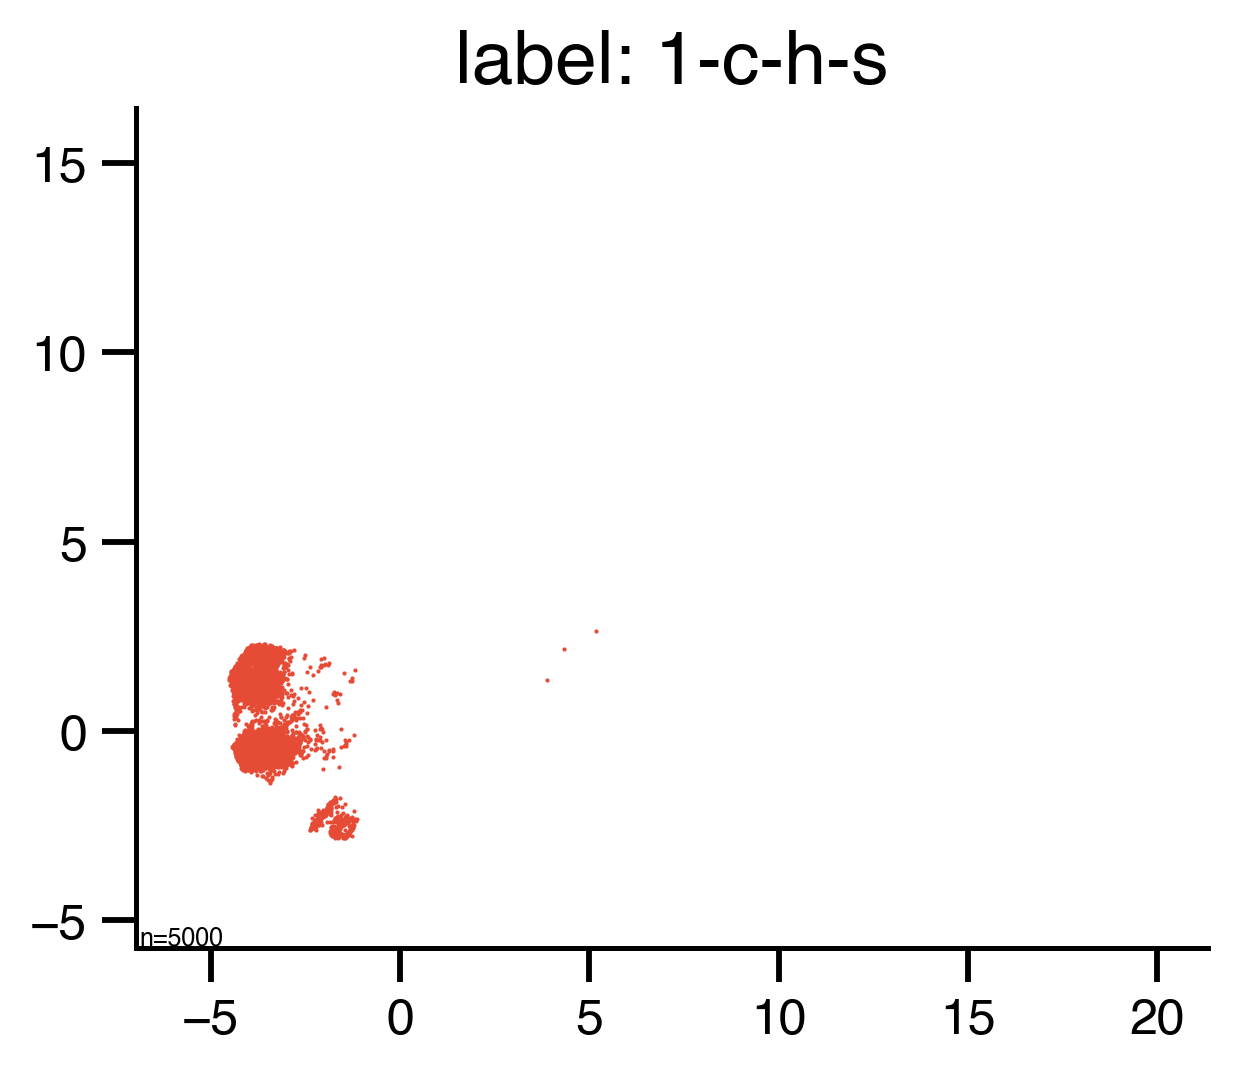

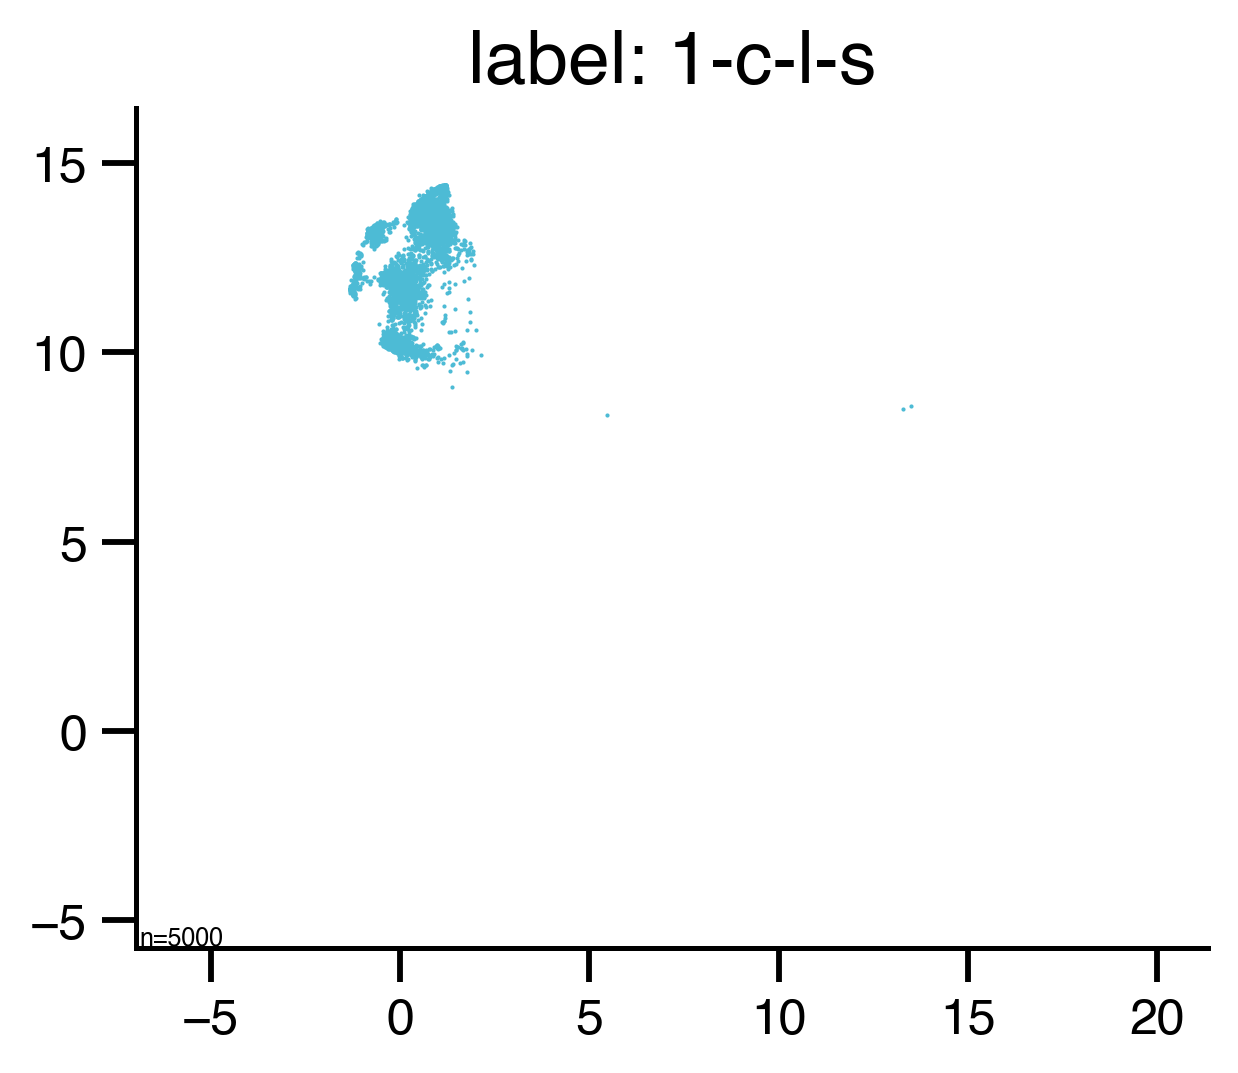

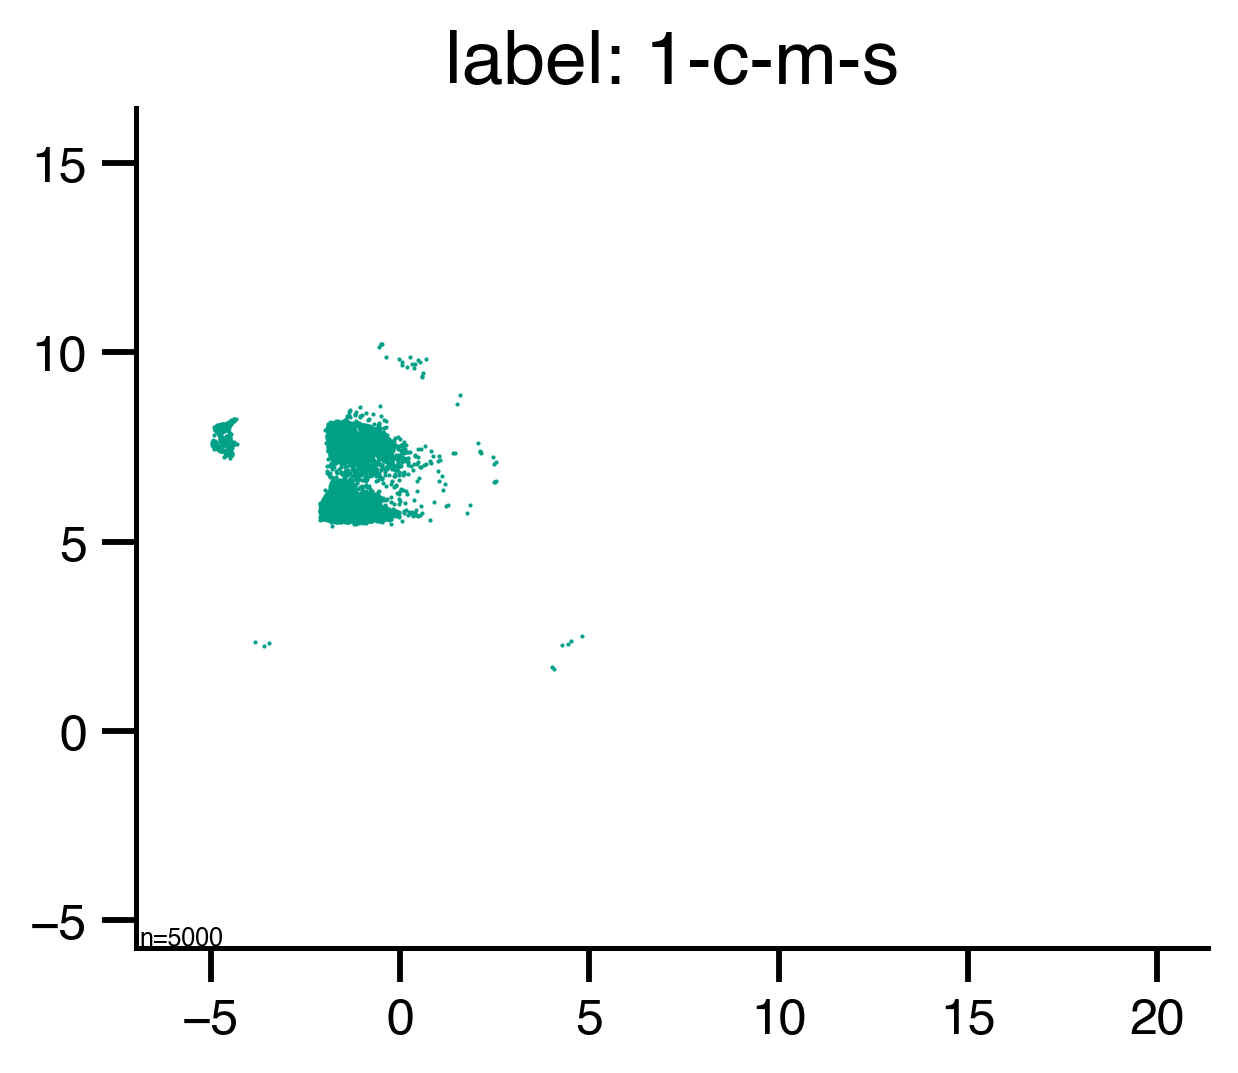

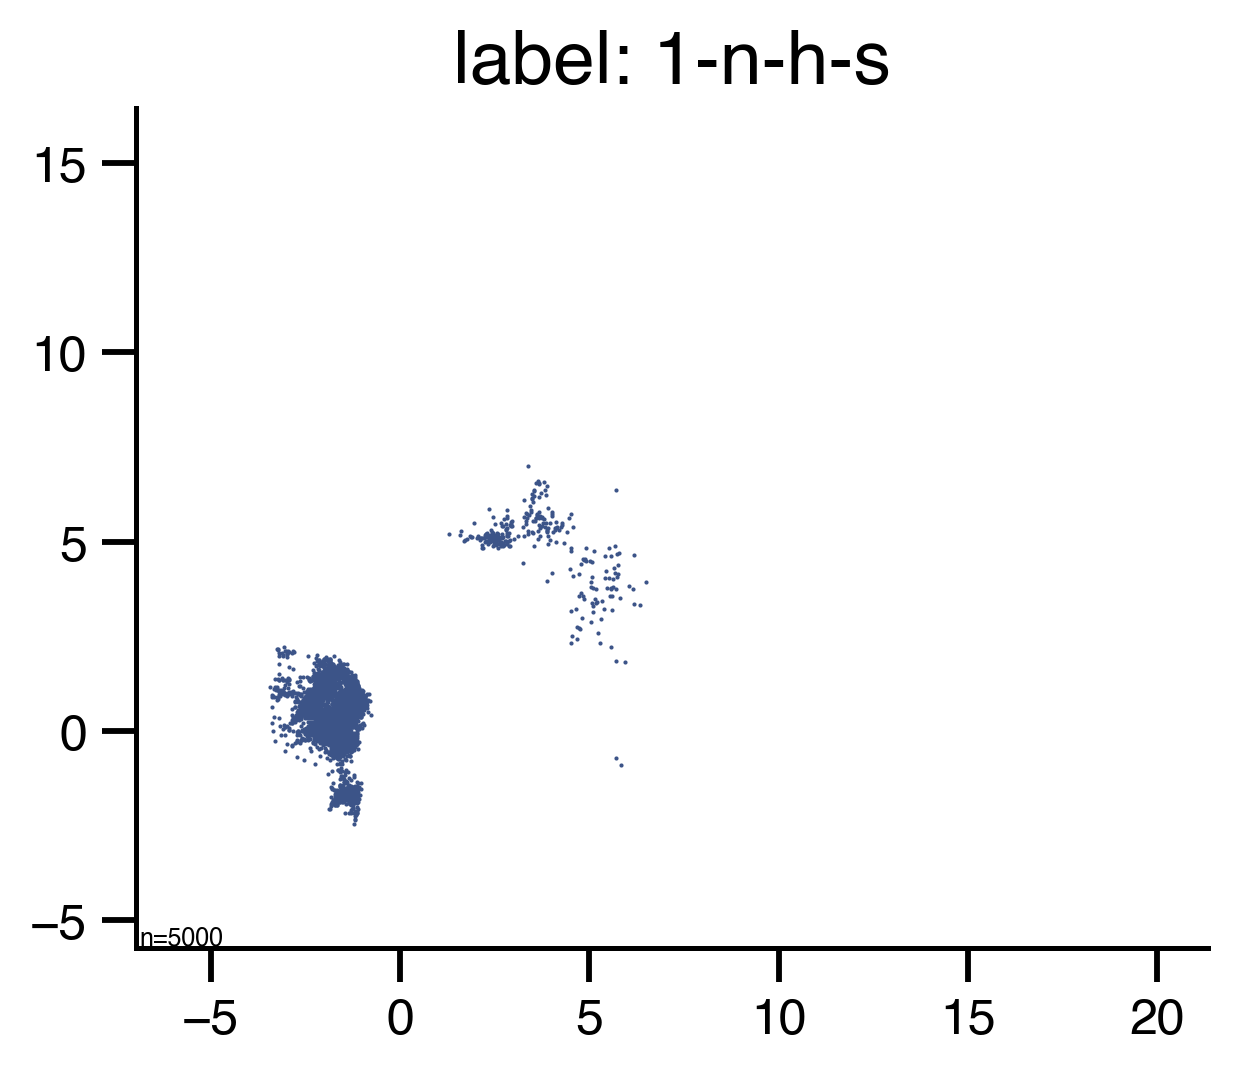

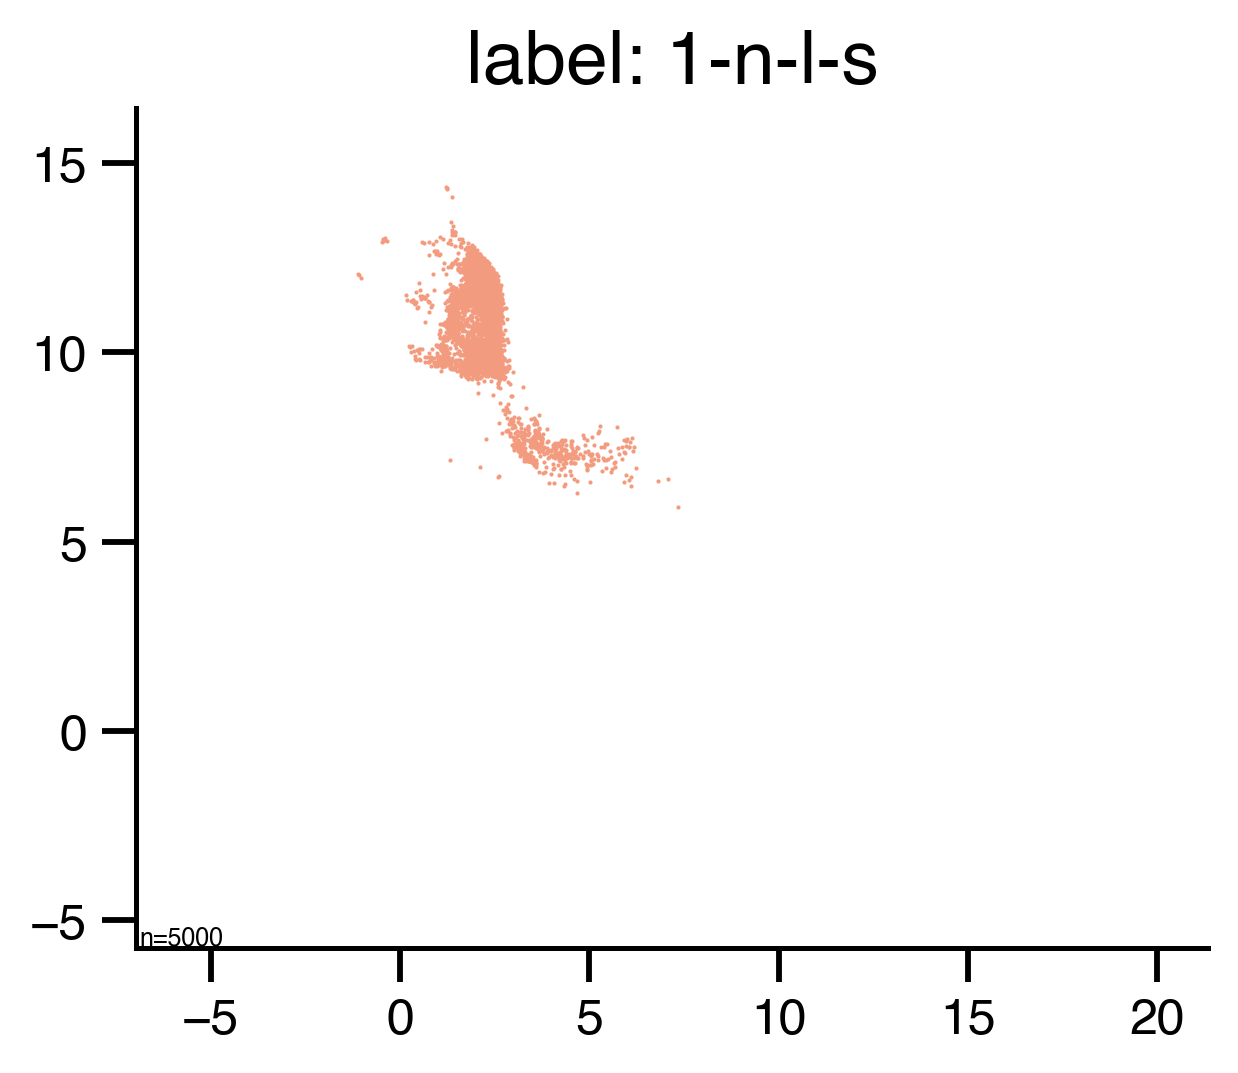

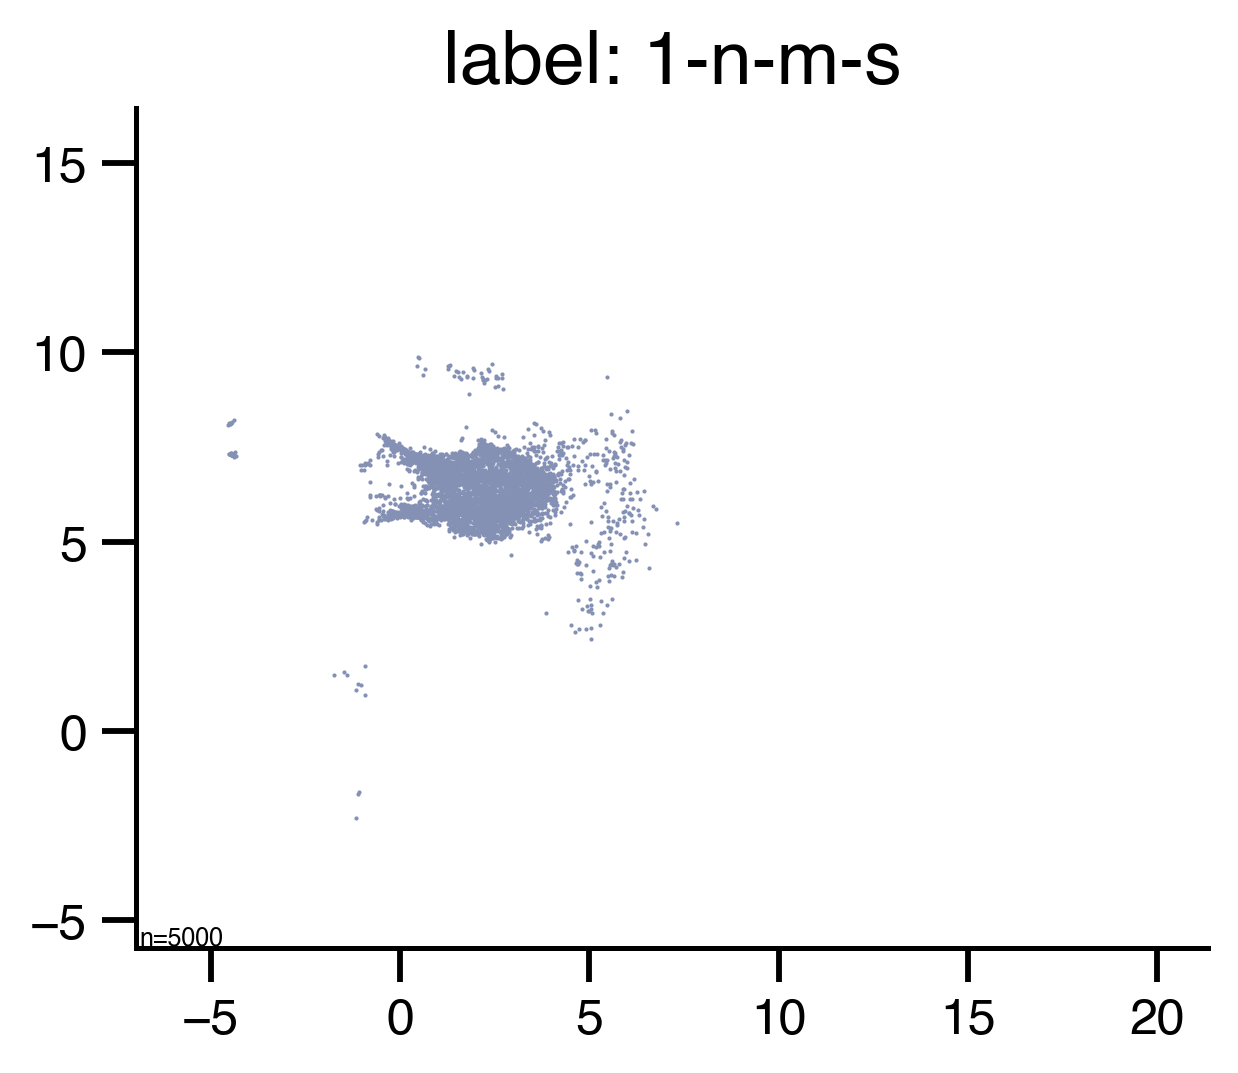

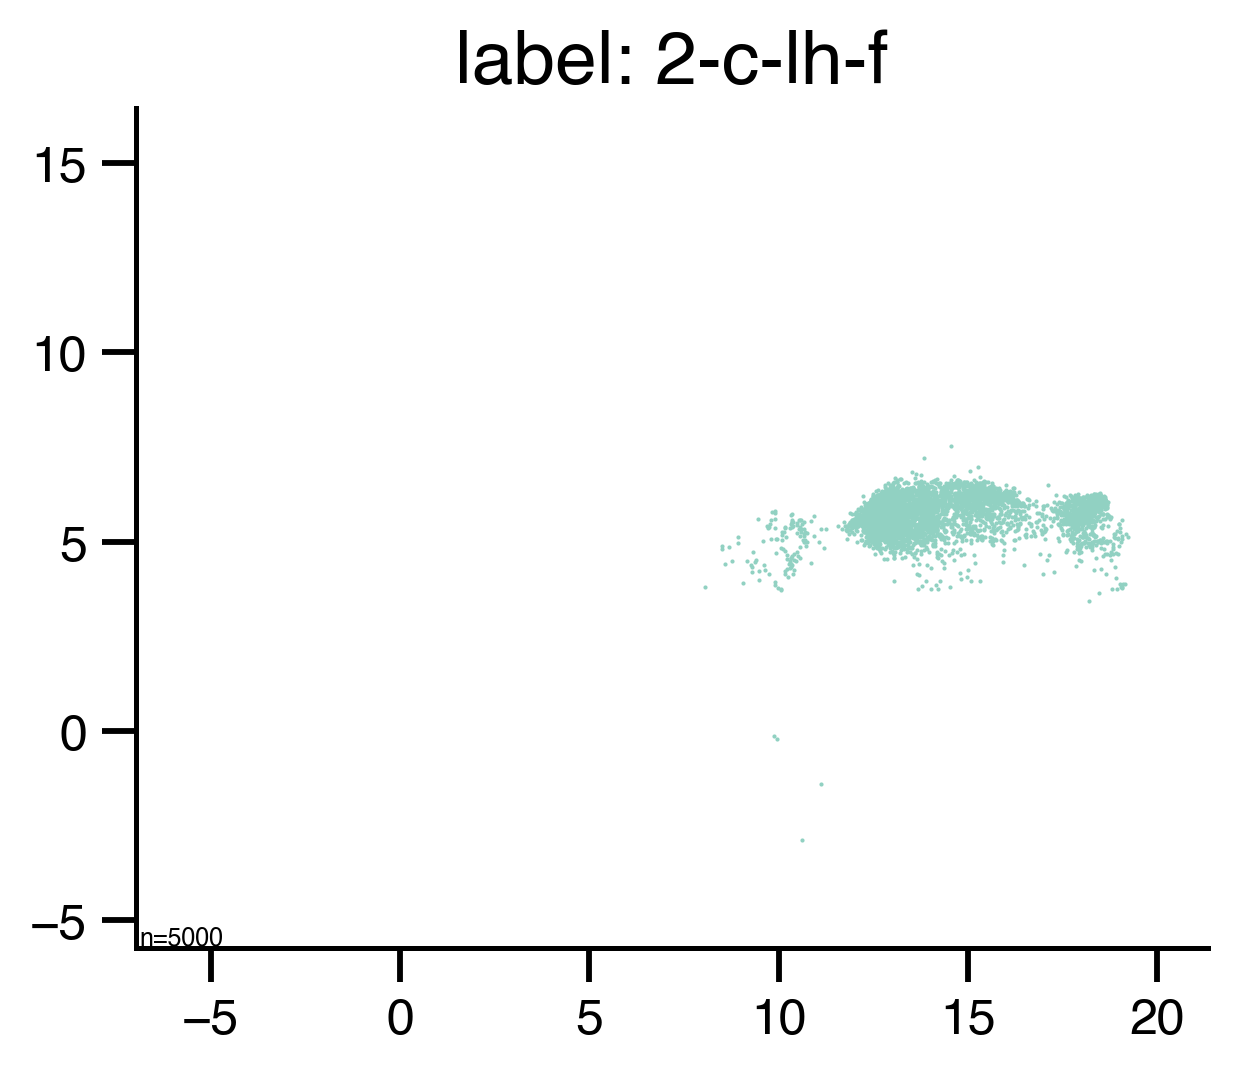

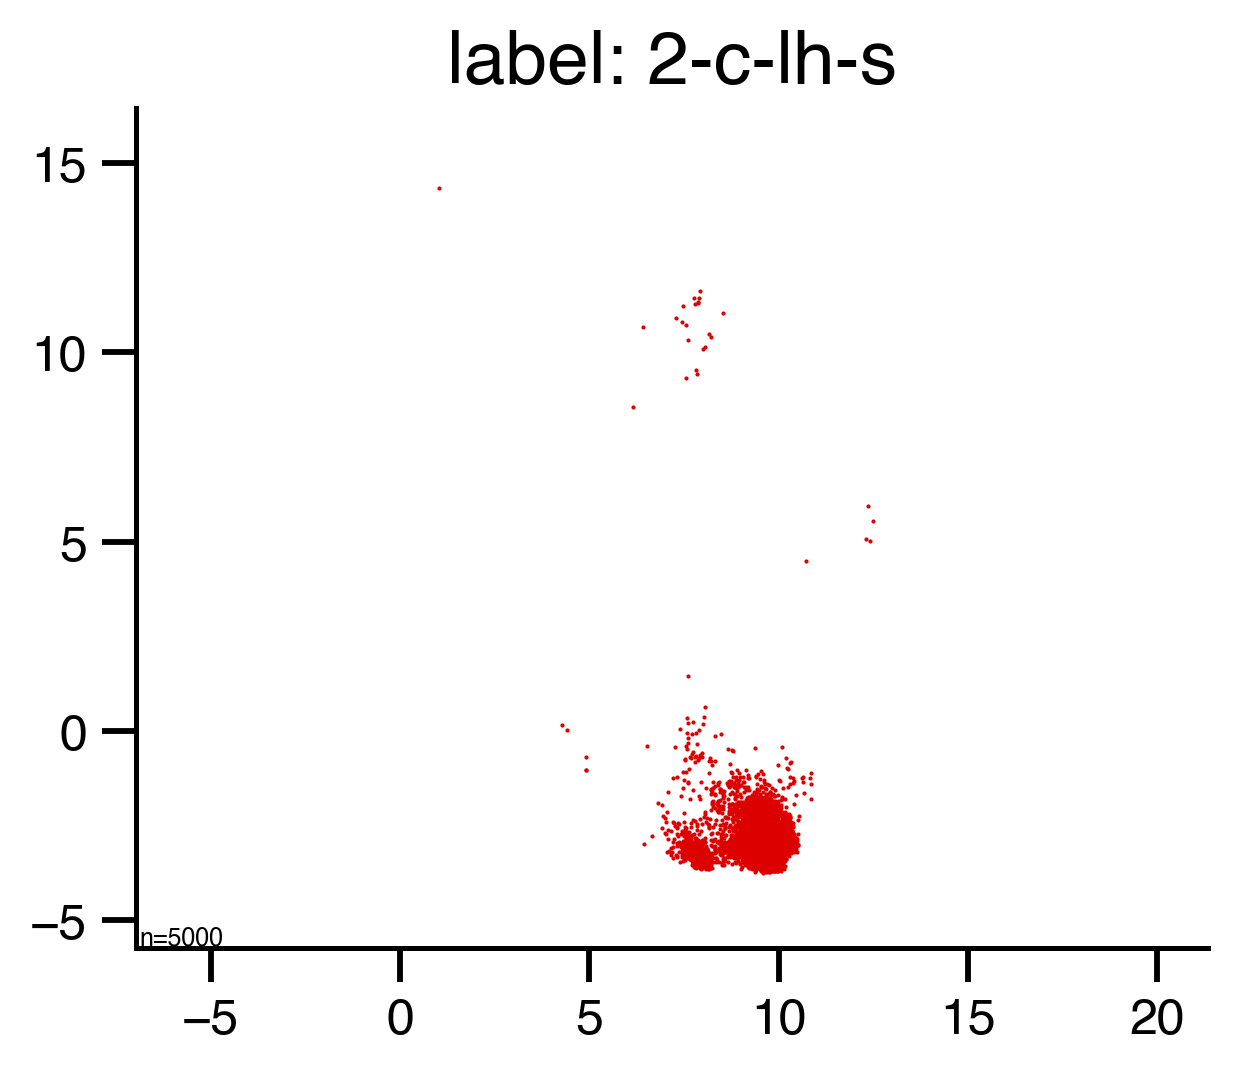

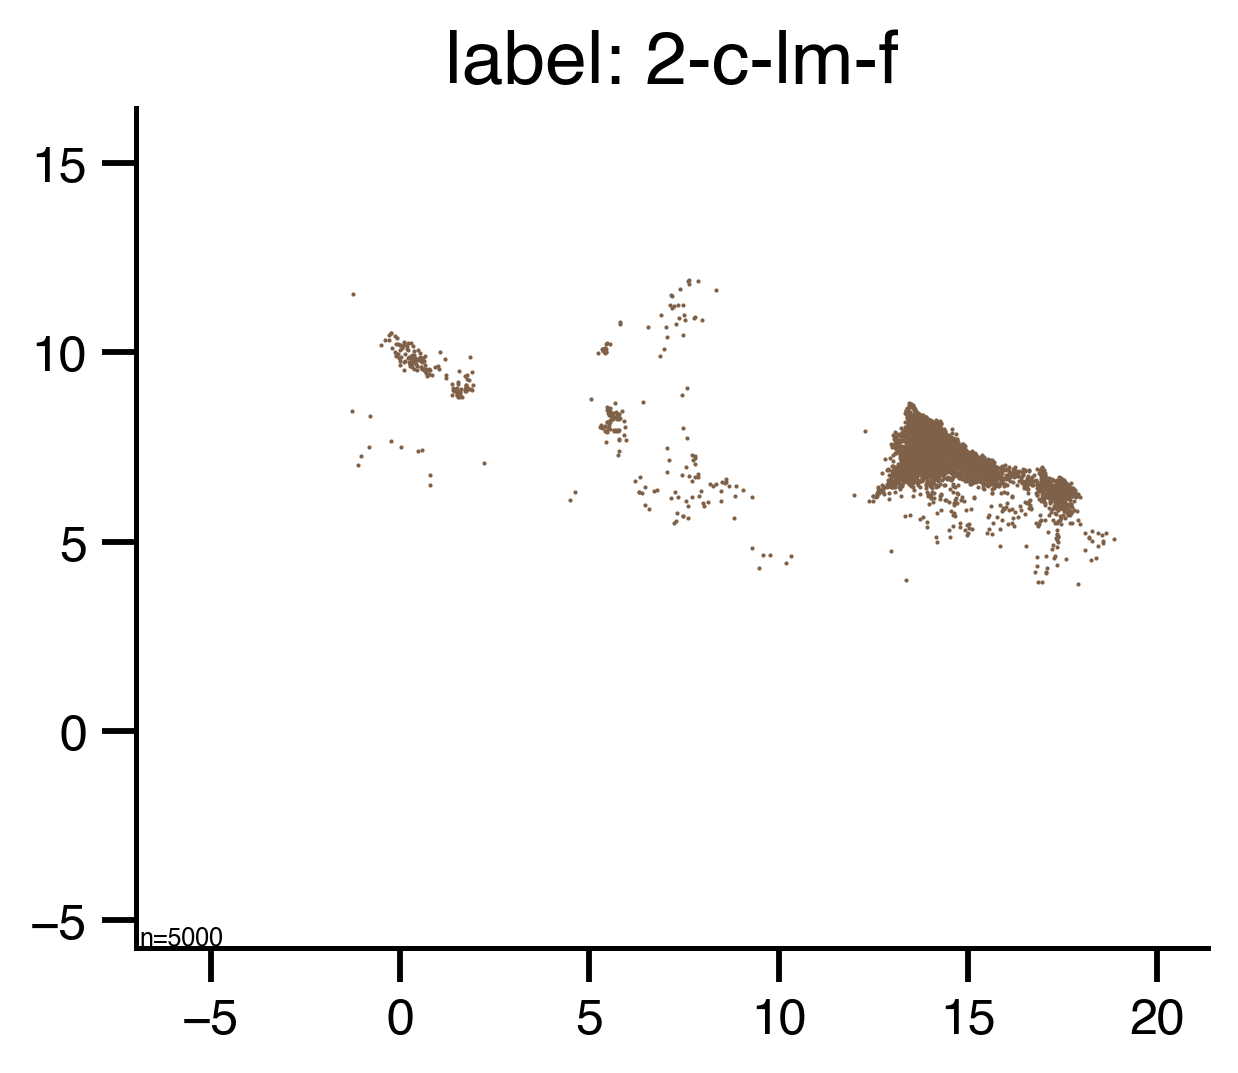

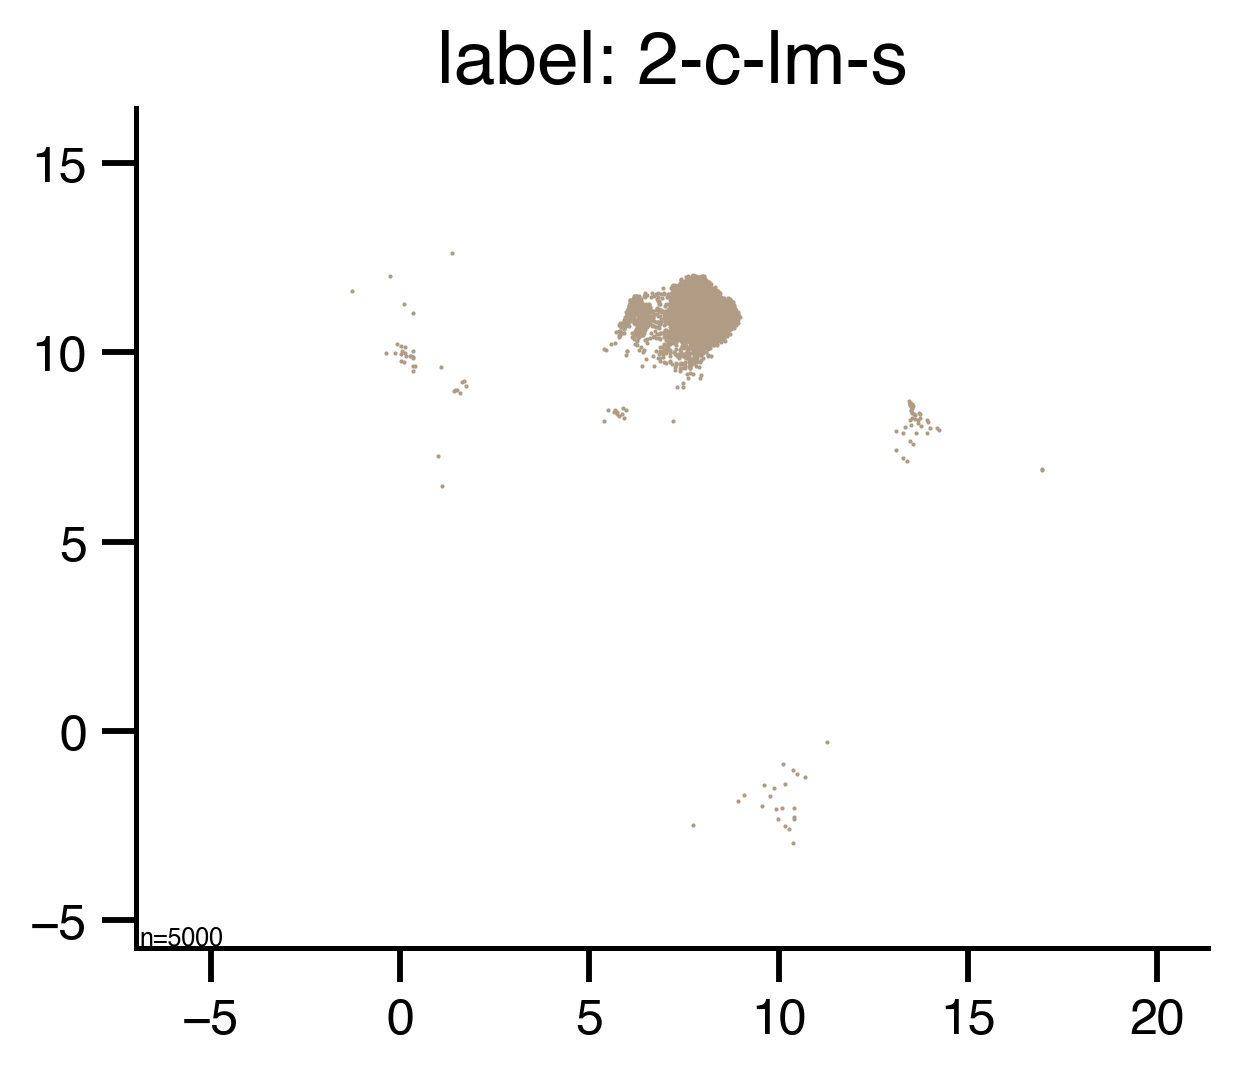

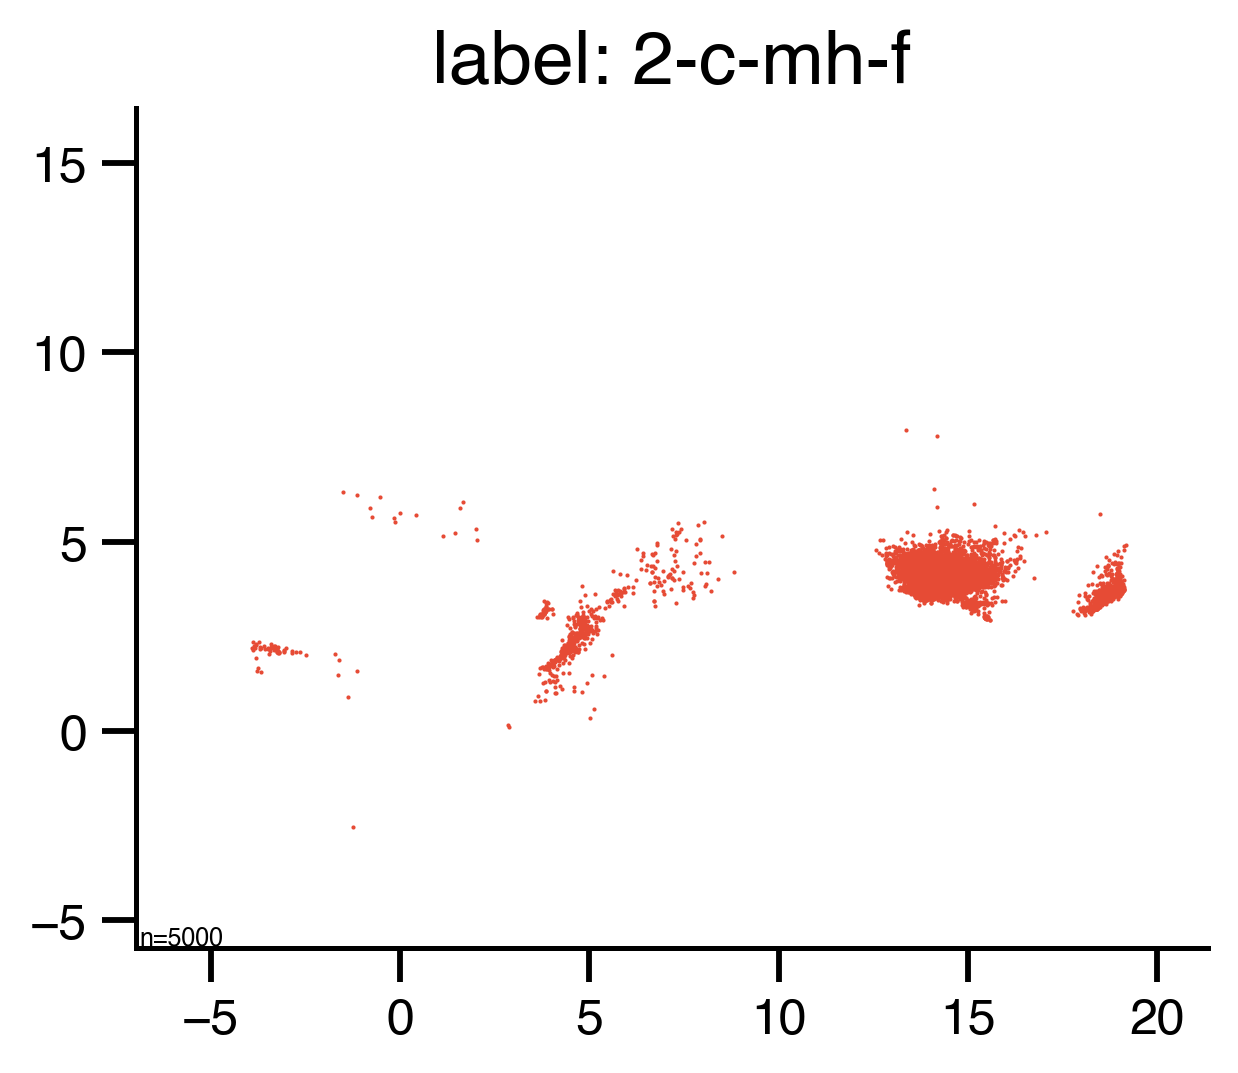

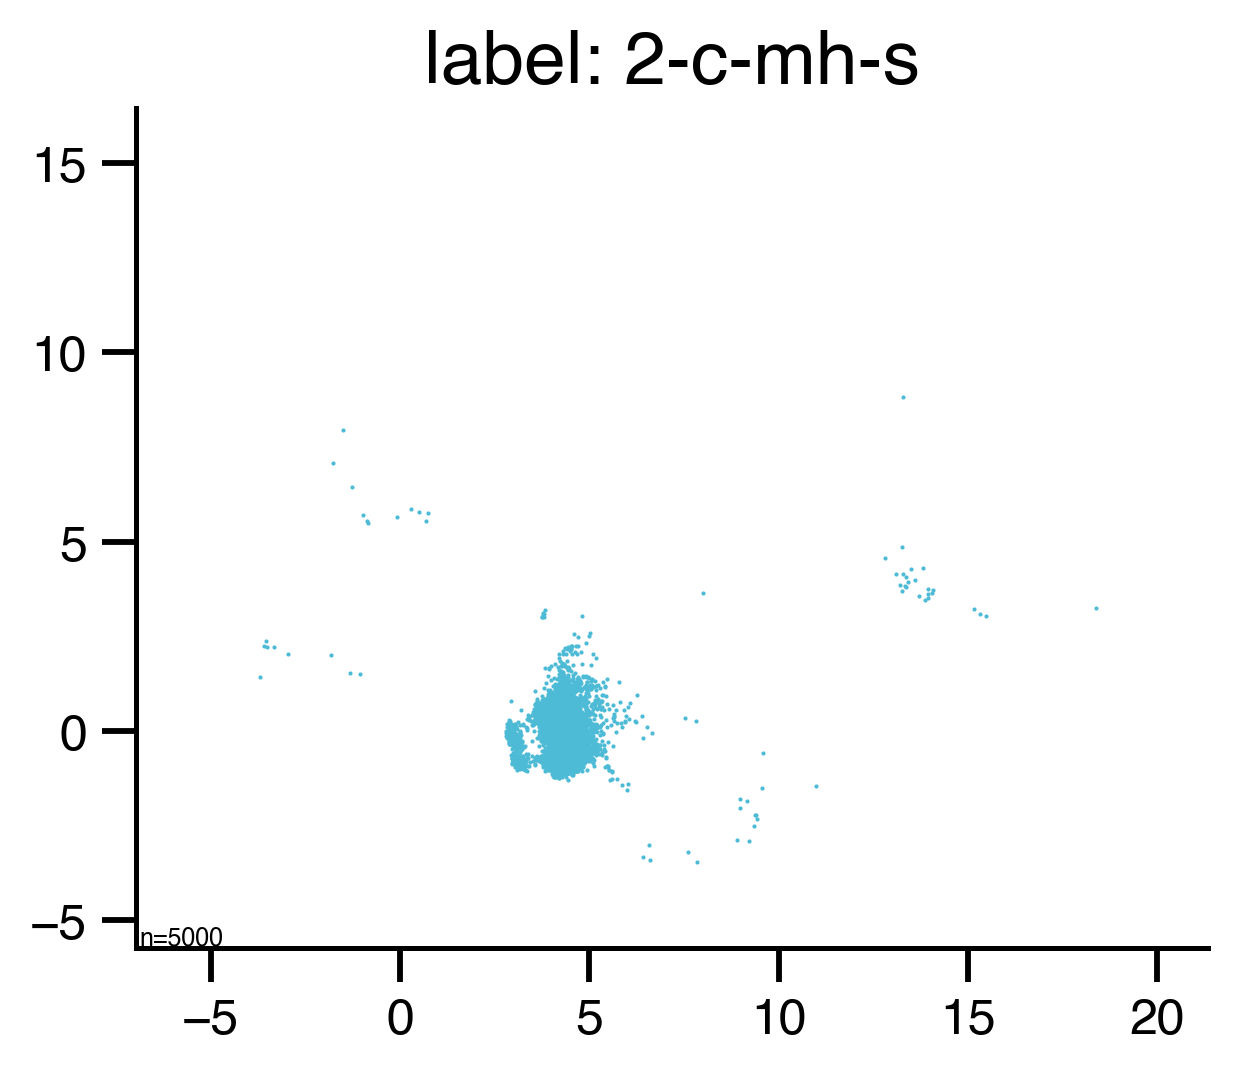

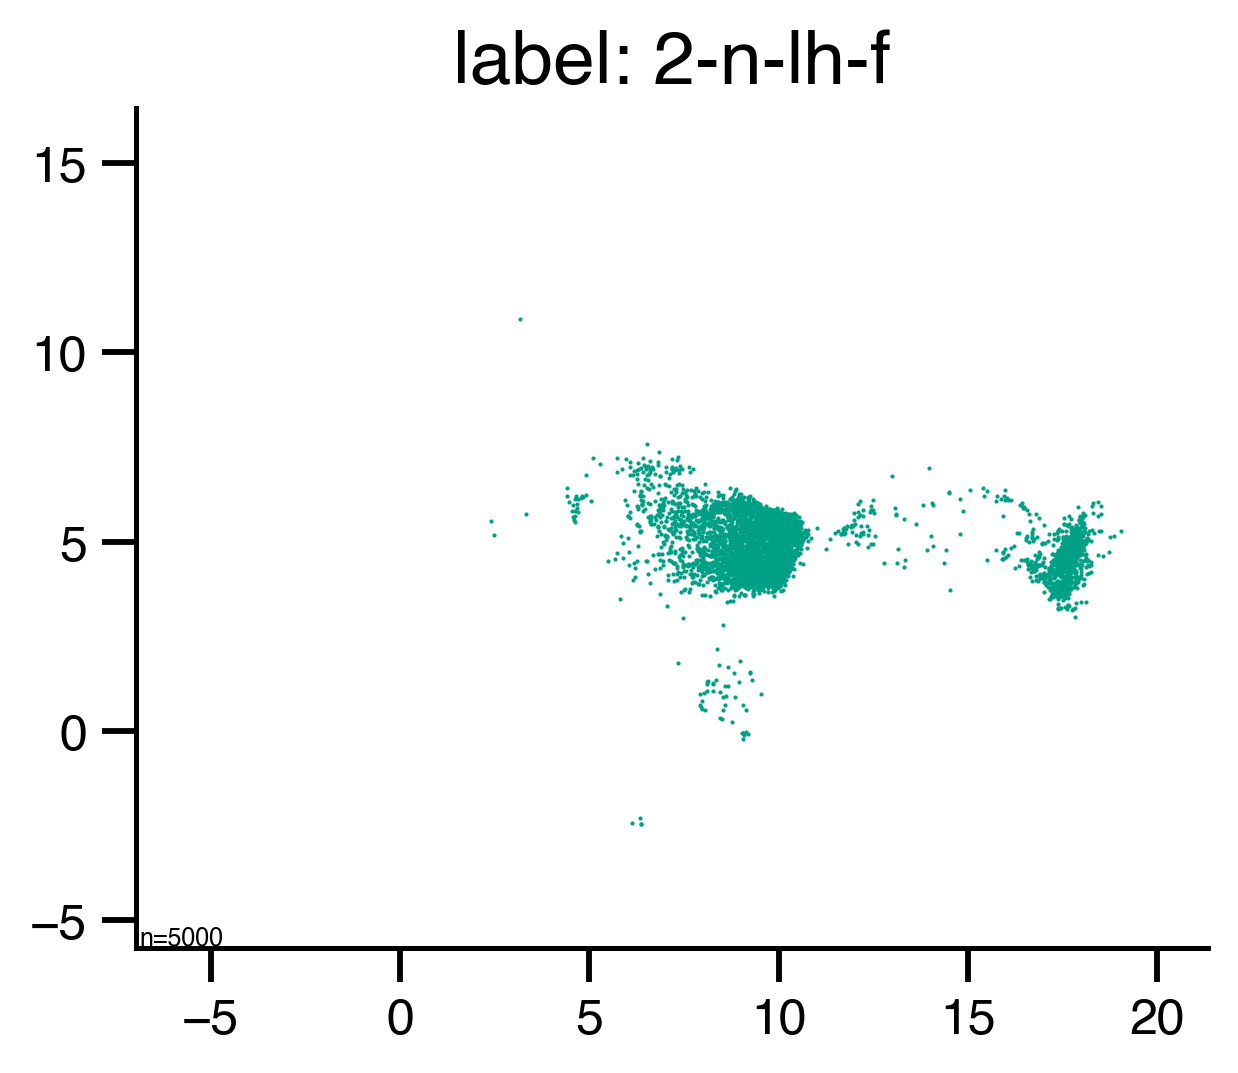

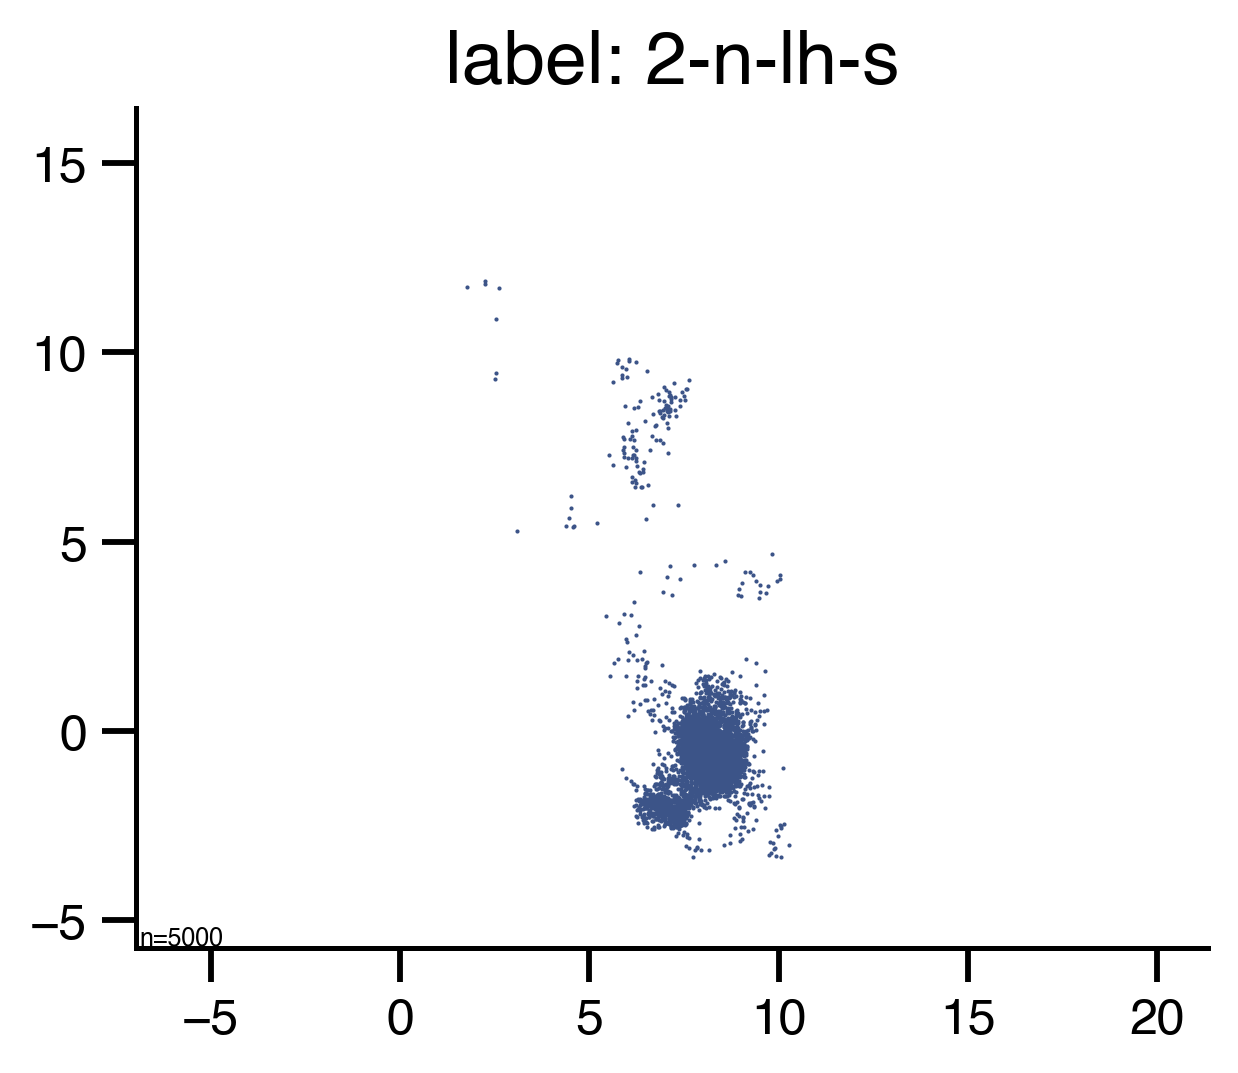

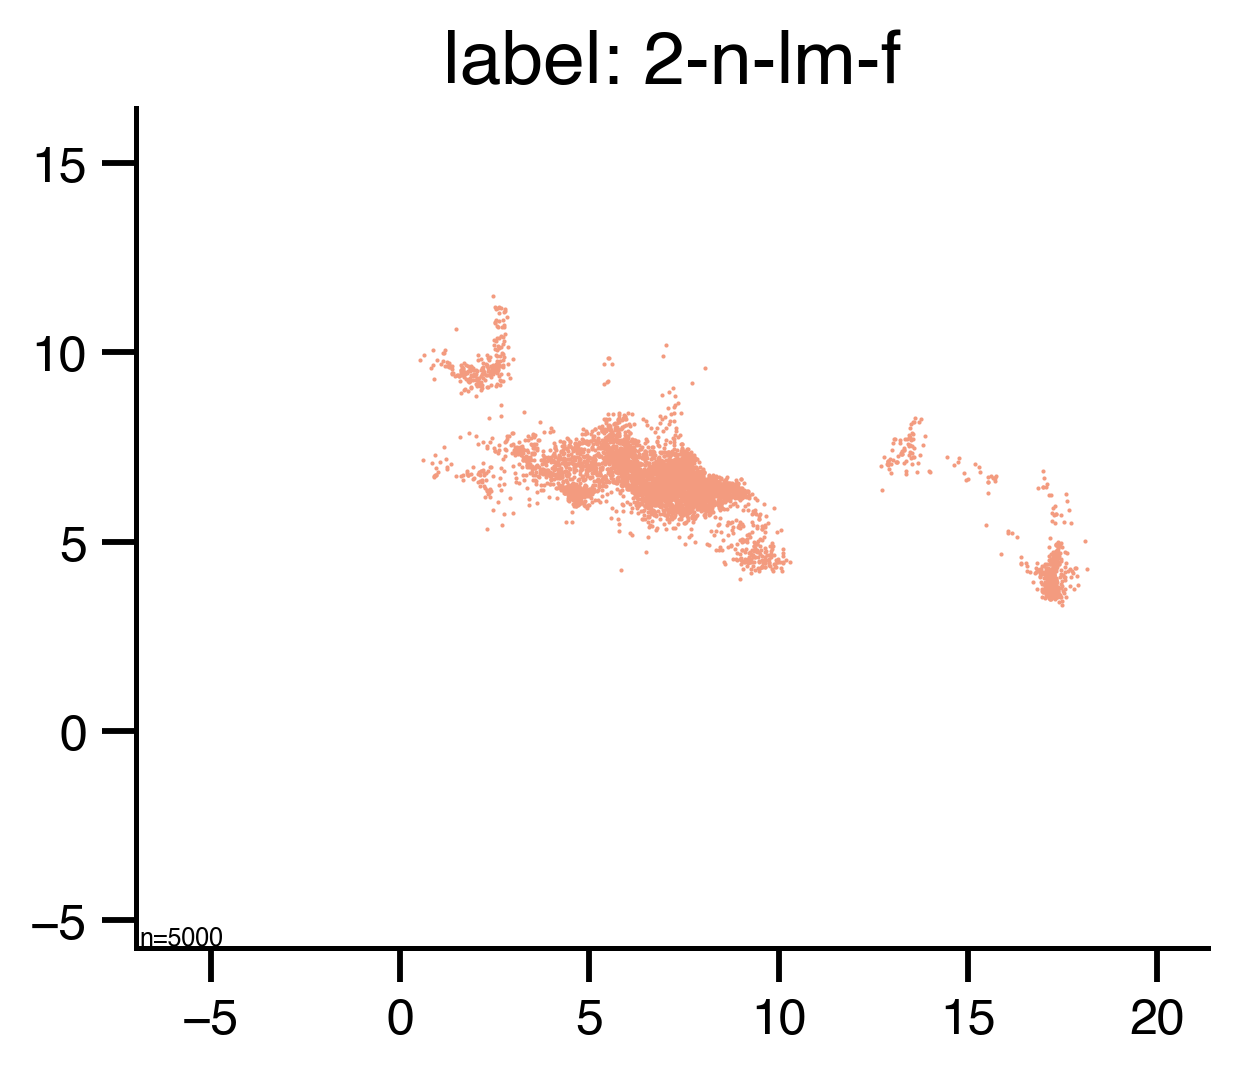

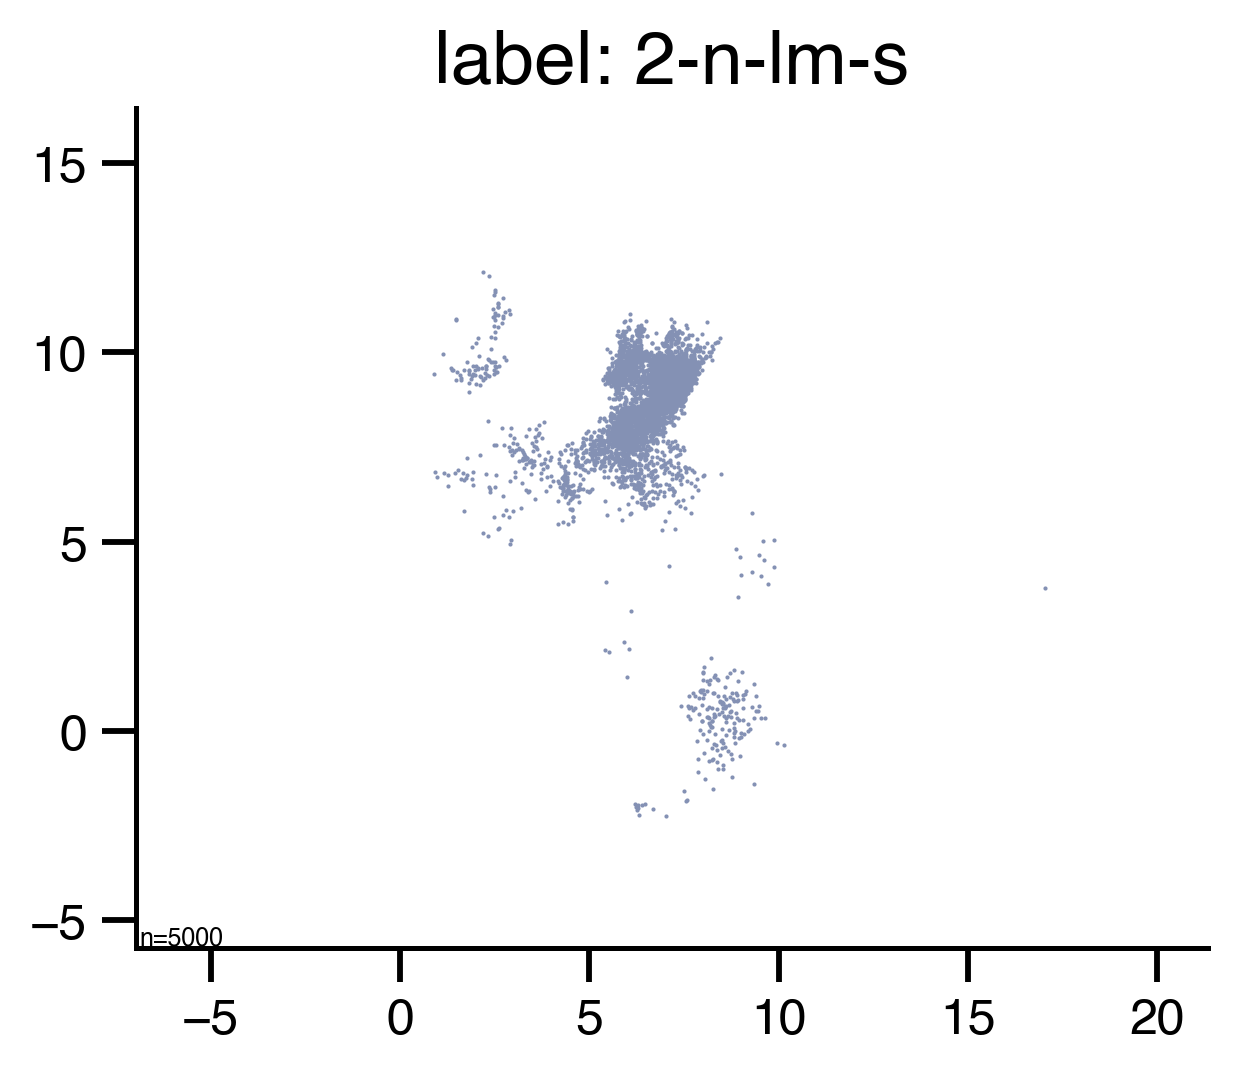

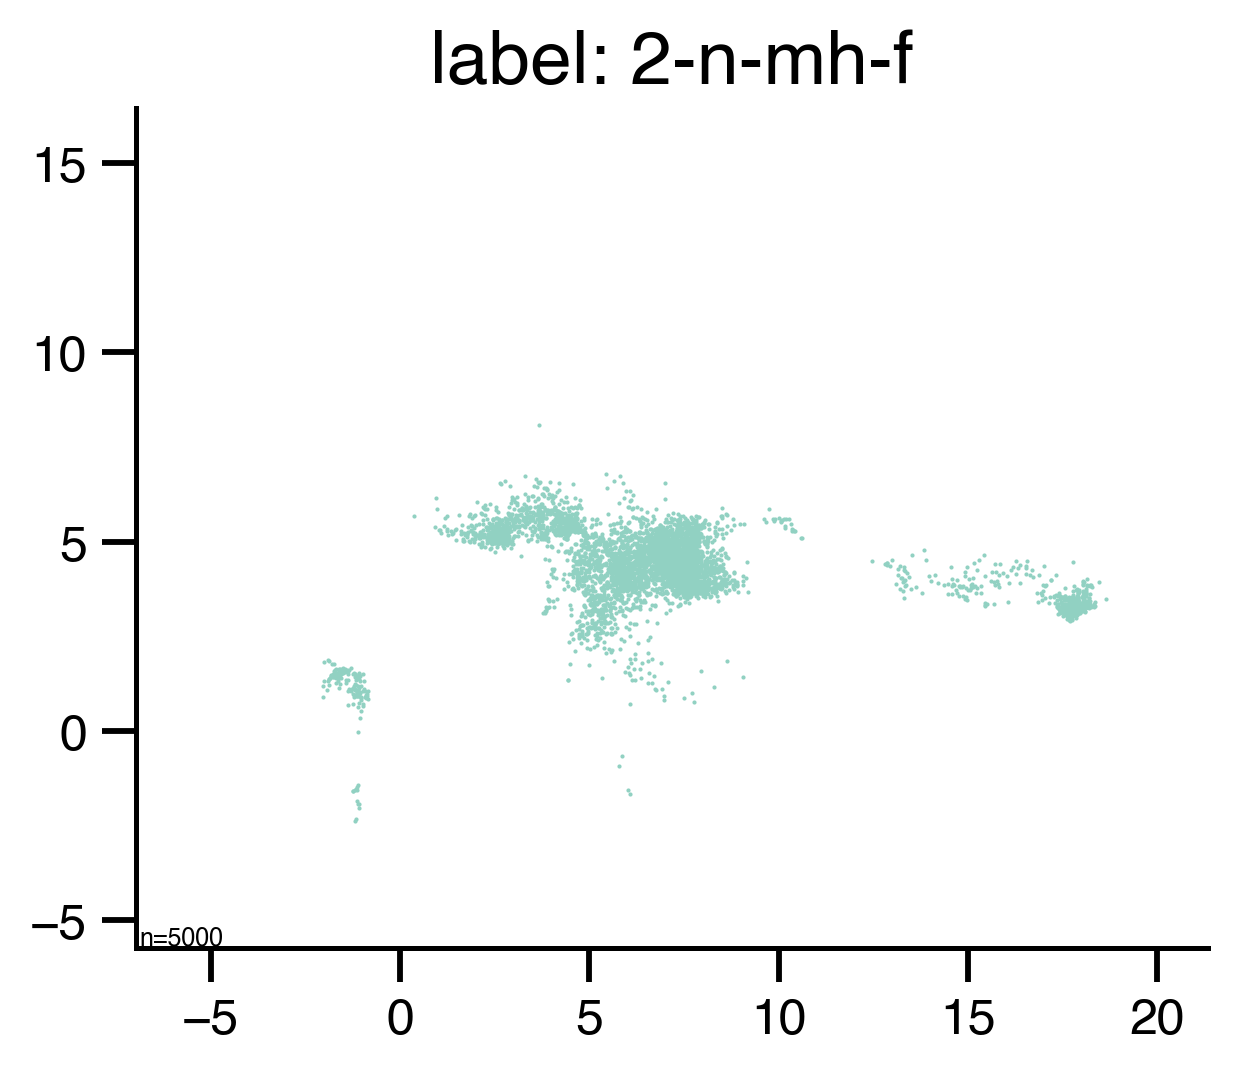

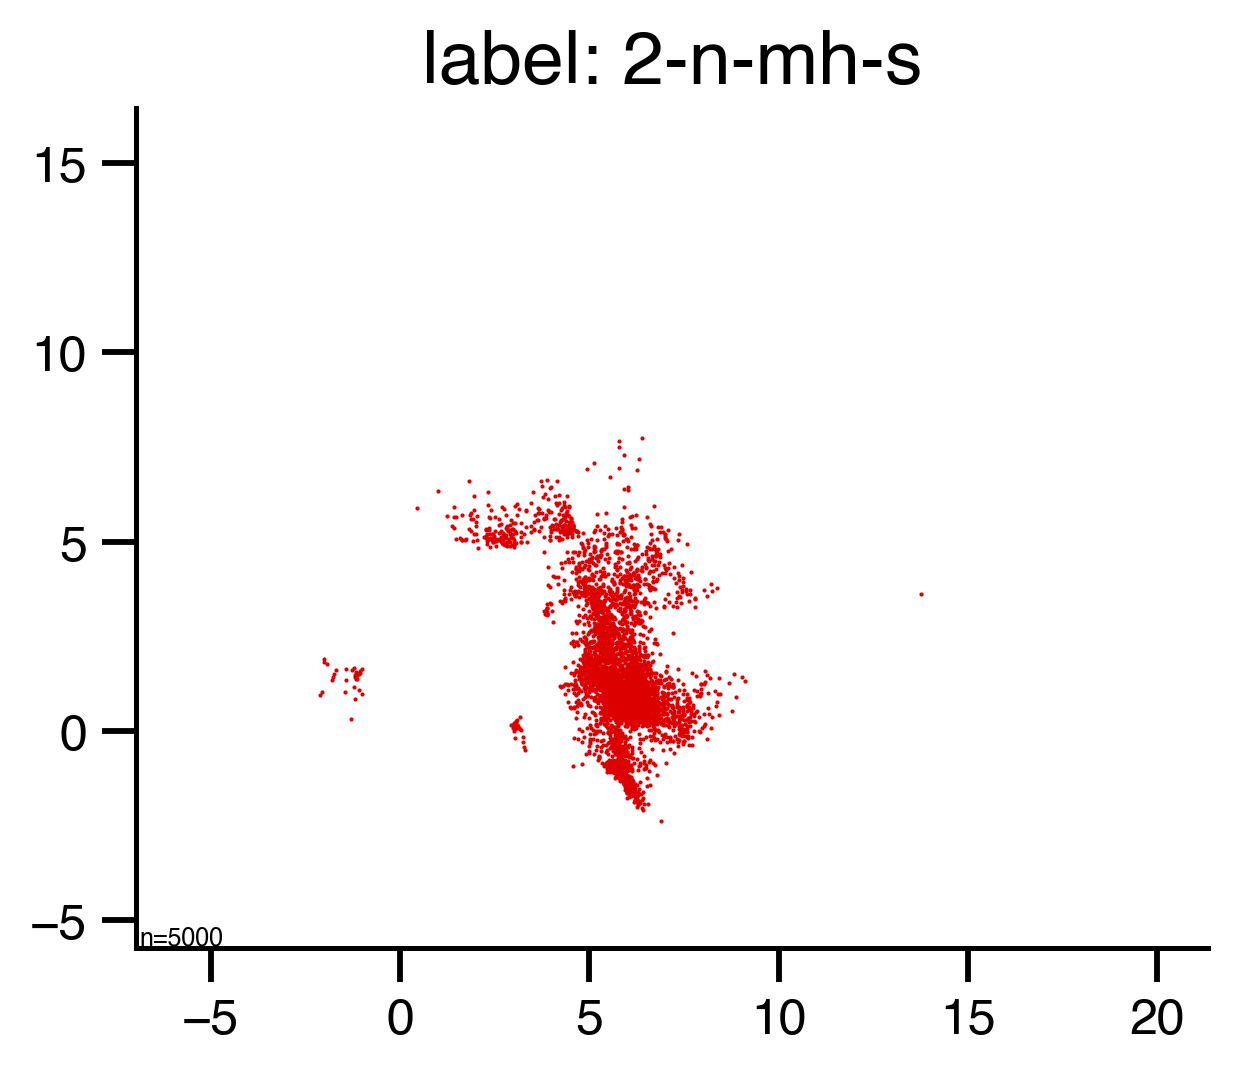

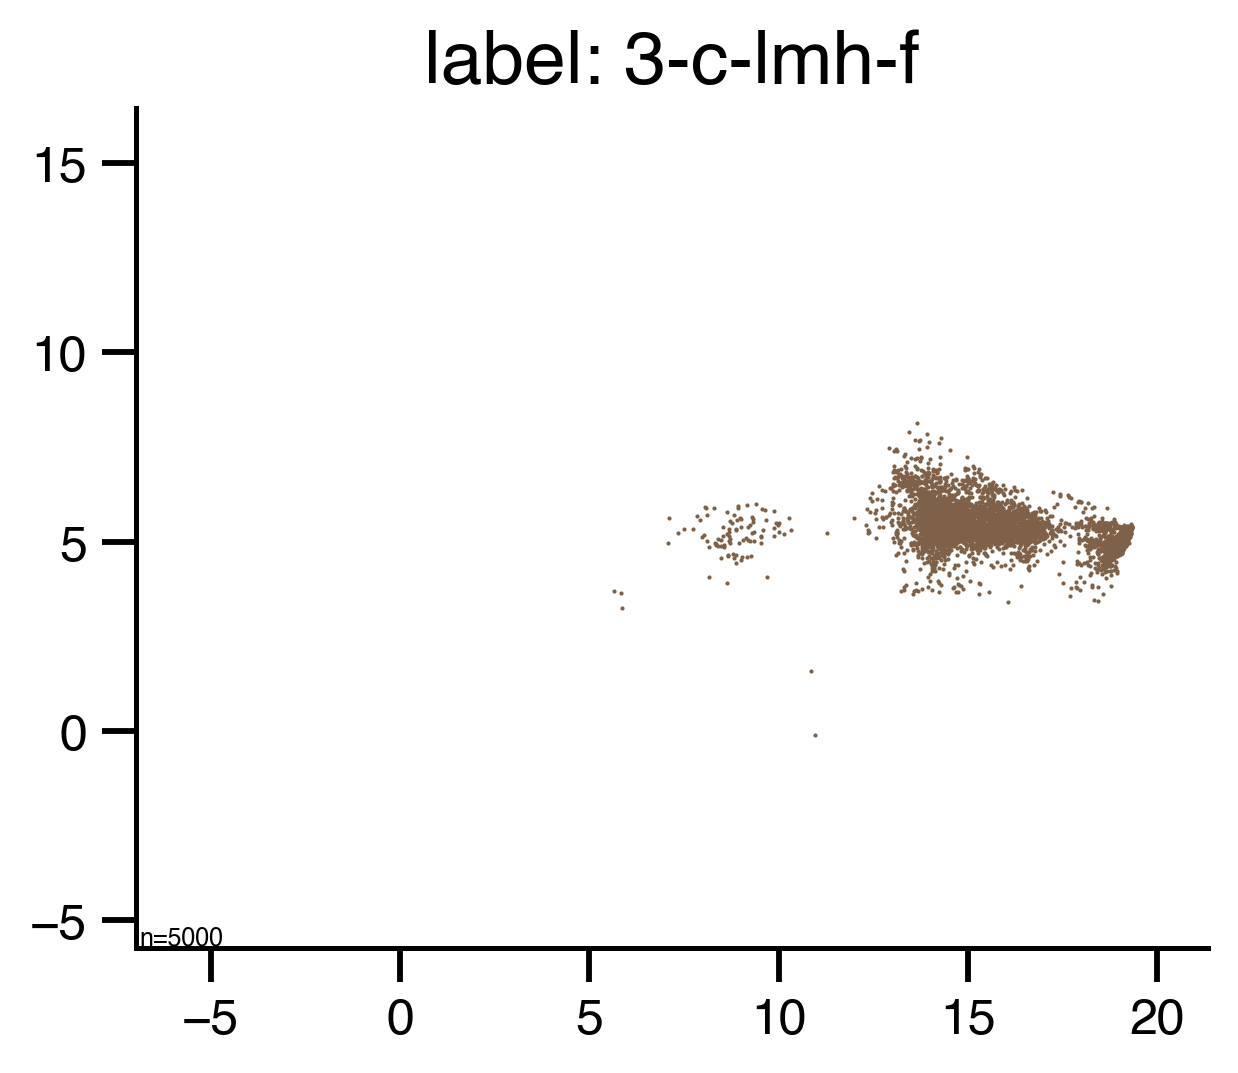

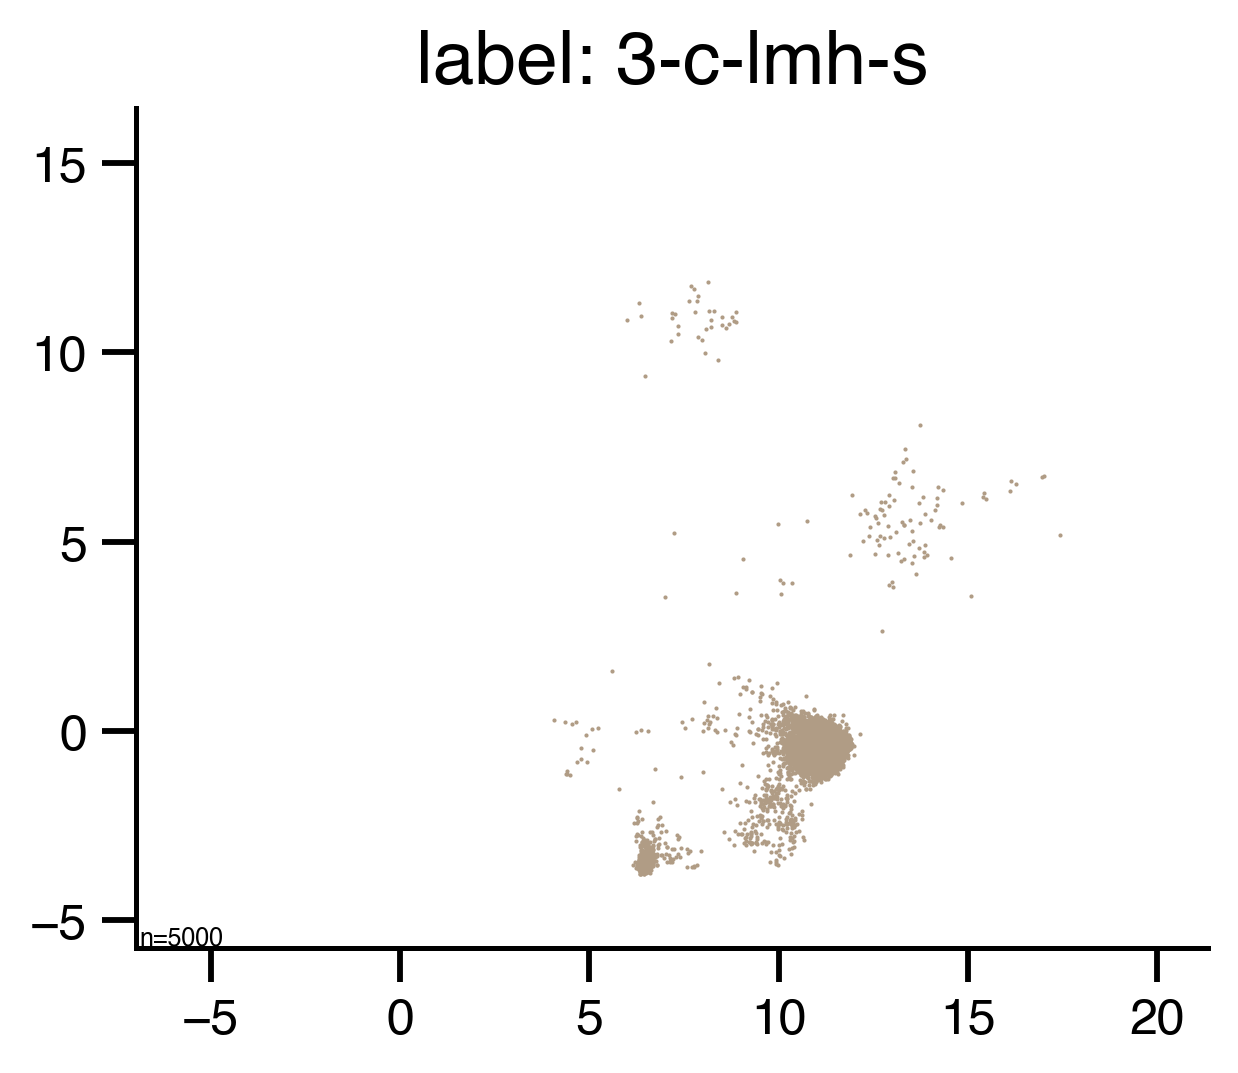

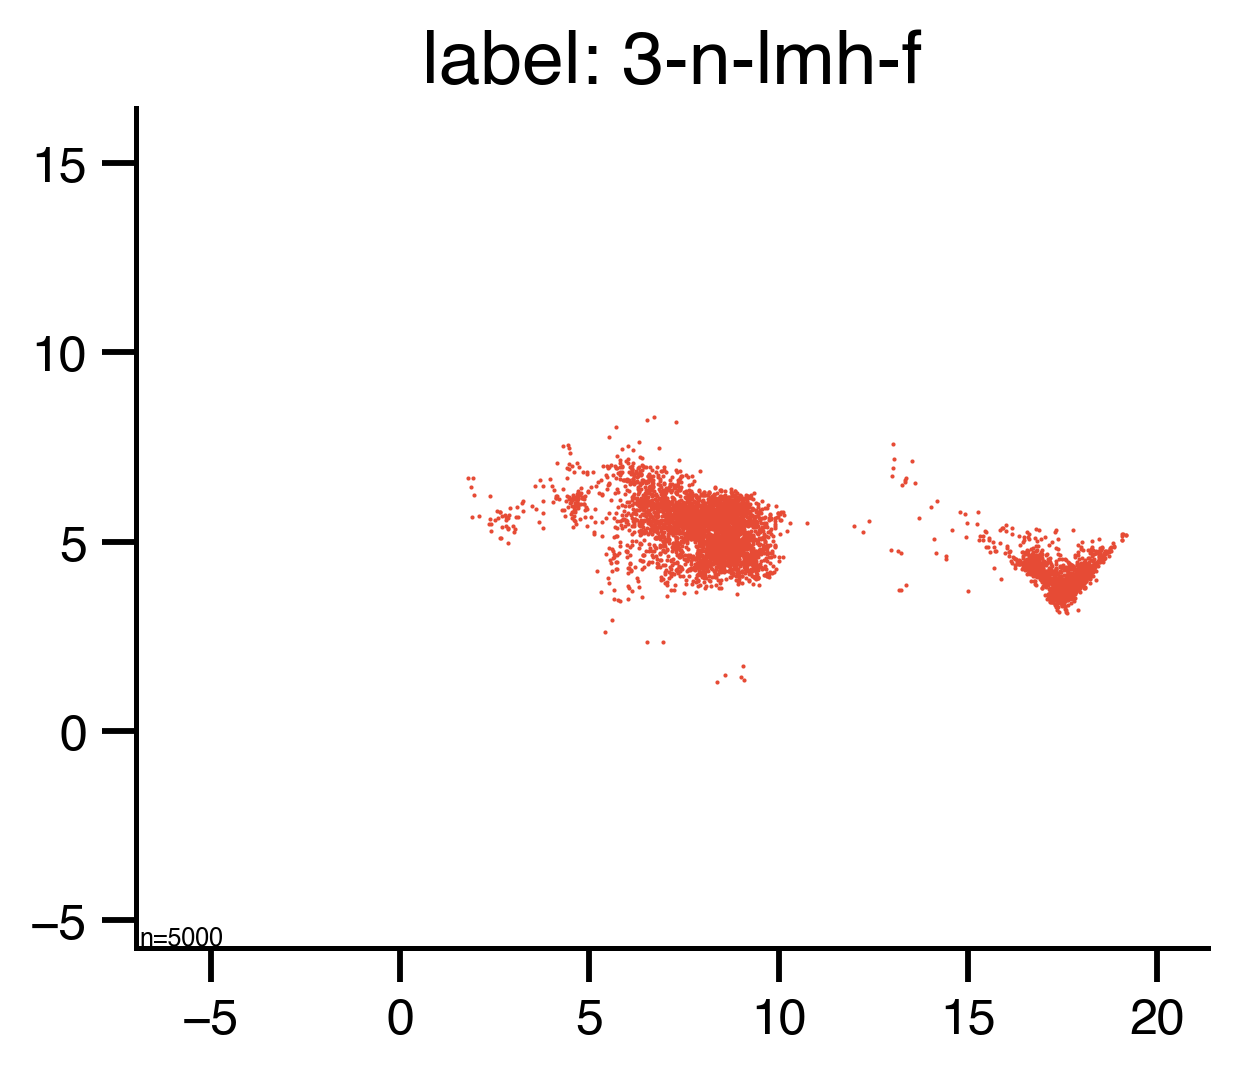

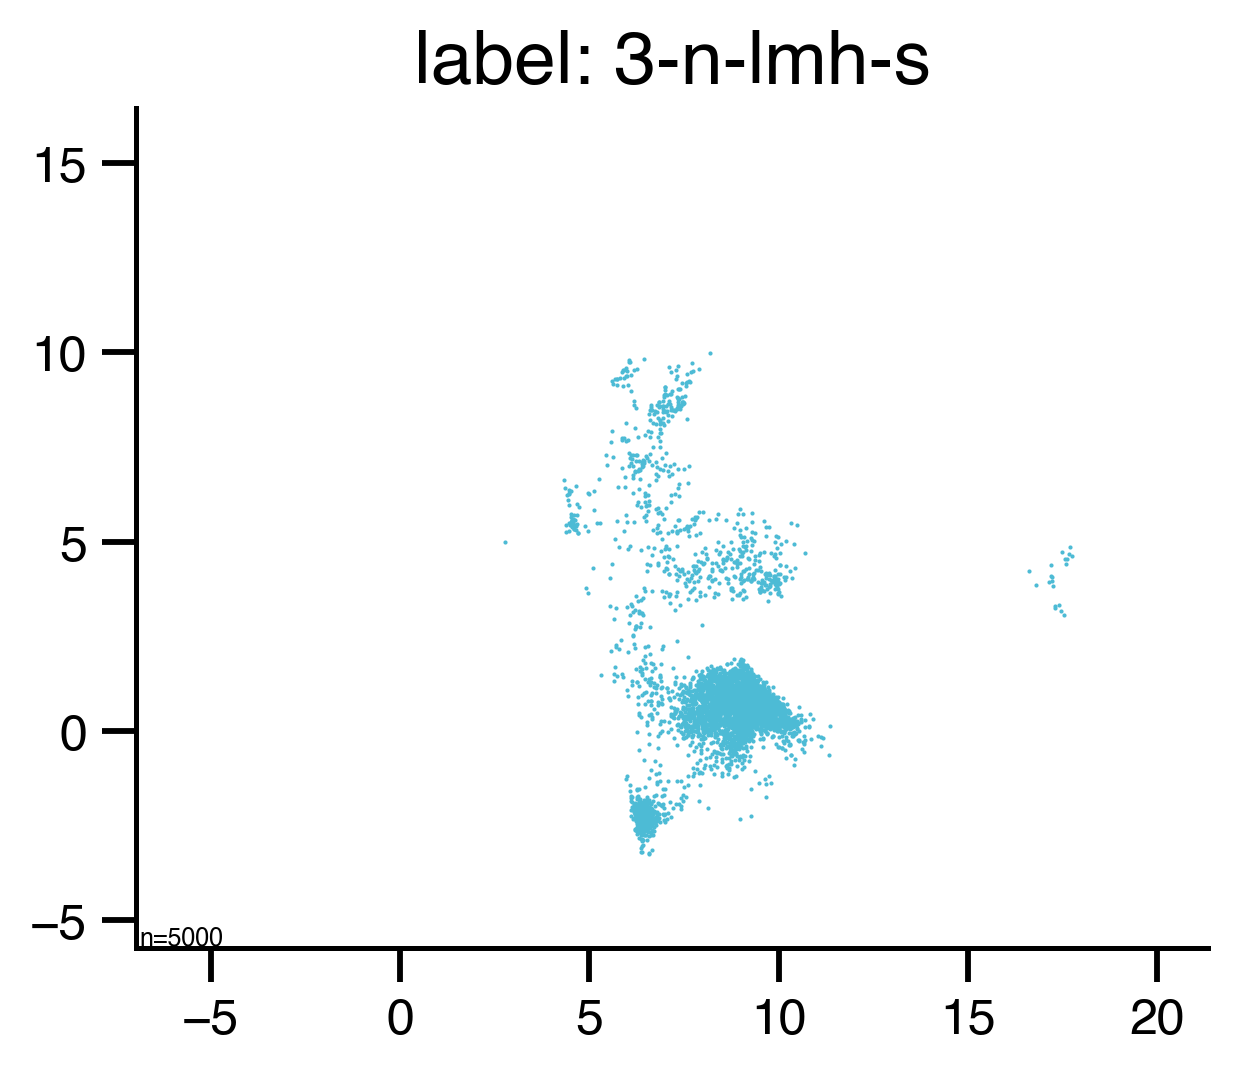

In [91]:
cutoff = np.quantile(perplexity_simulated, 1.0)
unique_labels = np.unique(simulated_label)
boundaries = collections.defaultdict(lambda: [])
counter = 0
for l in sorted(unique_labels, key=lambda s: int([*re.findall(string=s, pattern='\d+'), '0'][0])):
    idx = (simulated_label == l)
    z = reducer.transform(simulated_embedding[idx, :])
    with plt.style.context(spstyle.get_style('nature-reviews')):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color']
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
        s = ax.scatter(z[:, 0], z[:, 1], s=1, color=color[counter % len(color)], alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_simulated, 0.01), vmax=np.quantile(perplexity_simulated, 0.99))
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.set_xlim([np.min(umap_embedding[:, 0]) - 2, np.max(umap_embedding[:, 0]) + 2])
        ax.set_ylim([np.min(umap_embedding[:, 1]) - 2, np.max(umap_embedding[:, 1]) + 2])
        ax.set_aspect('equal')
        plt.title(f'label: {l}')
        ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 6})
        # fig.colorbar(s, ax=ax)
        # plt.savefig(f'figures/atlas_{l}.svg', transparent=True, dpi=120)
        plt.show()
        plt.close()
        counter += 1

In [92]:
simulated_label_short = np.array([s[:4] for s in simulated_label])

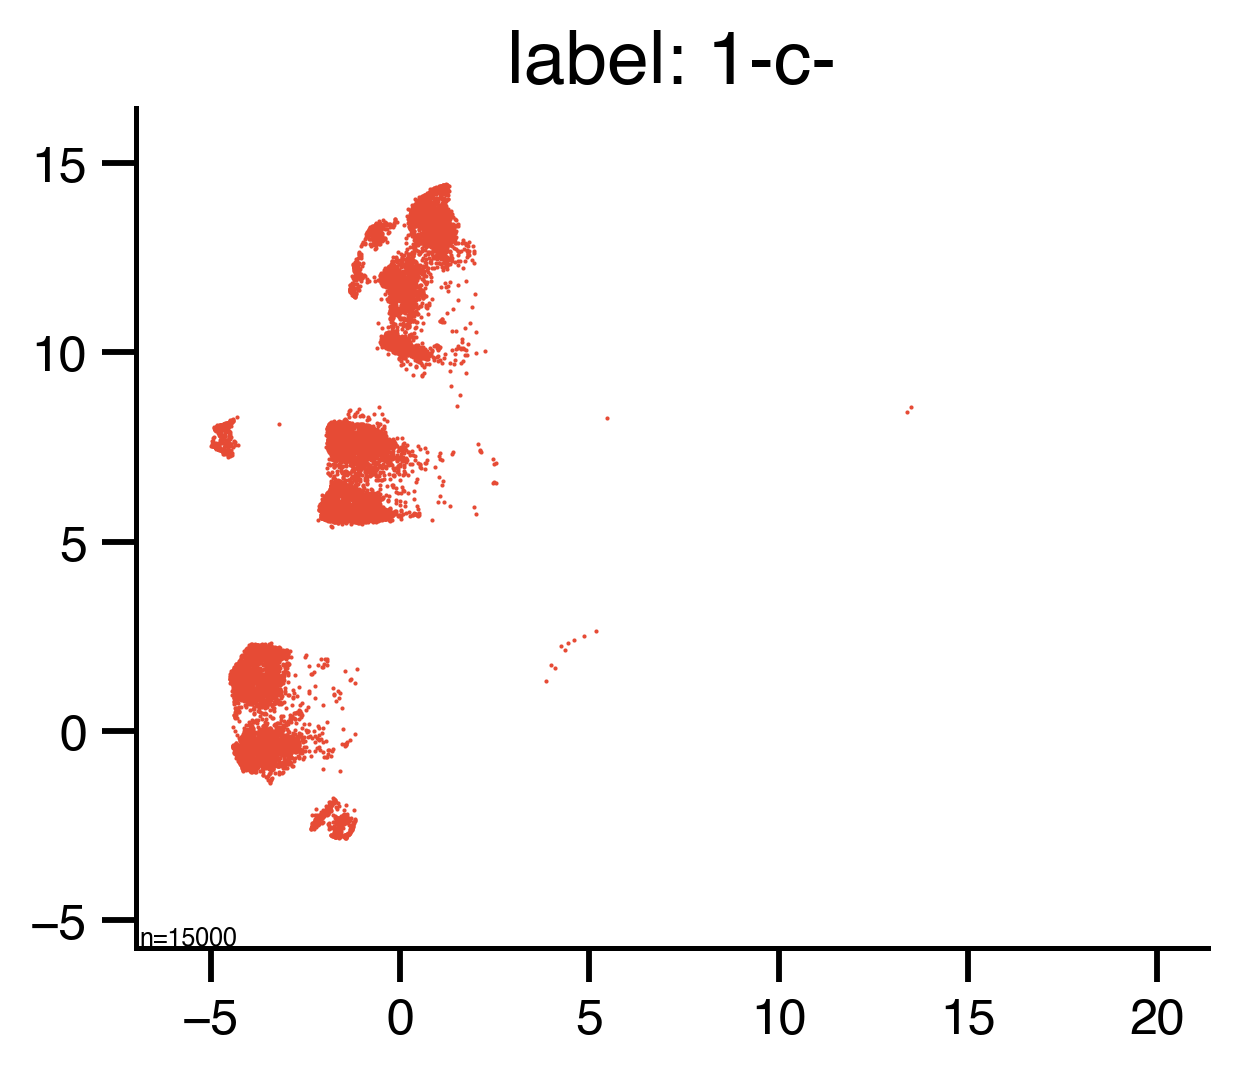

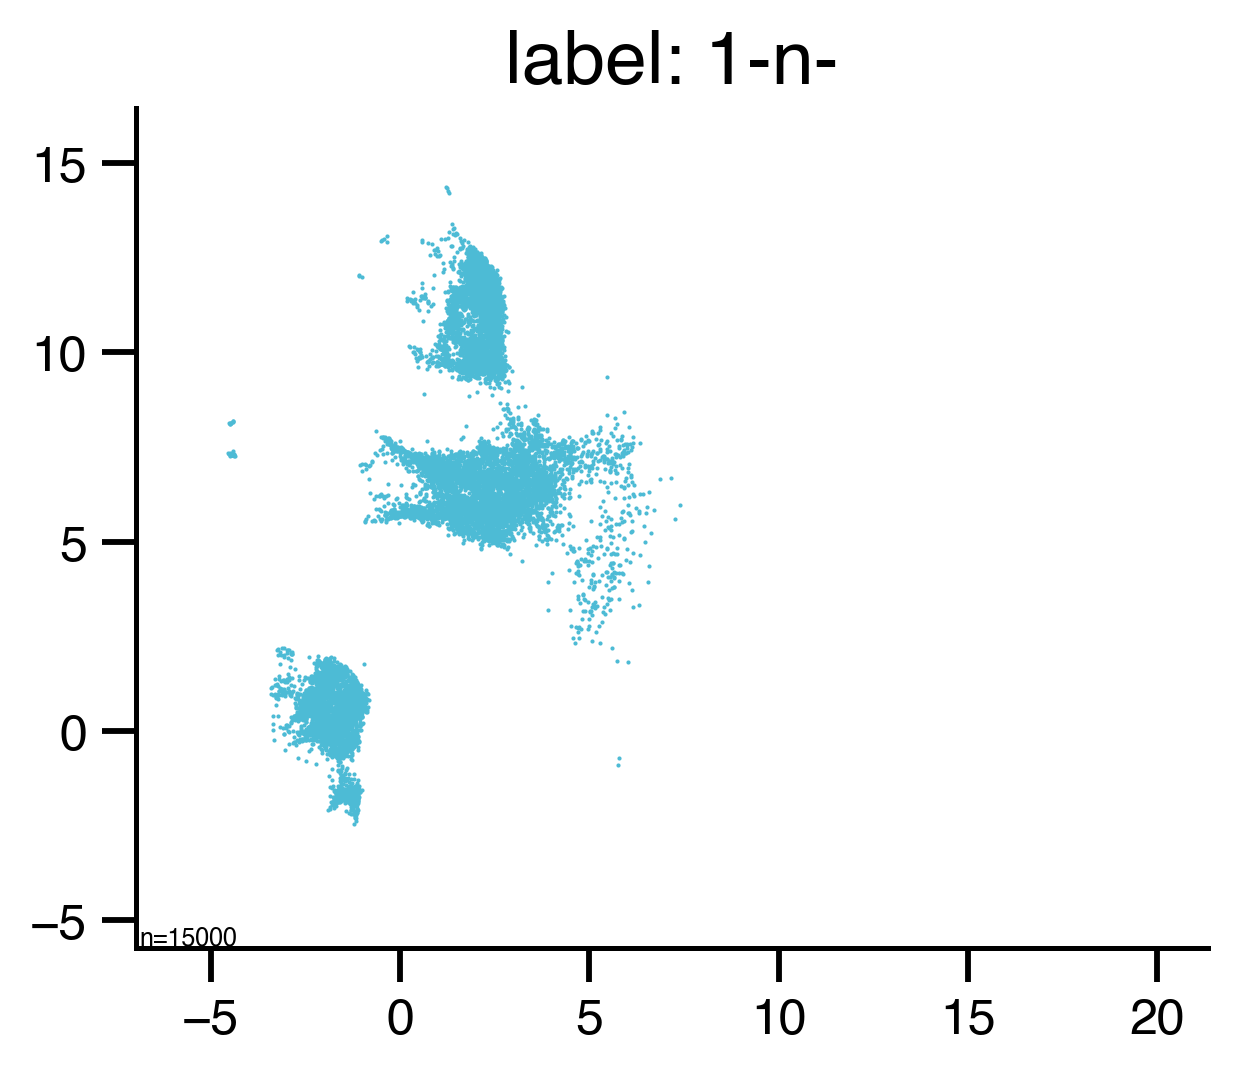

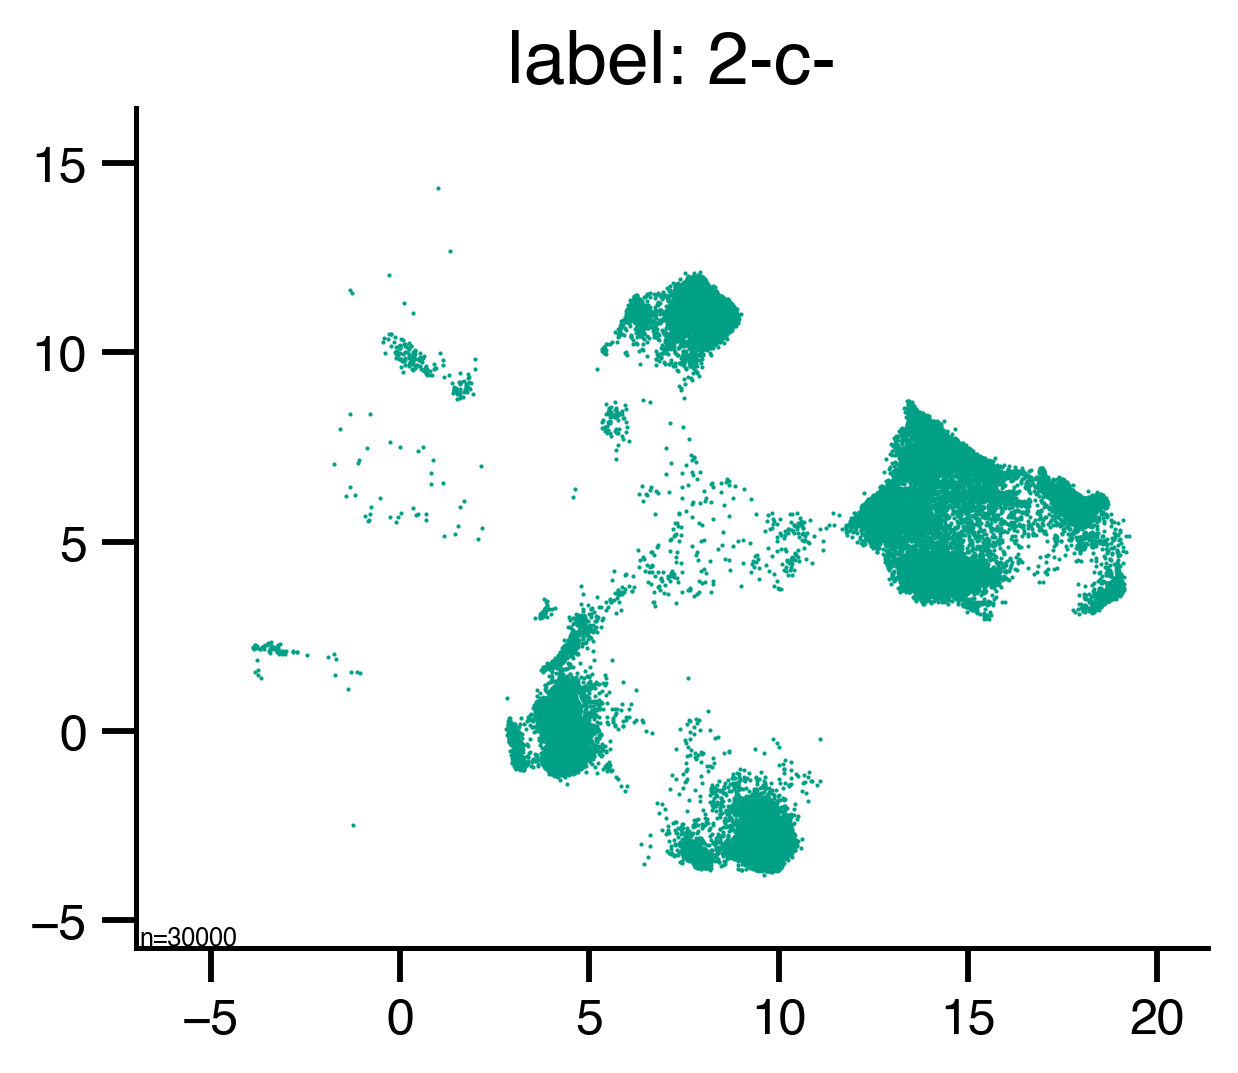

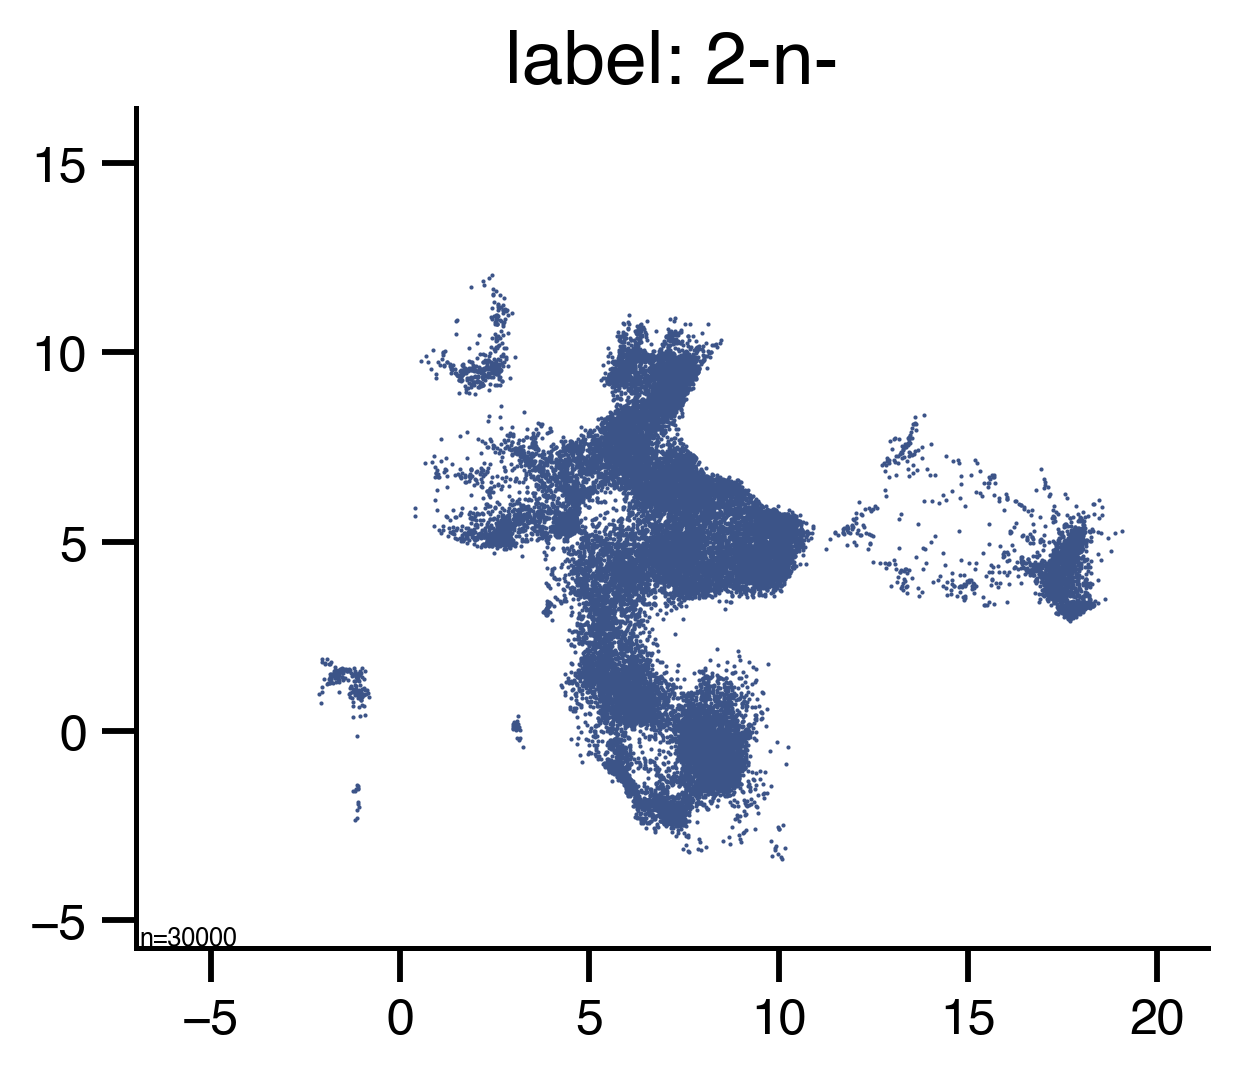

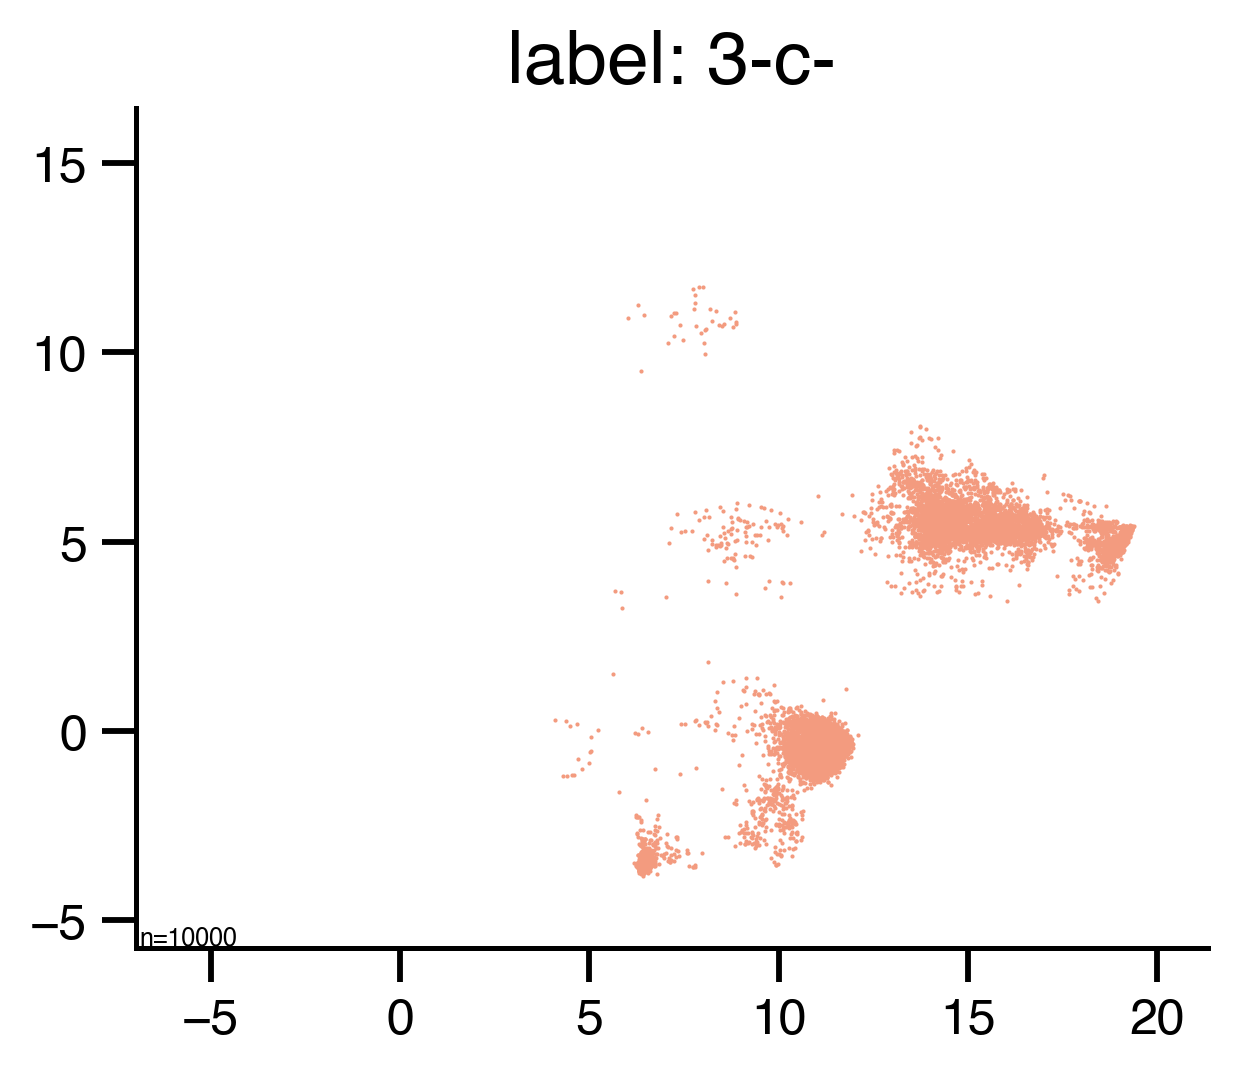

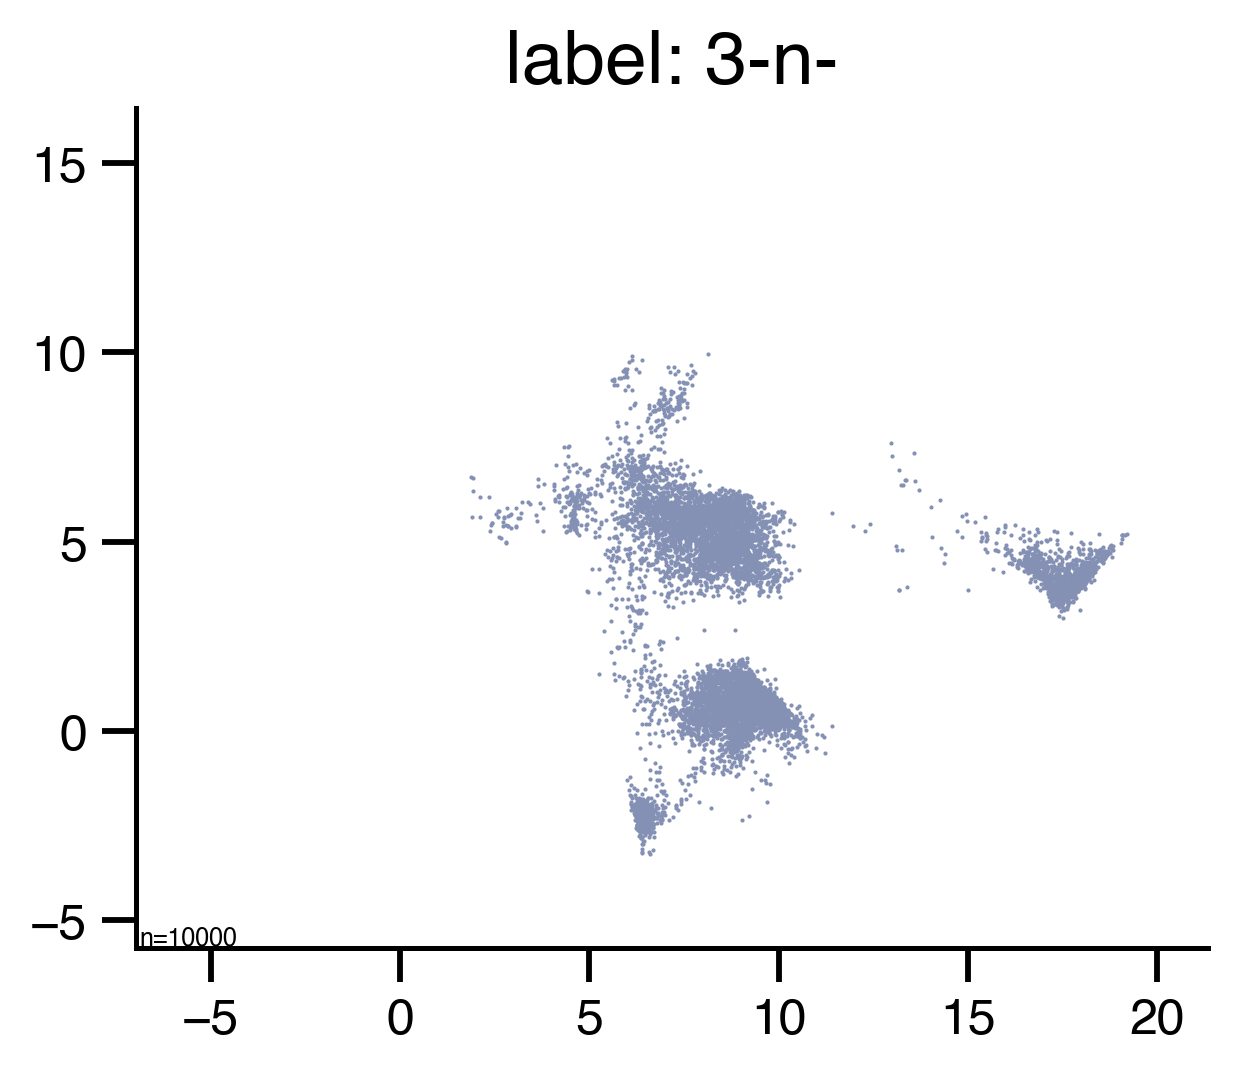

In [93]:
cutoff = np.quantile(perplexity_simulated, 1.0)
unique_labels = np.unique(simulated_label_short)
boundaries = collections.defaultdict(lambda: [])
counter = 0
for l in sorted(unique_labels, key=lambda s: int([*re.findall(string=s, pattern='\d+'), '0'][0])):
    idx = (simulated_label_short == l)
    z = reducer.transform(simulated_embedding[idx, :])
    with plt.style.context(spstyle.get_style('nature-reviews')):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color']
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
        s = ax.scatter(z[:, 0], z[:, 1], s=1, color=color[counter % len(color)], alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_simulated, 0.01), vmax=np.quantile(perplexity_simulated, 0.99))
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.set_xlim([np.min(umap_embedding[:, 0]) - 2, np.max(umap_embedding[:, 0]) + 2])
        ax.set_ylim([np.min(umap_embedding[:, 1]) - 2, np.max(umap_embedding[:, 1]) + 2])
        ax.set_aspect('equal')
        plt.title(f'label: {l}')
        ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 6})
        # fig.colorbar(s, ax=ax)
        plt.savefig(f'figures/atlas_{l}.png', transparent=True, dpi=120)
        plt.show()
        plt.close()
        counter += 1

In [49]:
# Manuscript's order: 'DNA Walker', 'DNA Swinging Arm', 'PreQ 1', 'Transcriptional Complex', 'RiboSwitch'

run_config = [
    {
        "config_file": 'experiment_conditions/cond4.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/dna_walker/',
    },
    {
        "config_file": 'experiment_conditions/cond2.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/dna_swinging_arm/',
    },
    {
        "config_file": 'experiment_conditions/cond5.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/preQ_1/',
    },
    {
        "config_file": 'experiment_conditions/cond3.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/transcriptional_complex/',
    },
    {
        "config_file": 'experiment_conditions/cond1.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/riboswitch/',
    },
]

In [50]:
embeddings_global = []
labels_global = []
trace_sets_global = []
for run in run_config: 
    config_file = run['config_file']
    with open(config_file) as f:
        config = json.load(f)
    trace_sets = [MatlabTraceSet(file) for file in config['expt_setting_set_files'].strip().split('\n')]
    trace_sets = [e for e in trace_sets if e.is_labeled]
    embeddings, labels = generate_embedding_and_label(trace_sets, config['start_frame'], encoder, max_frame=2000, max_traces=20000, balance_labels=True)
    embeddings_global.extend(embeddings)
    labels_global.extend(labels)
    trace_sets_global.extend(trace_sets)

945
3/3 [==============================] - 0s 46ms/step
830
3/3 [==============================] - 0s 41ms/step
818
5/5 [==============================] - 0s 50ms/step
821
5/5 [==============================] - 0s 49ms/step
662
3/3 [==============================] - 0s 49ms/step
948
2/2 [==============================] - 0s 58ms/step
773
7/7 [==============================] - 0s 54ms/step
594
3/3 [==============================] - 0s 54ms/step
669
3/3 [==============================] - 0s 63ms/step
748
3/3 [==============================] - 0s 50ms/step
767
3/3 [==============================] - 0s 42ms/step
596
6/6 [==============================] - 0s 61ms/step
837
8/8 [==============================] - 0s 62ms/step
768
7/7 [==============================] - 0s 58ms/step
771
7/7 [==============================] - 0s 57ms/step
753
5/5 [==============================] - 0s 69ms/step
626
7/7 [==============================] - 0s 58ms/step
607
7/7 [==============================] - 0s 65

In [51]:
final_embeddings = []
final_labels = []
human_labels = []
for e, t, l in zip(embeddings_global, trace_sets_global, labels_global):
    for run in run_config: 
        config_file = run['config_file']
        with open(config_file) as f:
            config = json.load(f)
        if t.file in config['expt_setting_set_files']:
            final_labels.append([config_file] * e.shape[0])
            print(config_file)
            break
    final_embeddings.append(e)
    human_labels.append(l)
embedding = np.concatenate(final_embeddings, axis=0)
label = np.concatenate(final_labels)
human_label = np.concatenate(human_labels)

experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond4.json
experiment_conditions/cond2.json
experiment_conditions/cond2.json
experiment_conditions/cond2.json
experiment_conditions/cond2.json
experiment_conditions/cond5.json
experiment_conditions/cond5.json
experiment_conditions/cond5.json
experiment_conditions/cond5.json
experiment_conditions/cond5.json
experiment_conditions/cond5.json
experiment

In [52]:
embedding.shape, label.shape, set(label)

((12245, 96),
 (12245,),
 {'experiment_conditions/cond1.json',
  'experiment_conditions/cond2.json',
  'experiment_conditions/cond3.json',
  'experiment_conditions/cond4.json',
  'experiment_conditions/cond5.json'})

In [53]:
embedding.shape

(12245, 96)

In [54]:
# perplexity = get_perplexity(embedding, label, branching_factor=50)
perplexity = np.zeros(embedding.shape[0])

(array([    0.,     0.,     0.,     0.,     0., 12245.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

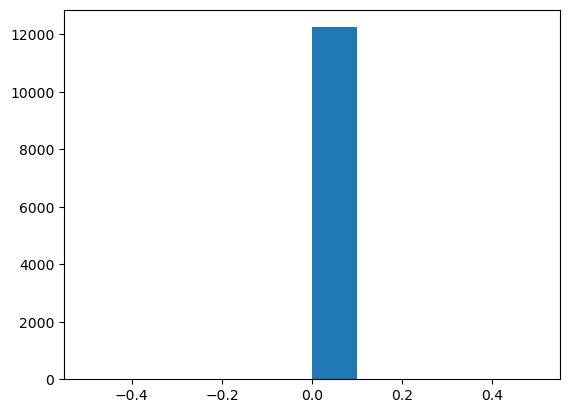

In [55]:
plt.hist(perplexity)

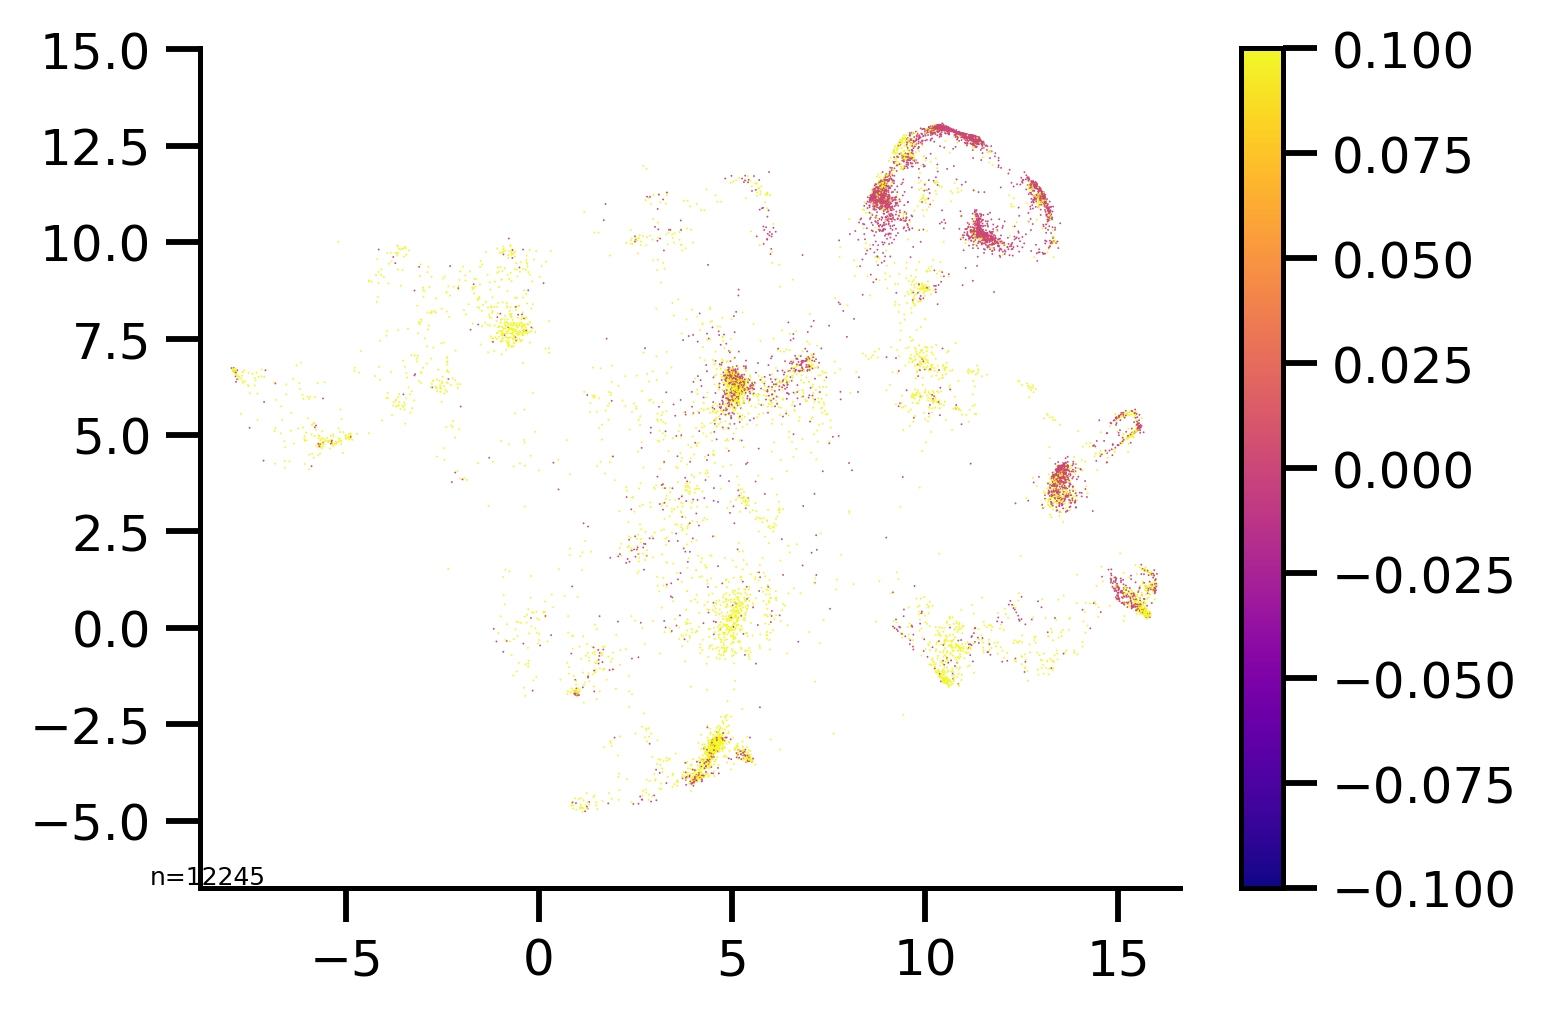

In [60]:
# z = reducer.transform(embedding)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
    s = ax.scatter(z[:, 0], z[:, 1], c=0.5 * human_label, s=0.2, alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity, 0.01), vmax=np.quantile(perplexity, 0.99))
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_xlim([np.min(umap_embedding[:, 0]) - 2, np.max(umap_embedding[:, 0]) + 2])
    ax.set_ylim([np.min(umap_embedding[:, 1]) - 2, np.max(umap_embedding[:, 1]) + 2])
    ax.set_aspect('equal', 'datalim')
    ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 6})
    fig.colorbar(s, ax=ax)

In [57]:
# Export to the embedding projector

def trim(x, precision=4):
    """Trims a float to a given precision."""
    if int(x) == x:
        return x
    else:
        return float(np.format_float_positional(x, precision=4, unique=False, fractional=False, trim='k'))

def generate_projector_data(log_dir, embedding, trace_set, plot_label, predicted_label, k_means_label, sprite=False):
    Path(log_dir).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
      f.write('name\tground truth\tpredicted label\tk-means-clustering\tdonor\tacceptor\n')
      for index in range(embedding.shape[0]):
        donor = np.array([trim(x) for x in trace_set.traces[index].donor])
        acceptor = np.array([trim(x) for x in trace_set.traces[index].acceptor])
        f.write(f"trace {index}\t{plot_label[index]}\t{predicted_label[index]}\t{k_means_label[index]}\t{json.dumps(donor.tolist())}\t{json.dumps(acceptor.tolist())}\n")
    with open(log_dir + 'tensor.bytes', 'wb') as f:
        f.write(np.array(tf.cast(embedding, tf.float32)).tobytes())
    np.savetxt(log_dir + 'tensor.tsv', embedding, delimiter='\t')

def generate_tensor_and_metadata(trace_sets, start_frame, output_dir, encoder, reducer, max_size=4000, max_frame=2000, balance_label=True, logistic_regression=True, class_weight=None):
    """Generates the files for embedding projector."""

    embeddings = []
    labels = []
    colors = []
    color_count = 1
    image_files = []
    traces = []
    
    count = 0
    for trace_set in trace_sets:
        trim_size = len(trace_set.time) // 100 * 100
        trace_set.trim(trim_size)
        trace_set.trim(max_frame, start_frame=start_frame)
        trace_set.broadcast_data_to_traces()
        print(trace_set.size)
        if balance_label:
          size = 2 * np.sum(np.max(trace_set.label, axis=-1))
        else:
          size = trace_set.size
        if count + size > max_size:
            break
        else:
            count += size
                
        with tf.device('/CPU:0'):
            embedding = reducer.transform(encoder.predict(trace_set.to_tensor()))
            embeddings.append(embedding)
            labels.append(np.max(trace_set.label, axis=-1))
            traces.extend(trace_set.traces)
    
    labels = np.concatenate(labels, axis=0)
    n_included = np.sum(labels == 1)
    n_excluded = np.sum(labels == 0)

    indices = np.arange(len(labels))
    if balance_label:
      ratio = int(n_excluded / n_included)
      if ratio > 1:
        indices = np.concatenate([indices[labels == 1], indices[labels ==0][::ratio]])
        labels = labels[indices]
    
    trace_set = FRETTraceSet()
    trace_set.traces = [traces[i] for i in indices]
    trace_set.size = len(trace_set.traces)
    embedding = np.concatenate(embeddings, axis=0)[indices, :]
    if np.max(labels) == 1:
        labels = np.where(labels == 1, 'Included in Analysis', 'Excluded from Analysis')
    kmeans_labels = cluster.KMeans(n_clusters=2).fit_predict(embedding)
    clf = LogisticRegression(random_state=0, max_iter=5000, class_weight=class_weight).fit(embedding, labels)
    predicted_label = clf.predict(embedding)
    # kmeans_labels = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True).fit_predict(clusterable_embedding)
    generate_projector_data(output_dir, embedding, trace_set, labels, predicted_label, kmeans_labels, sprite=False)

In [58]:
run_config = [
    {
        "config_file": 'experiment_conditions/cond1.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/riboswitch_atlas/',
    },
    {
        "config_file": 'experiment_conditions/cond2.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/dna_swinging_arm_atlas/',
    },
    {
        "config_file": 'experiment_conditions/cond3.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/transcriptional_complex_atlas/',
    },
    {
        "config_file": 'experiment_conditions/cond4.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/dna_walker_atlas/',
    },
    {
        "config_file": 'experiment_conditions/cond5.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/preQ_1_atlas/',
    }
]

In [111]:
reducer = joblib.load('saved_models/UMAP/atlas_pp.joblib')

In [112]:
for run in run_config:
    with open(run['config_file']) as f:
        config = json.load(f)
    trace_sets = [MatlabTraceSet(file) for file in config['expt_setting_set_files'].strip().split('\n')]
    generate_tensor_and_metadata(trace_sets, config['start_frame'], run['output_dir'], encoder, reducer)

488
16/16 [==============================] - 3s 166ms/step
493
16/16 [==============================] - 2s 116ms/step
522
17/17 [==============================] - 3s 164ms/step
542
17/17 [==============================] - 3s 171ms/step
430
14/14 [==============================] - 2s 163ms/step
496
16/16 [==============================] - 3s 163ms/step
496
16/16 [==============================] - 3s 161ms/step
400
13/13 [==============================] - 2s 165ms/step
390
13/13 [==============================] - 1s 71ms/step
345
11/11 [==============================] - 1s 84ms/step
363
12/12 [==============================] - 1s 115ms/step
427
14/14 [==============================] - 1s 69ms/step
381
12/12 [==============================] - 2s 164ms/step
424
14/14 [==============================] - 2s 156ms/step
537
17/17 [==============================] - 3s 174ms/step
468
15/15 [==============================] - 3s 189ms/step
457
15/15 [==============================] - 2s 164ms/step


In [68]:
config_file = 'experiment_conditions/cond_rna_bubble_all.json'
# config_file = 'experiment_conditions/cond_dna_walker_multiplexing.json'
# config_file = 'experiment_conditions/cond_preq1_good.json'
# config_file = 'experiment_conditions/cond_riboswitch_good.json'
# config_file = 'experiment_conditions/cond_rna_bubble_good.json'
with open(config_file) as f:
    config = json.load(f)
trace_sets_spot = [MatlabTraceSet(file) for file in config['expt_setting_set_files'].strip().split('\n')]
embeddings_spot, labels_spot = generate_embedding_and_label(trace_sets_spot, config['start_frame'], encoder, max_frame=2000, max_traces=20000, balance_labels=False)
# trace_sets_spot = [e for e in trace_sets_spot if e.is_labeled]

504
63/63 [==============================] - 3s 55ms/step
520
65/65 [==============================] - 3s 54ms/step
537
68/68 [==============================] - 4s 52ms/step
488
61/61 [==============================] - 3s 51ms/step
550
69/69 [==============================] - 4s 52ms/step
468
59/59 [==============================] - 3s 55ms/step
457
58/58 [==============================] - 3s 52ms/step
435
55/55 [==============================] - 3s 52ms/step
571
72/72 [==============================] - 4s 52ms/step
519
65/65 [==============================] - 3s 53ms/step
544
68/68 [==============================] - 4s 54ms/step
515
65/65 [==============================] - 3s 54ms/step
499
63/63 [==============================] - 3s 54ms/step
543
68/68 [==============================] - 4s 53ms/step
441
56/56 [==============================] - 3s 52ms/step
454
57/57 [==============================] - 3s 51ms/step
464
58/58 [==============================] - 3s 51ms/step
422
53/53 [===

In [97]:
def get_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(3000, activation='relu'),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dense(10, activation='sigmoid')    
    ])
    model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [102]:
%%time

with tf.device('/GPU:0'):
    model = get_model()
    a = model(tf.random.uniform(shape=(100000, 32, 32, 3)))

CPU times: user 29.7 ms, sys: 45.4 ms, total: 75.2 ms
Wall time: 748 ms


In [94]:
final_embeddings = []
final_labels = []
human_labels = []
for e, t, l in zip(embeddings_spot, trace_sets_spot, labels_spot):
    print(t.file)
    final_labels.append([t.file.split('/')[-2]] * e.shape[0])
    final_embeddings.append(e)
    human_labels.append(l)
embedding_spot = np.concatenate(final_embeddings, axis=0)
label_spot = np.concatenate(final_labels)
human_label_spot = np.concatenate(human_labels)

embedding_spot = principal_projection(embedding_spot, projection_matrices, PRINCIPAL_DIMENTIONS)

../traces/RNA_bubble/M50mMKCl/RNA0-bubble_M50mMKCl-2.mltraces
../traces/RNA_bubble/M50mMKCl/RNA0-bubble_M50mMKCl-3.mltraces
../traces/RNA_bubble/M100mMKCl/RNA0-bubble_M100mMKCl-2.mltraces
../traces/RNA_bubble/M100mMKCl/RNA0-bubble_M100mMKCl-3.mltraces
../traces/RNA_bubble/M100mMKCl/RNA0-bubble_M100mMKCl.mltraces
../traces/RNA_bubble/M200mMKCl/RNA0-bubble_M200mMKCl-2.mltraces
../traces/RNA_bubble/M200mMKCl/RNA0-bubble_M200mMKCl-3.mltraces
../traces/RNA_bubble/M200mMKCl/RNA0-bubble_M200mMKCl.mltraces
../traces/RNA_bubble/M300mMKCl/RNA0-bubble_M300mMKCl-2.mltraces
../traces/RNA_bubble/M300mMKCl/RNA0-bubble_M300mMKCl-3.mltraces
../traces/RNA_bubble/M300mMKCl/RNA0-bubble_M300mMKCl.mltraces
../traces/RNA_bubble/M400mMKCl/RNA0-bubble_M400mMKCl-2.mltraces
../traces/RNA_bubble/M400mMKCl/RNA0-bubble_M400mMKCl-3.mltraces
../traces/RNA_bubble/M400mMKCl/RNA0-bubble_M400mMKCl.mltraces
../traces/RNA_bubble/M500mMKCl/RNA0-bubble_M500mMKCl-2.mltraces
../traces/RNA_bubble/M500mMKCl/RNA0-bubble_M500mMKCl

In [95]:
perplexity_spot = get_perplexity(embedding_spot, label_spot, branching_factor=50)

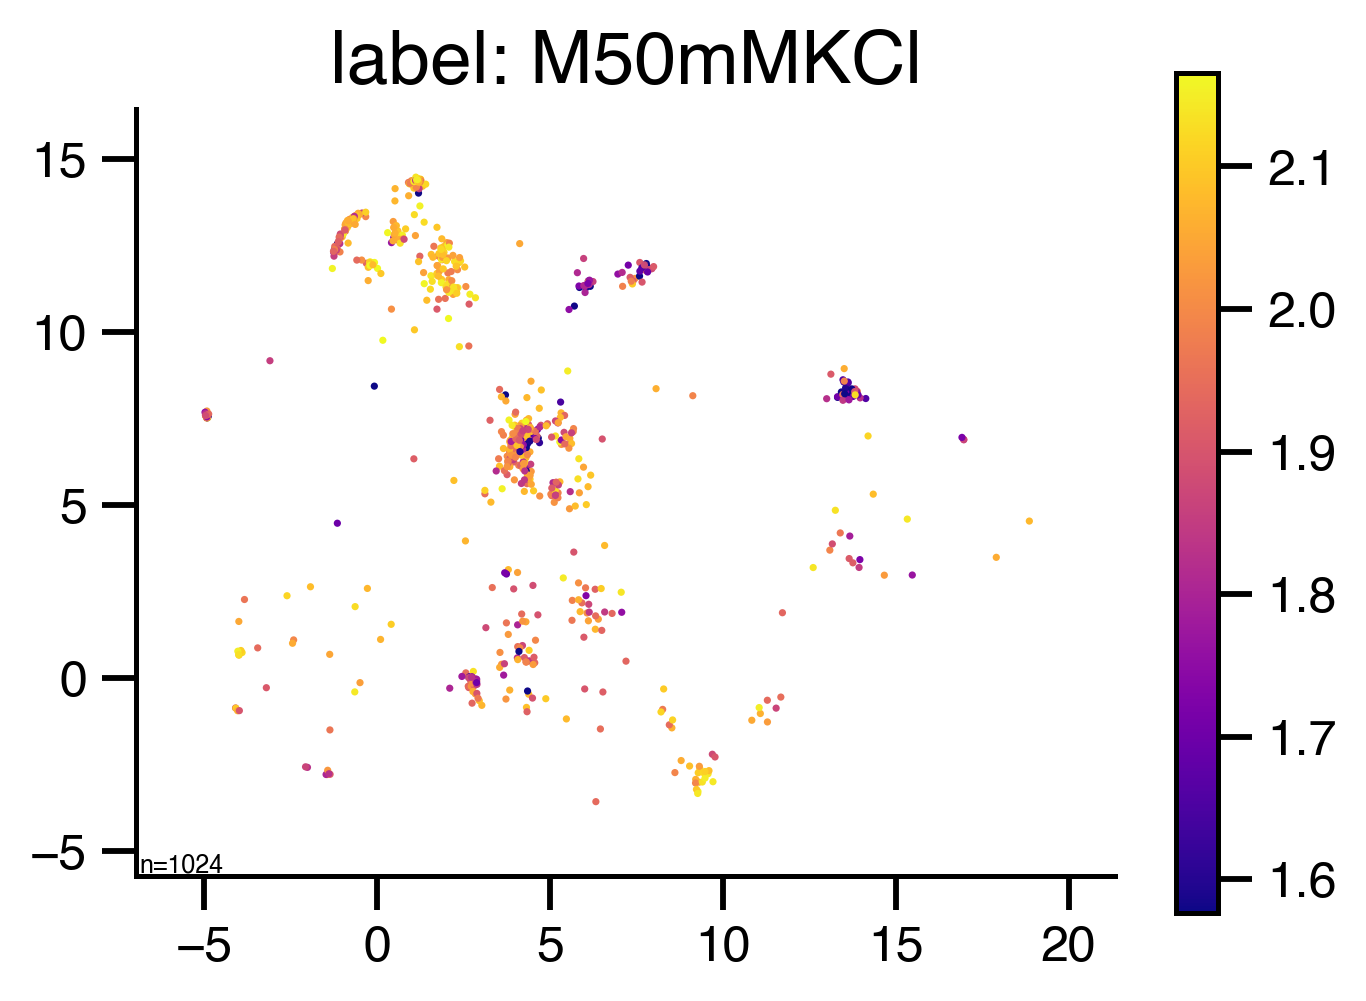

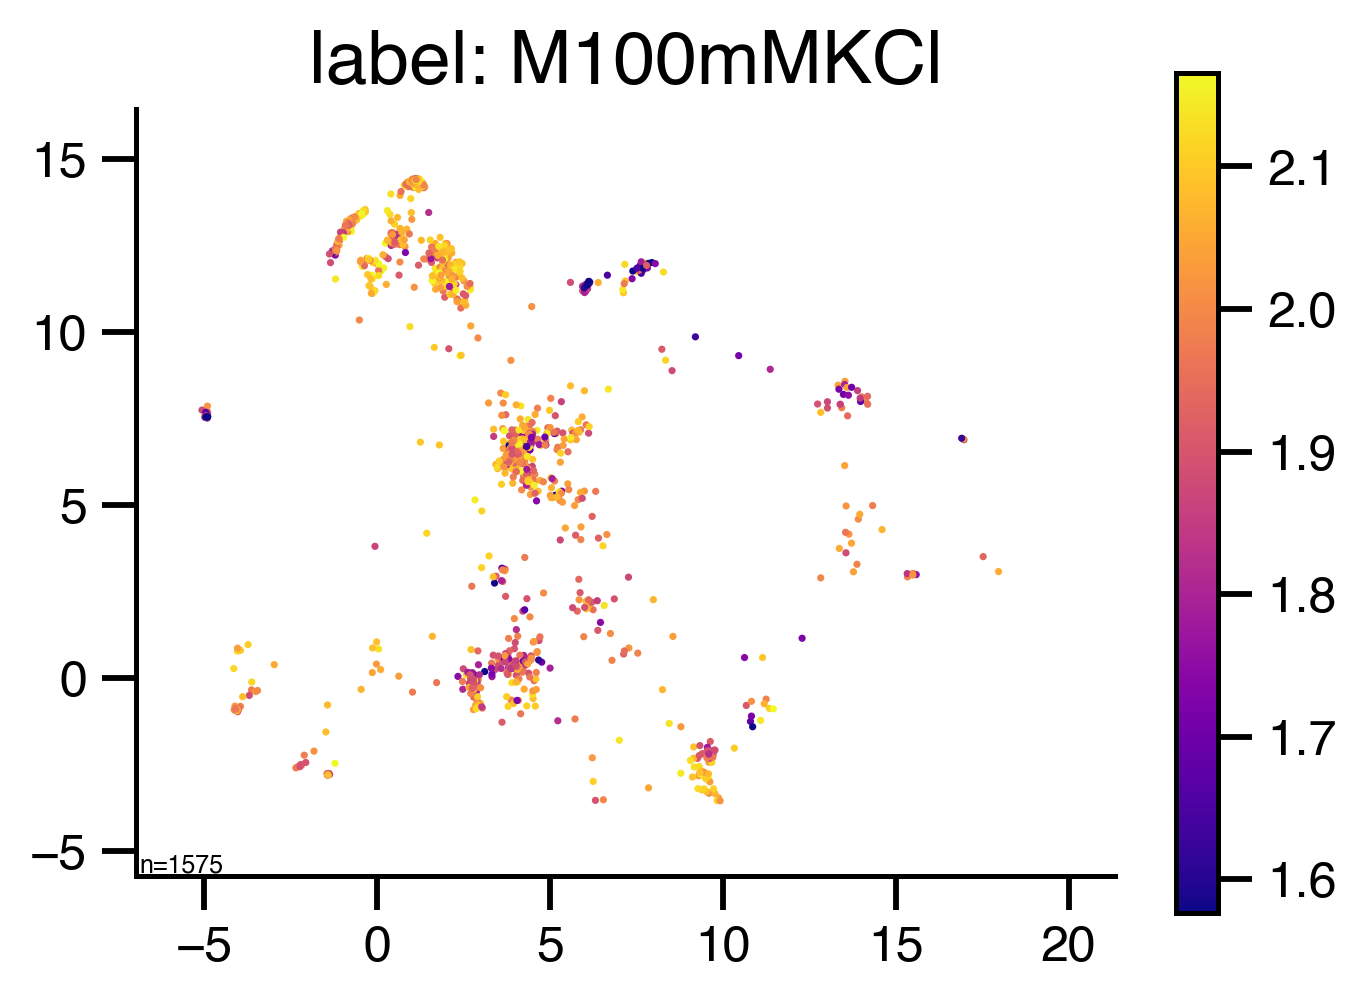

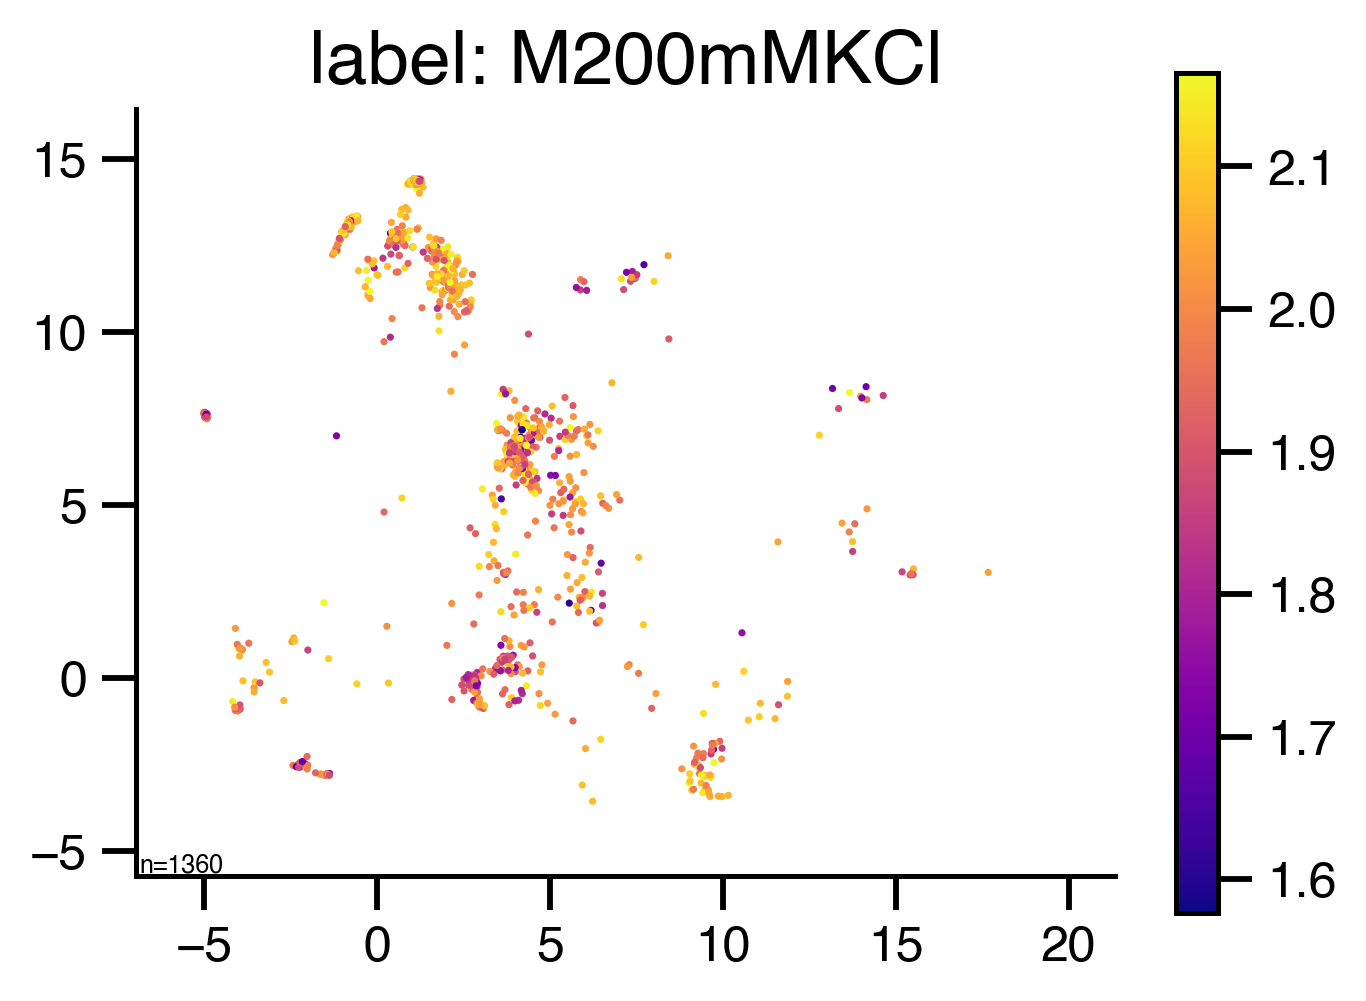

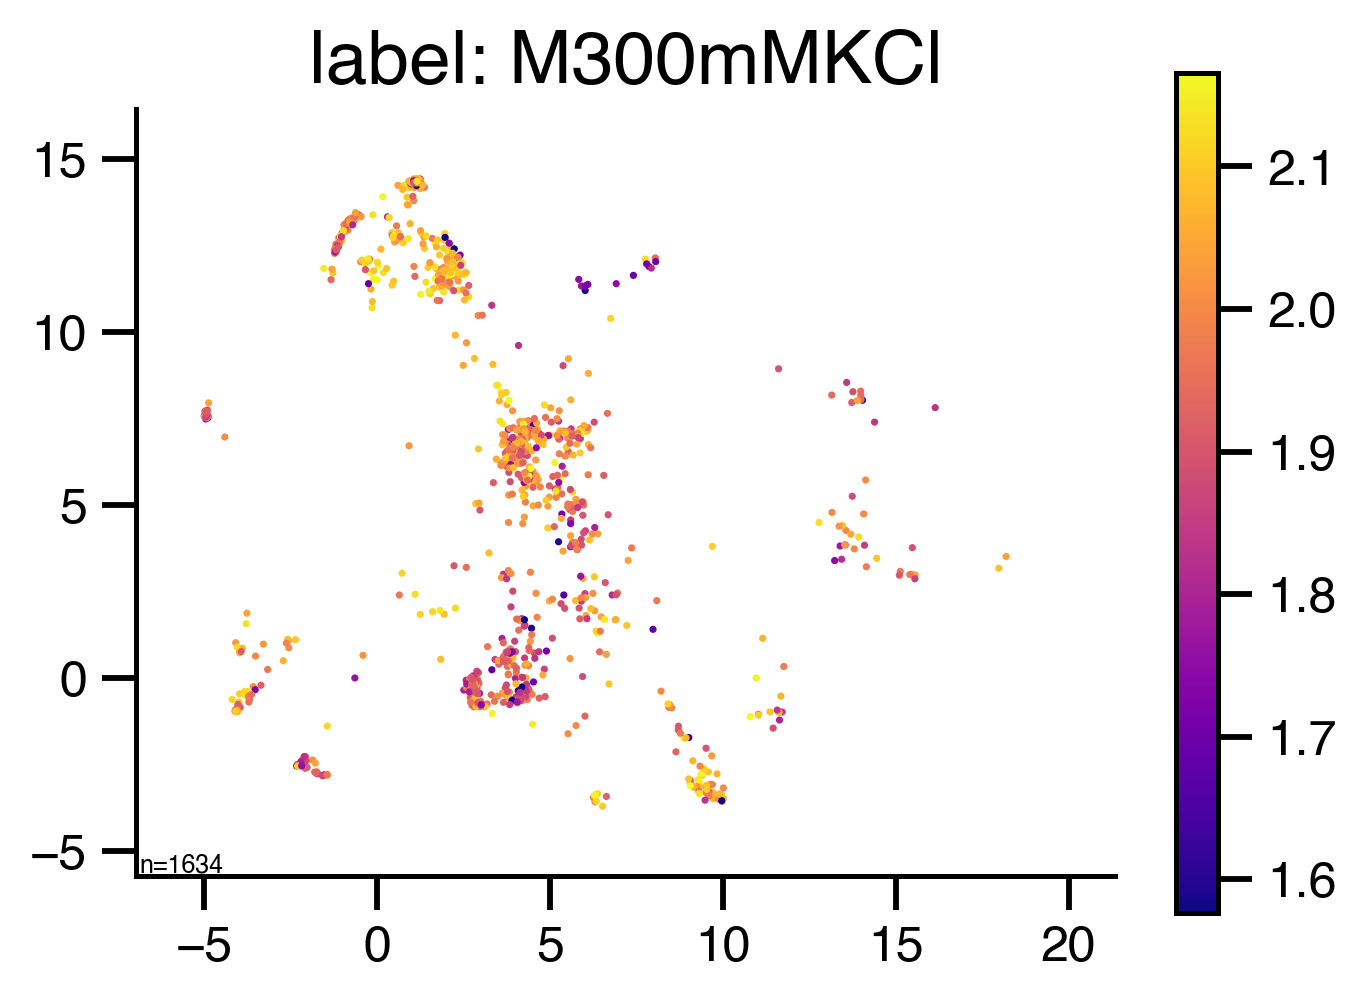

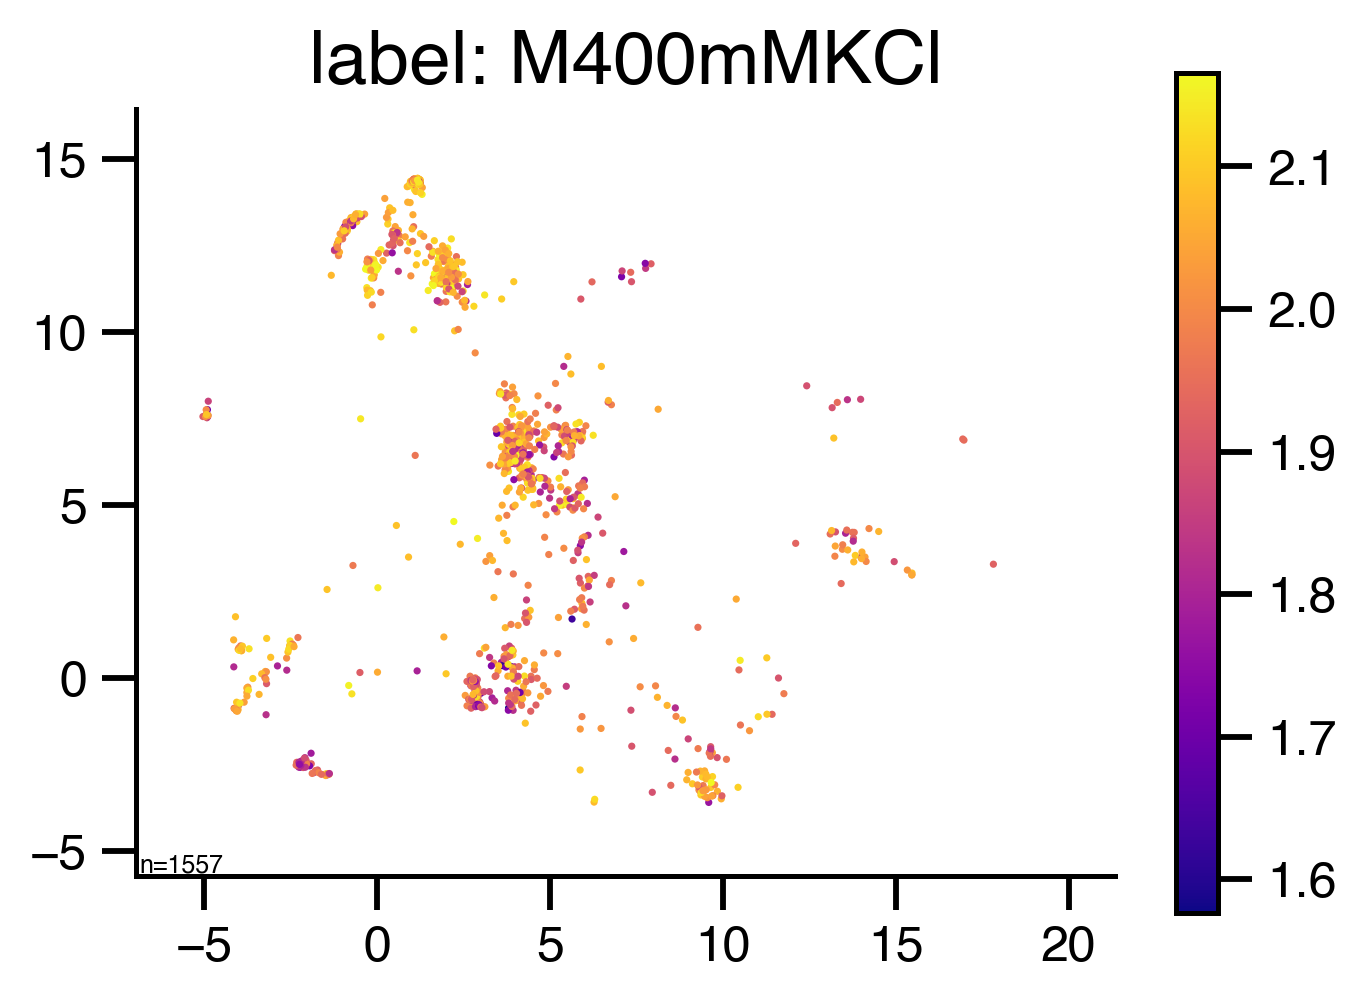

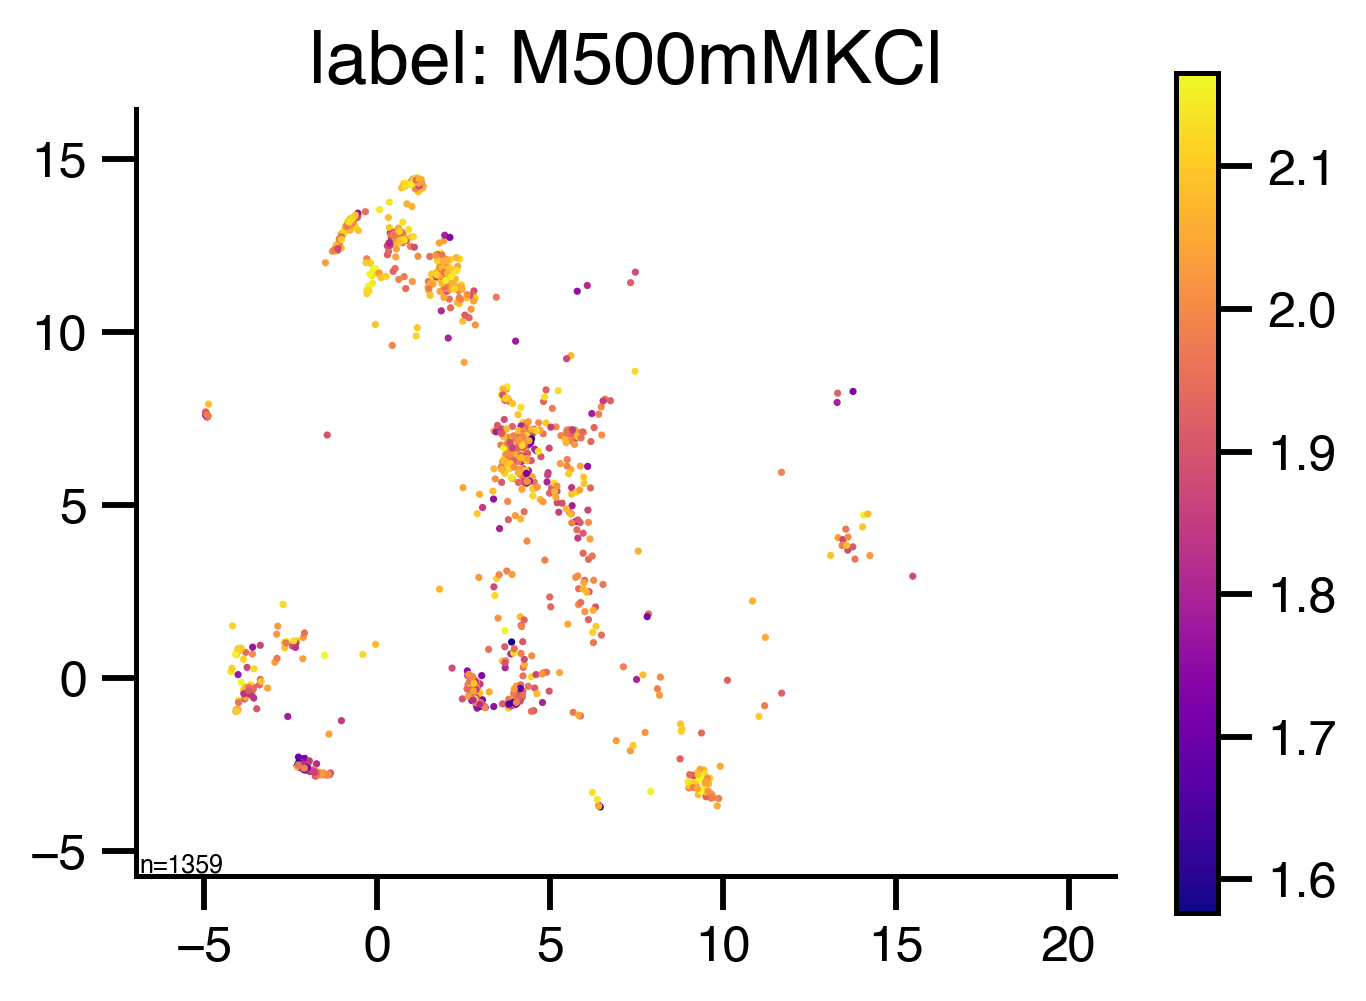

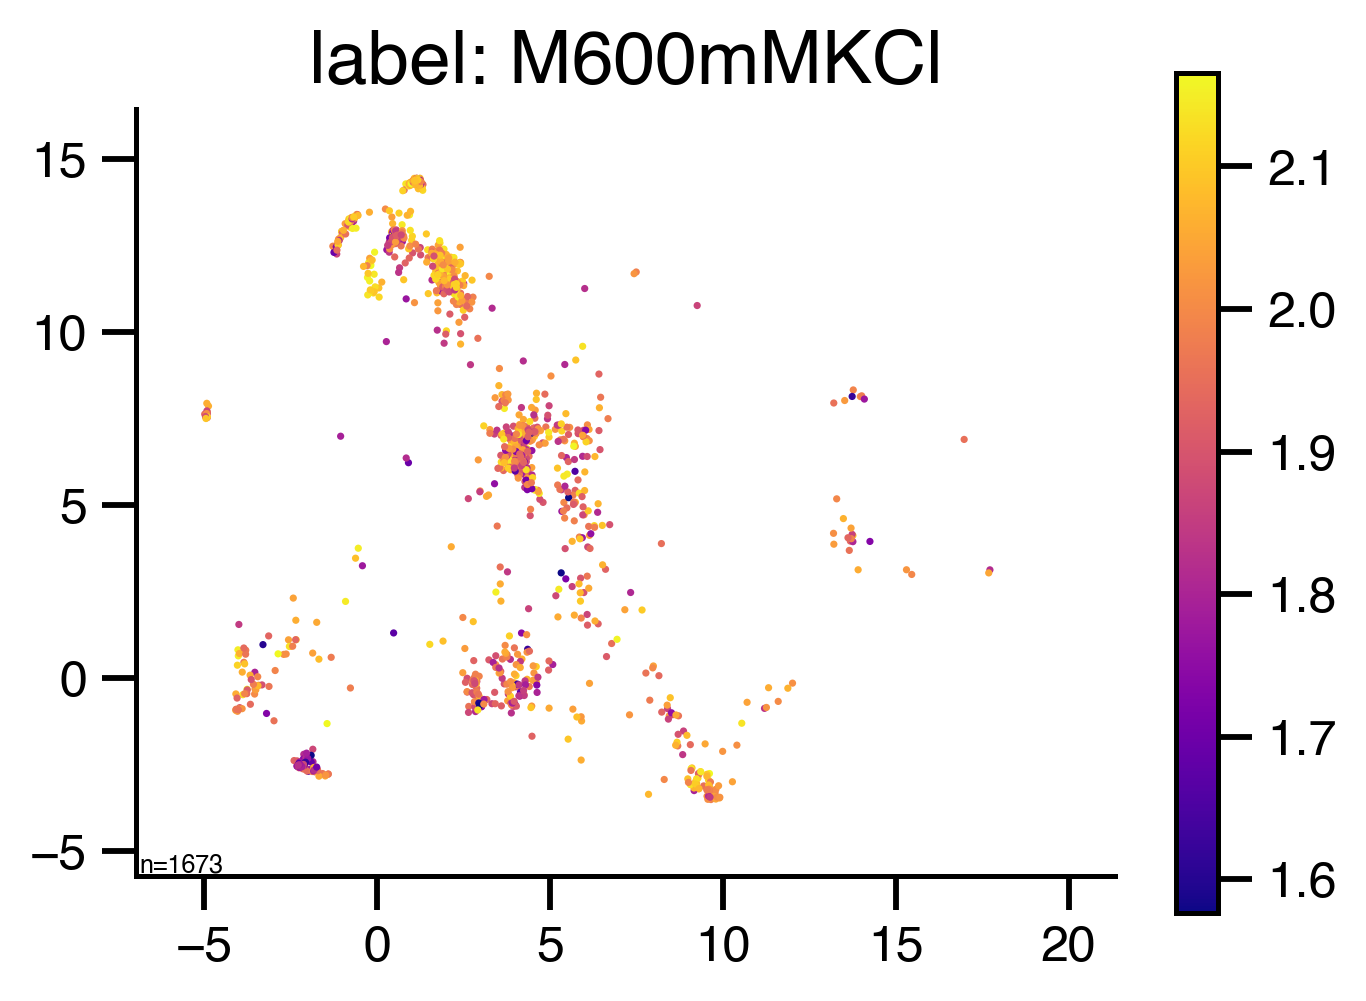

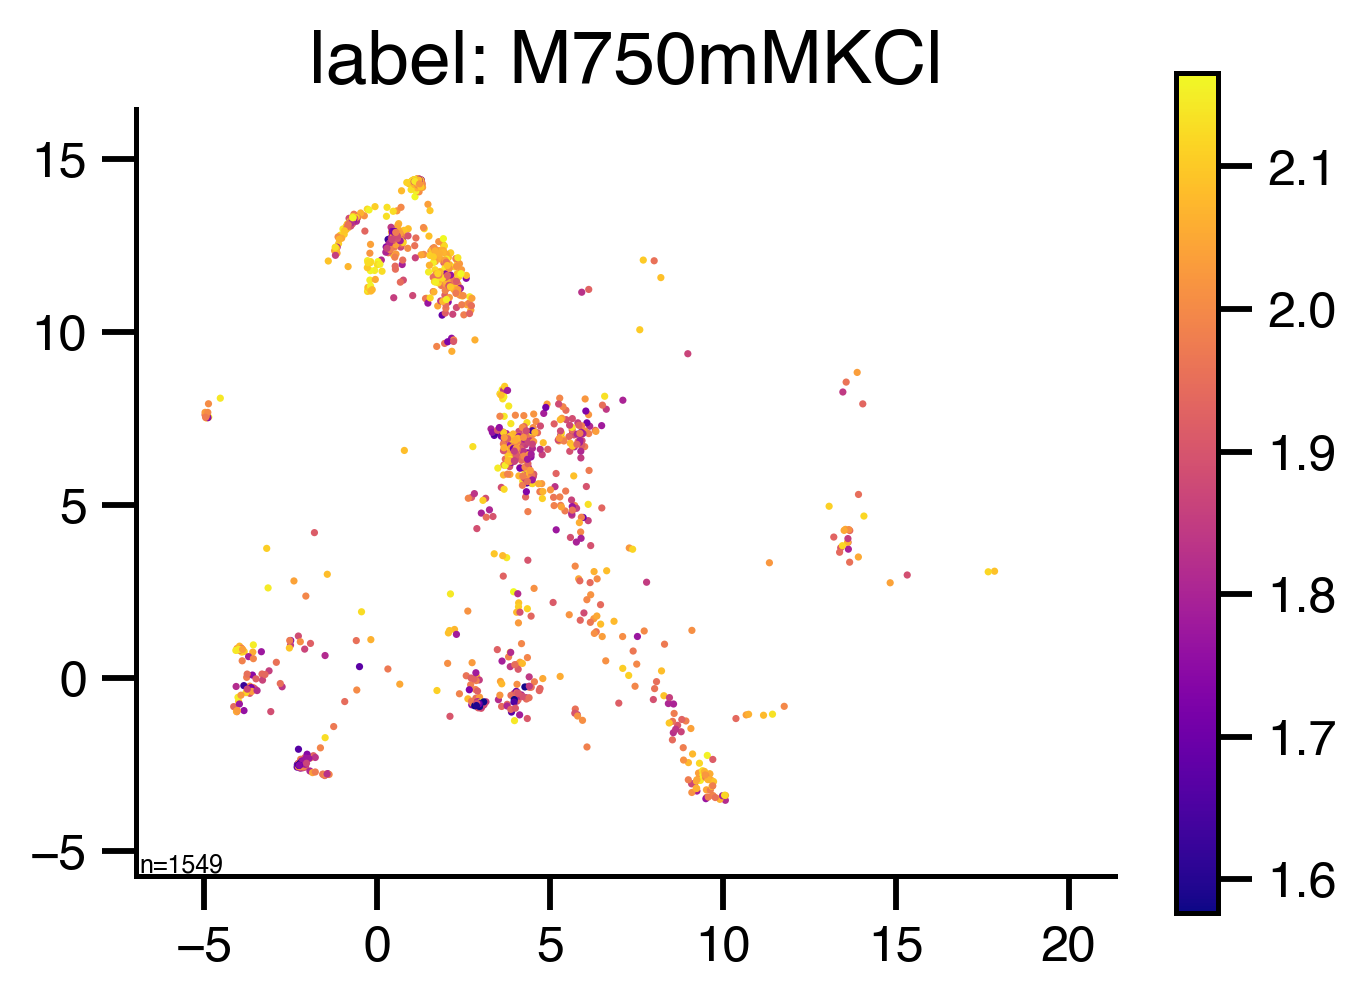

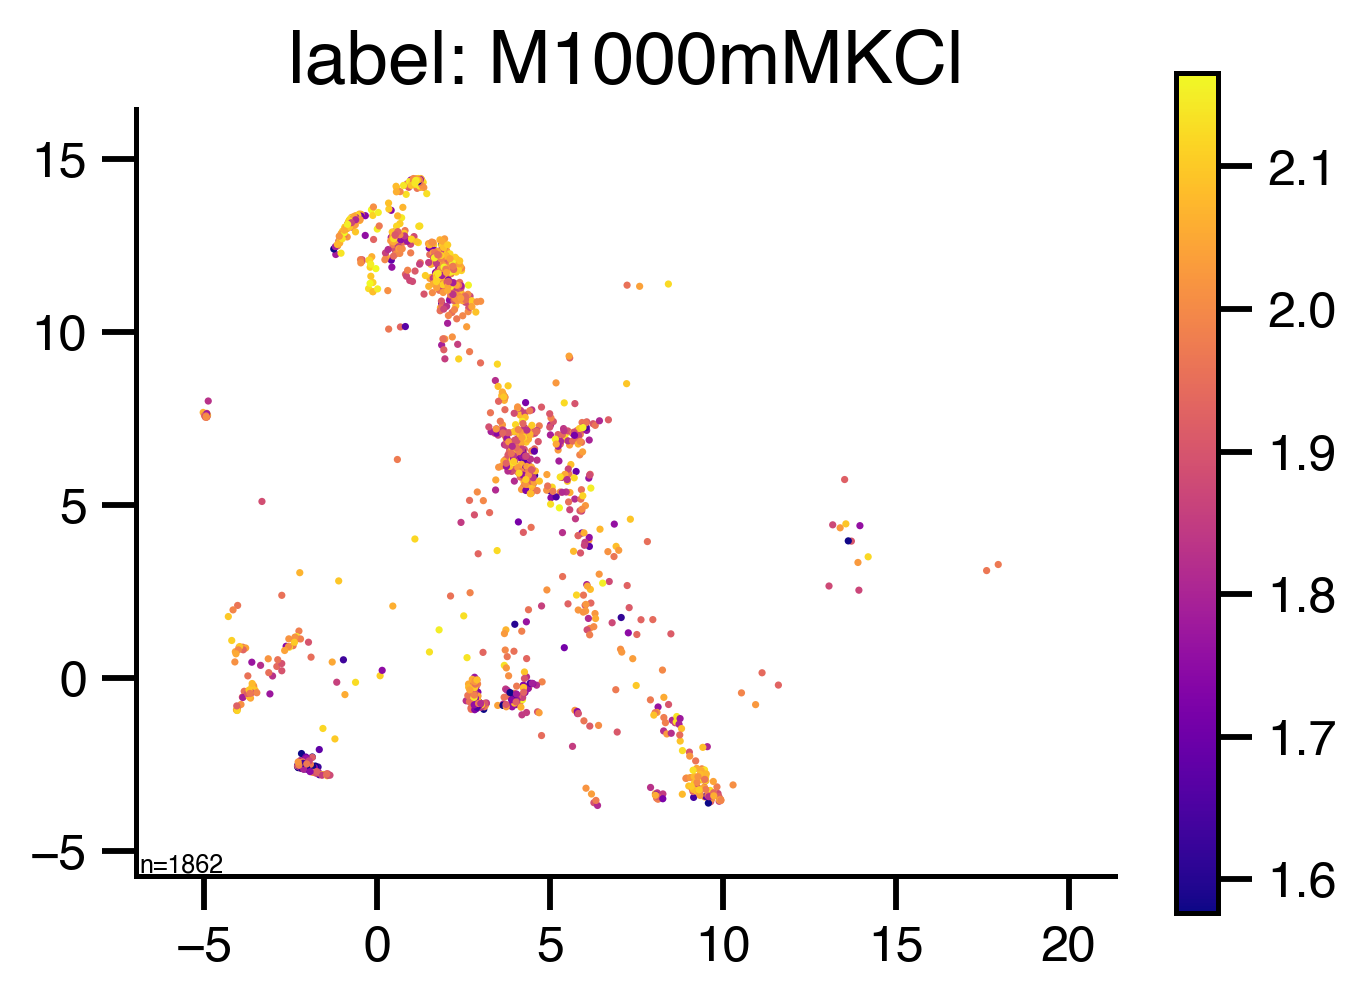

In [96]:
n = len(set(label_spot.tolist()))
cutoff = np.quantile(perplexity_spot, 1.0)
for l in sorted(list(set(label_spot.tolist())), key=lambda s: int(re.findall(string=s, pattern='\d+')[0])):
    idx = (label_spot == l)
    z = reducer.transform(embedding_spot[idx, :])
    with plt.style.context(spstyle.get_style('nature-reviews')):
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
        s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=3, alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        # ax.set_xticks([])
        ax.set_xlim([np.min(umap_embedding[:, 0]) - 2, np.max(umap_embedding[:, 0]) + 2])
        # ax.set_yticks([])
        ax.set_ylim([np.min(umap_embedding[:, 1]) - 2, np.max(umap_embedding[:, 1]) + 2])
        ax.set_aspect('equal')
        plt.title(f'label: {l}')
        ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 6})
        fig.colorbar(s, ax=ax)
        plt.savefig('figures/perplexity_umap_atlas_'+l+'_atlas.png')
        plt.show()

In [72]:
projection_matrices_file = '/Users/leyou/Desktop/Github/tensorboard-master/tensorboard/plugins/projector/vz_projector/principle_matrices.json'
with open(projection_matrices_file, 'r') as f:
    projection_matrices = json.load(f)

In [73]:
def principal_projection(tensor, projection_matrices, tasks):
    """Quantifies the relation between two tasks."""
    kernels = []
    for i, task in enumerate(projection_matrices['names']):
        if task in tasks:
            kernels.append(projection_matrices['kernels'][i])

    kernel = np.concatenate(kernels, axis=1)
    u, s, vh = np.linalg.svd(kernel, full_matrices=False, hermitian=False)
    effective_rank_fraction = 0.95
    effective_rank = u.shape[0]
    total_squared_sum = np.sum(s ** 2)
    squared_sum = 0
    for i in range(s.shape[0]):
        if squared_sum >= effective_rank_fraction * total_squared_sum:
            effective_rank = i
            break
        else:
            squared_sum += s[i] ** 2
    return np.matmul(tensor, u[:, :effective_rank])

In [75]:
PRINCIPAL_DIMENTIONS = ['Kinetic Rate', 'FRET State Number', 'FRET Value', 'Noise', 'Photobleaching Steps']
h = principal_projection(embedding, projection_matrices, PRINCIPAL_DIMENTIONS)
# perplexity = get_perplexity(h, label, branching_factor=50)

(array([1060.,  901., 1011., 1341., 2141., 2230., 2064., 1176.,  284.,
          37.]),
 array([0.        , 0.15391727, 0.30783454, 0.46175181, 0.61566909,
        0.76958636, 0.92350363, 1.0774209 , 1.23133817, 1.38525544,
        1.53917272]),
 <BarContainer object of 10 artists>)

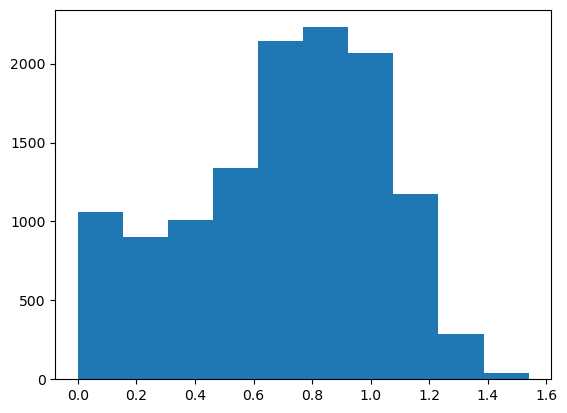

In [44]:
plt.hist(perplexity)

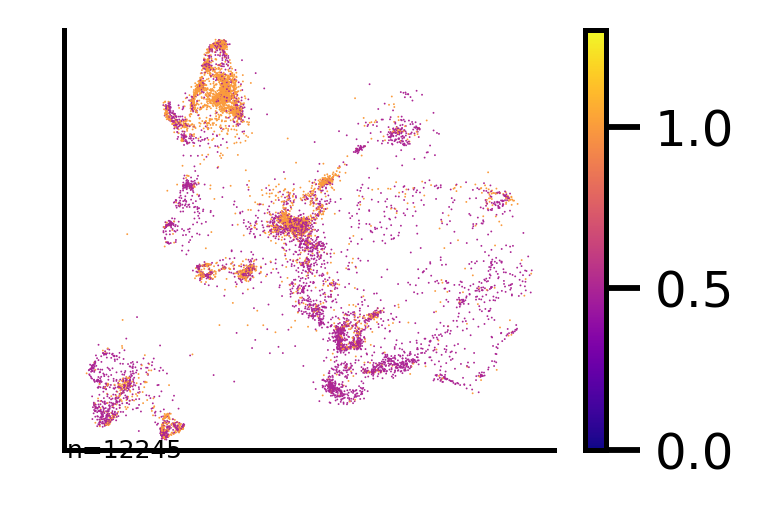

In [270]:
reducer = umap.UMAP(n_epochs=500, n_neighbors=30, min_dist=0.0, random_state=np.random.RandomState(60), n_components=2, negative_sample_rate=15)
umap_embedding = reducer.fit_transform(principal_projection(np.concatenate([simulated_embedding], axis=0), projection_matrices, PRINCIPAL_DIMENTIONS))
z = reducer.transform(h)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig = plt.figure(figsize=(3, 2))
    ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
    s = ax.scatter(z[:, 0], z[:, 1], c=np.ones_like(perplexity) - 0.5 * human_label, s=0.2, alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity, 0.01), vmax=np.quantile(perplexity, 0.99))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'datalim')
    ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 6})
    fig.colorbar(s, ax=ax)

/var/folders/fq/sqzffsld3xl8qrzw8772z5mh0000gn/T/ipykernel_45751/3800887007.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6, 4))


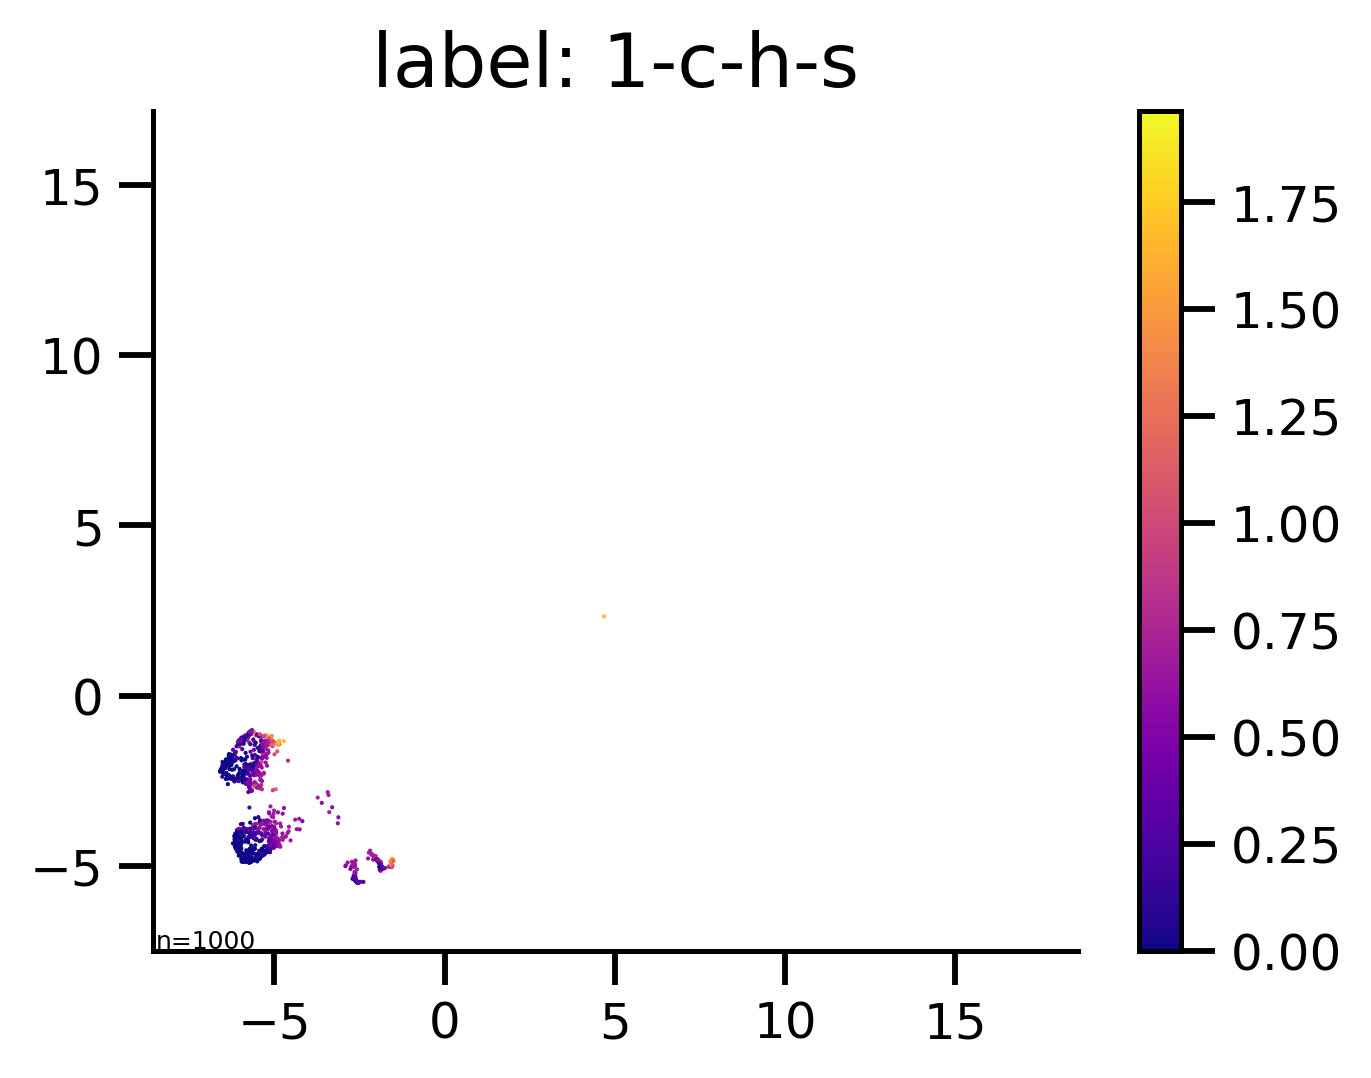

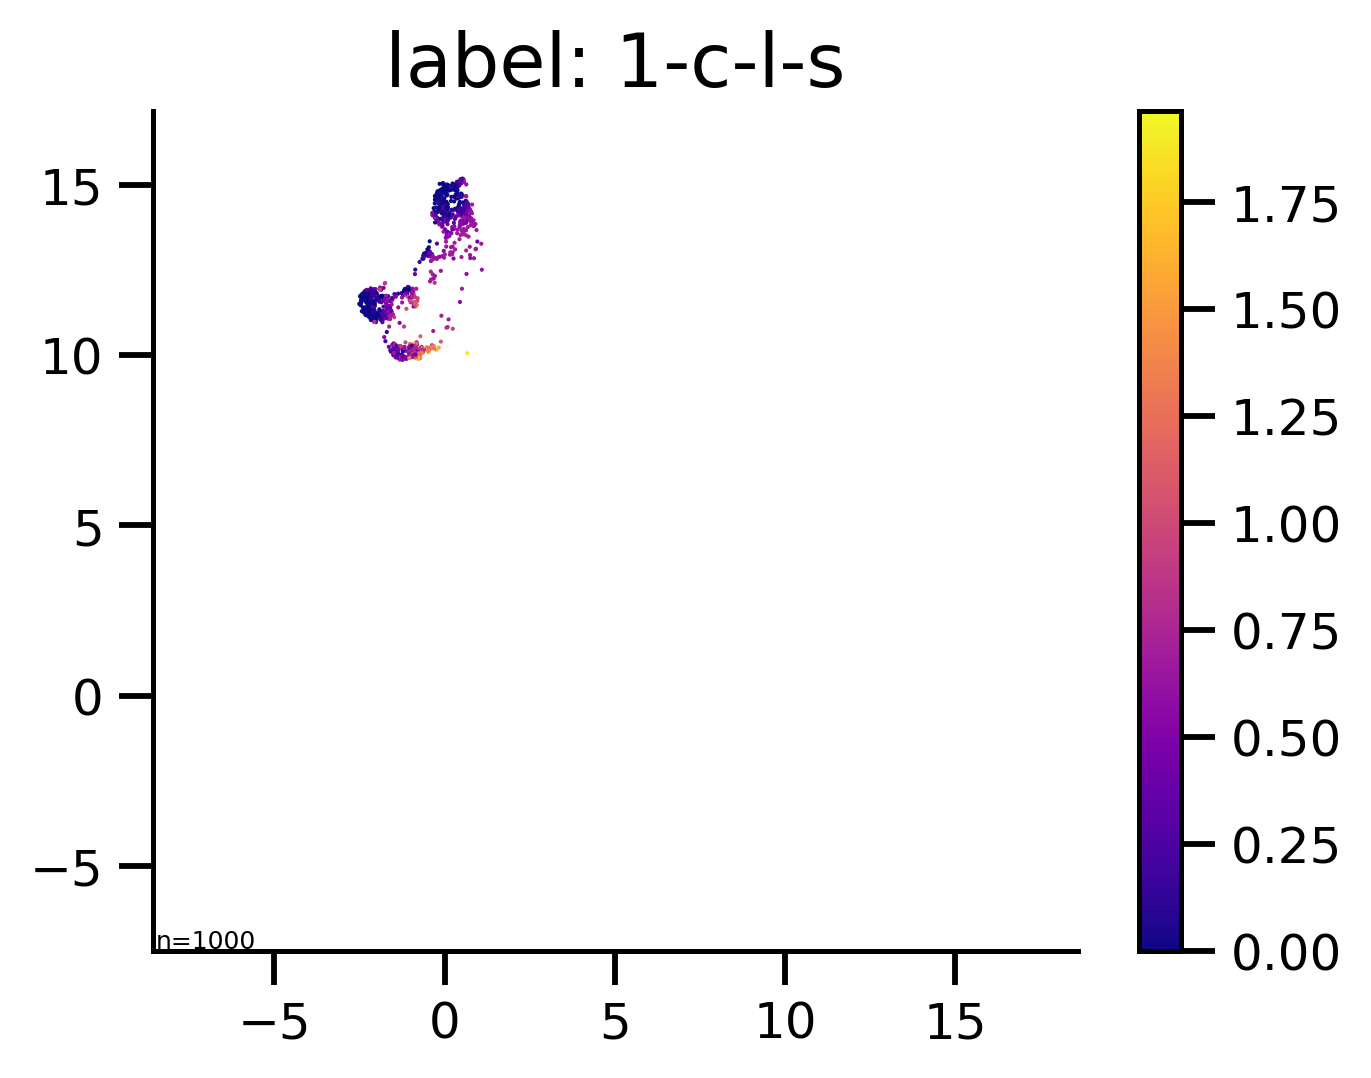

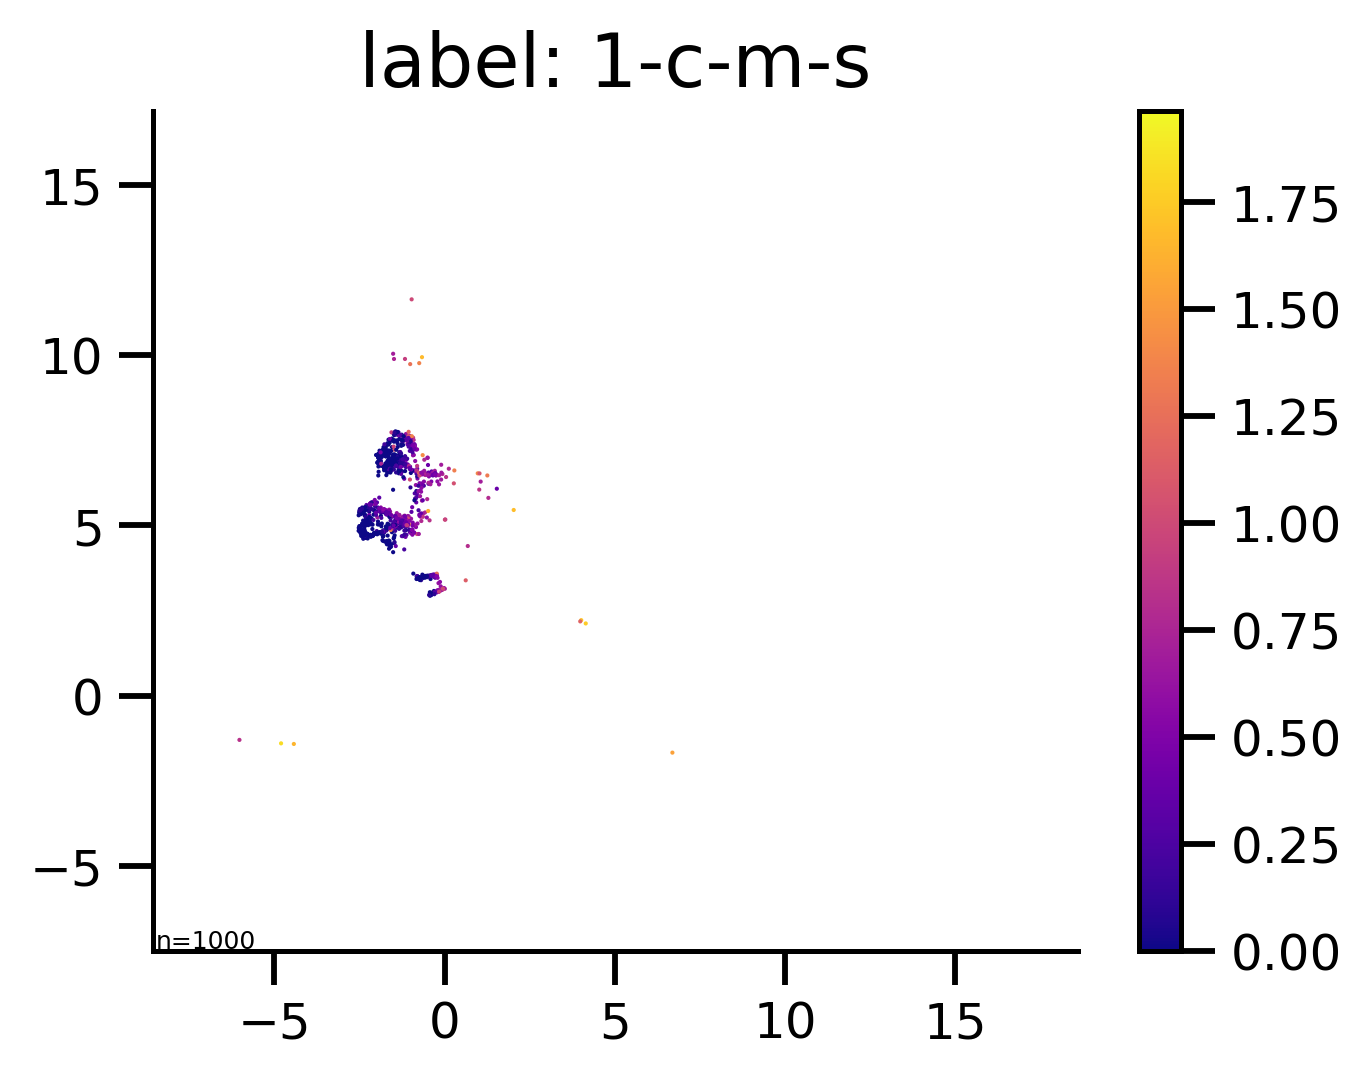

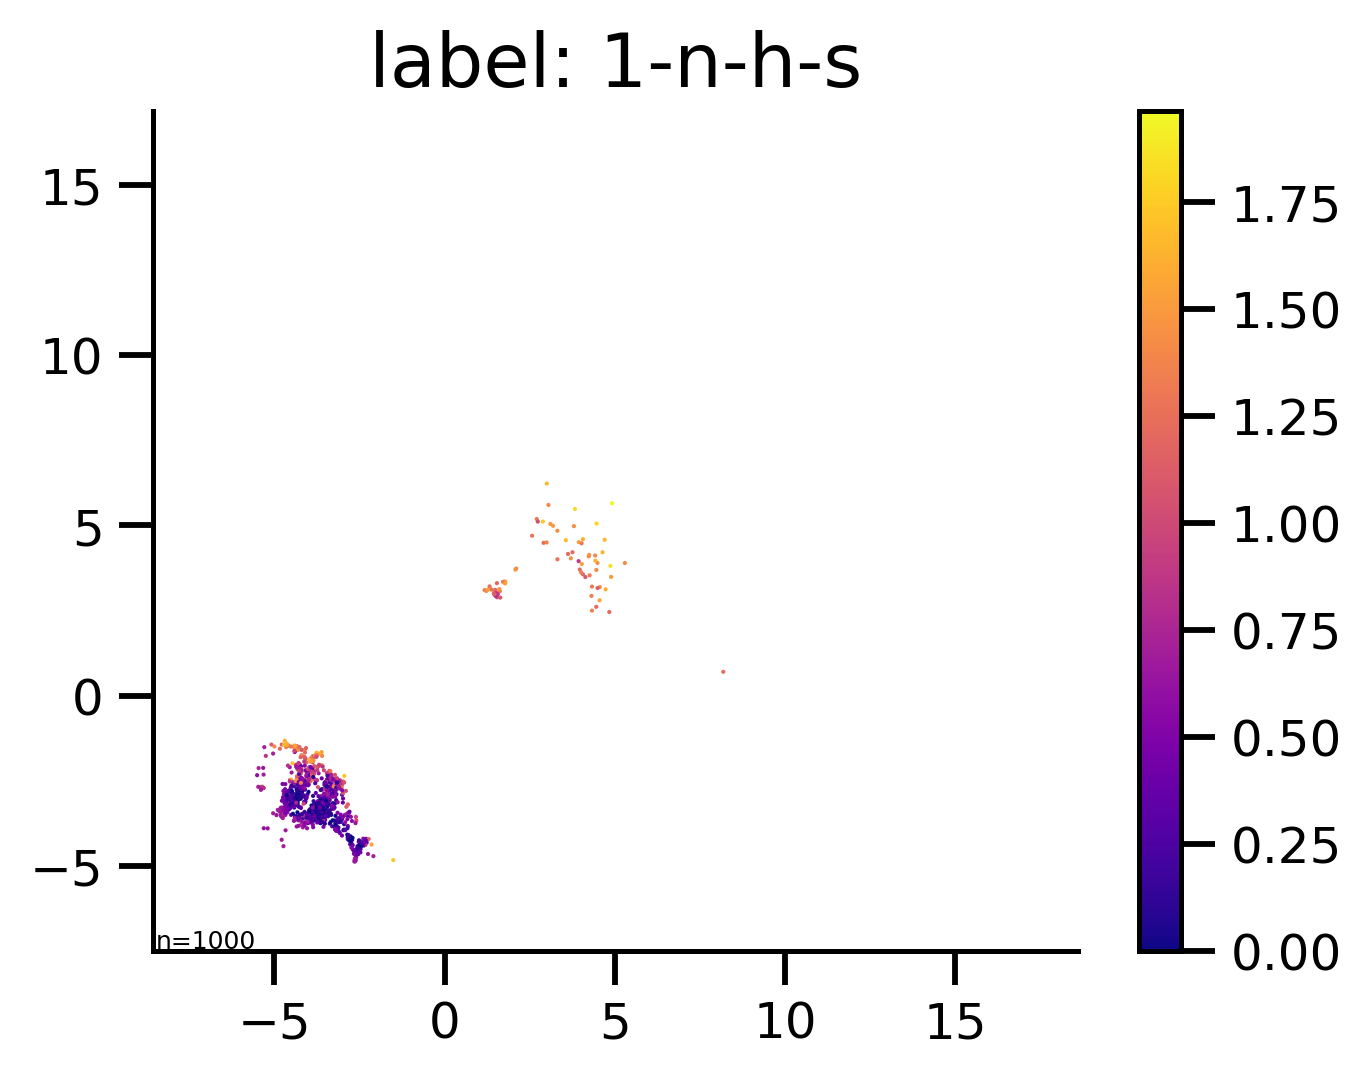

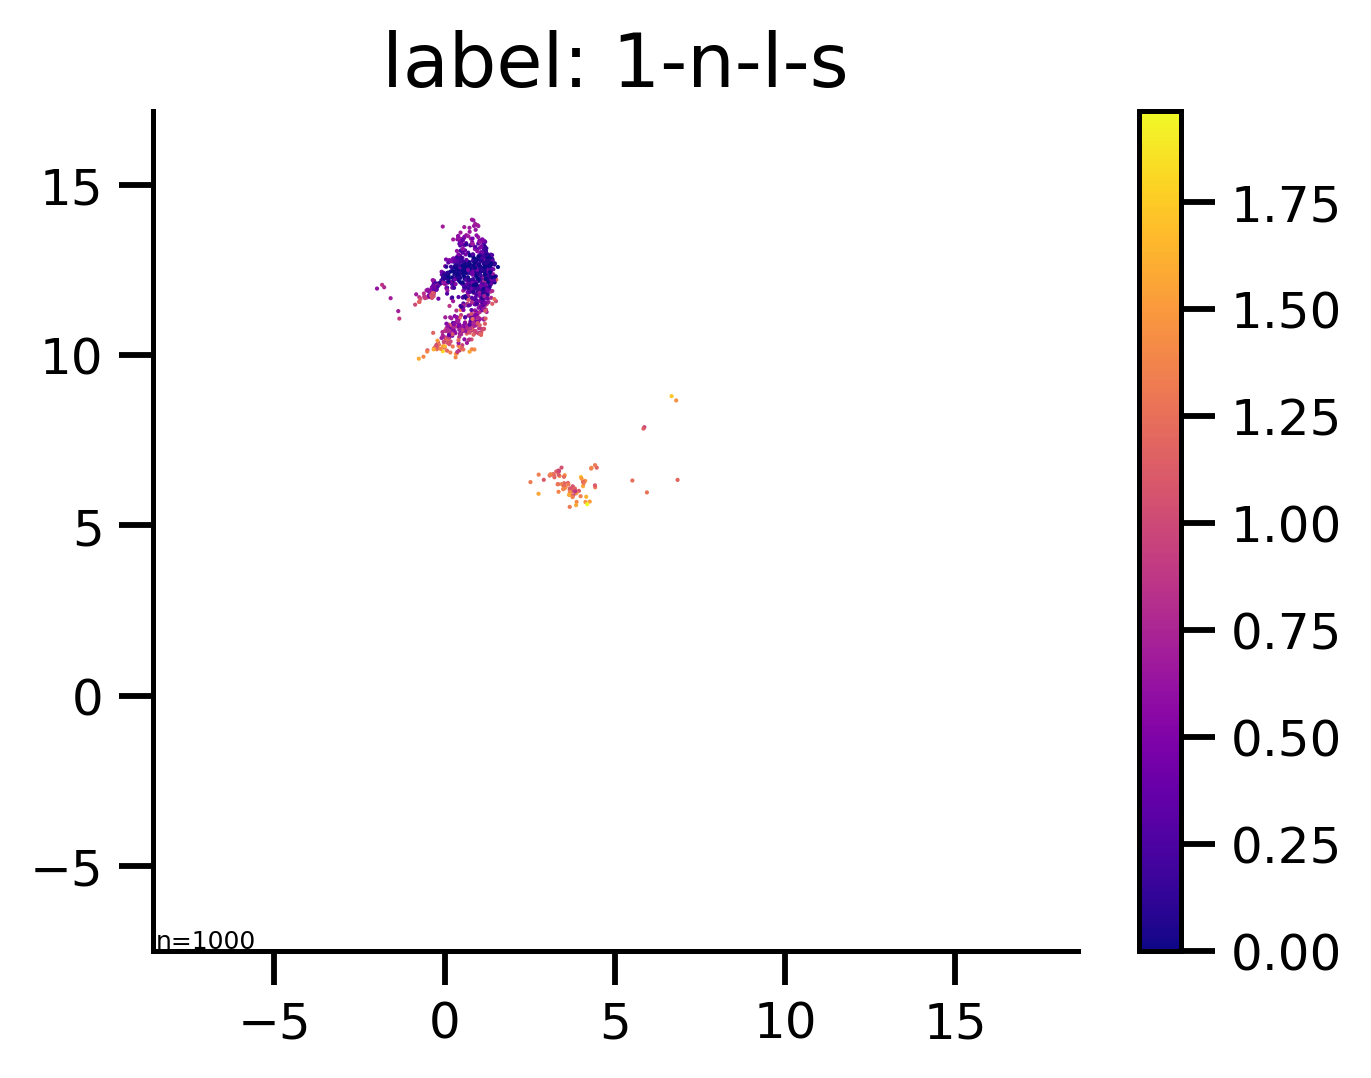

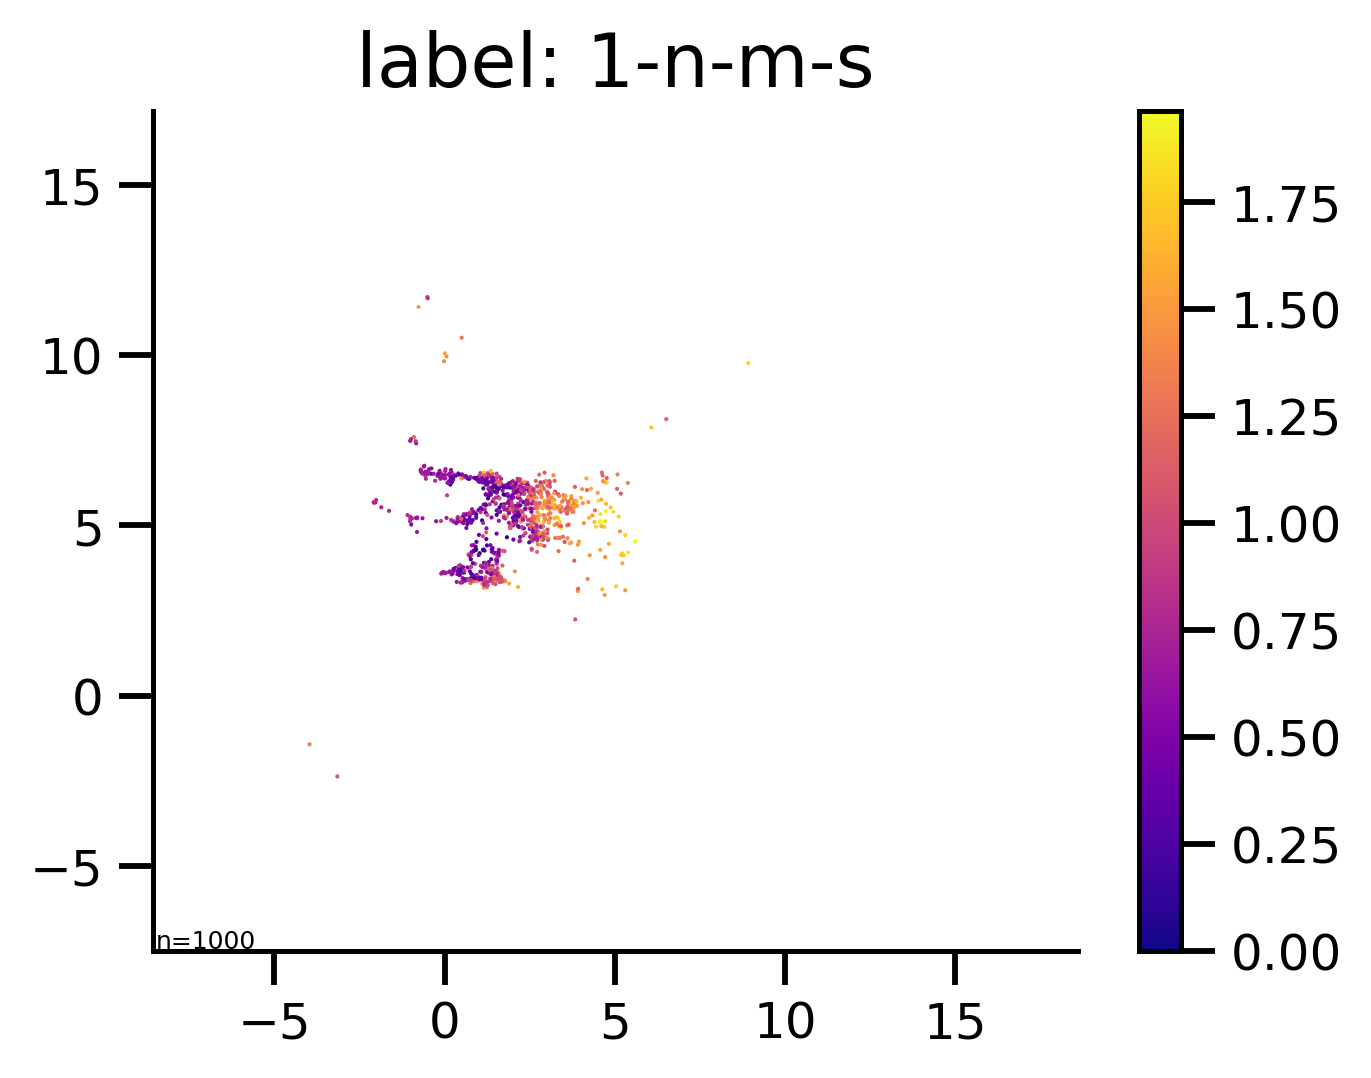

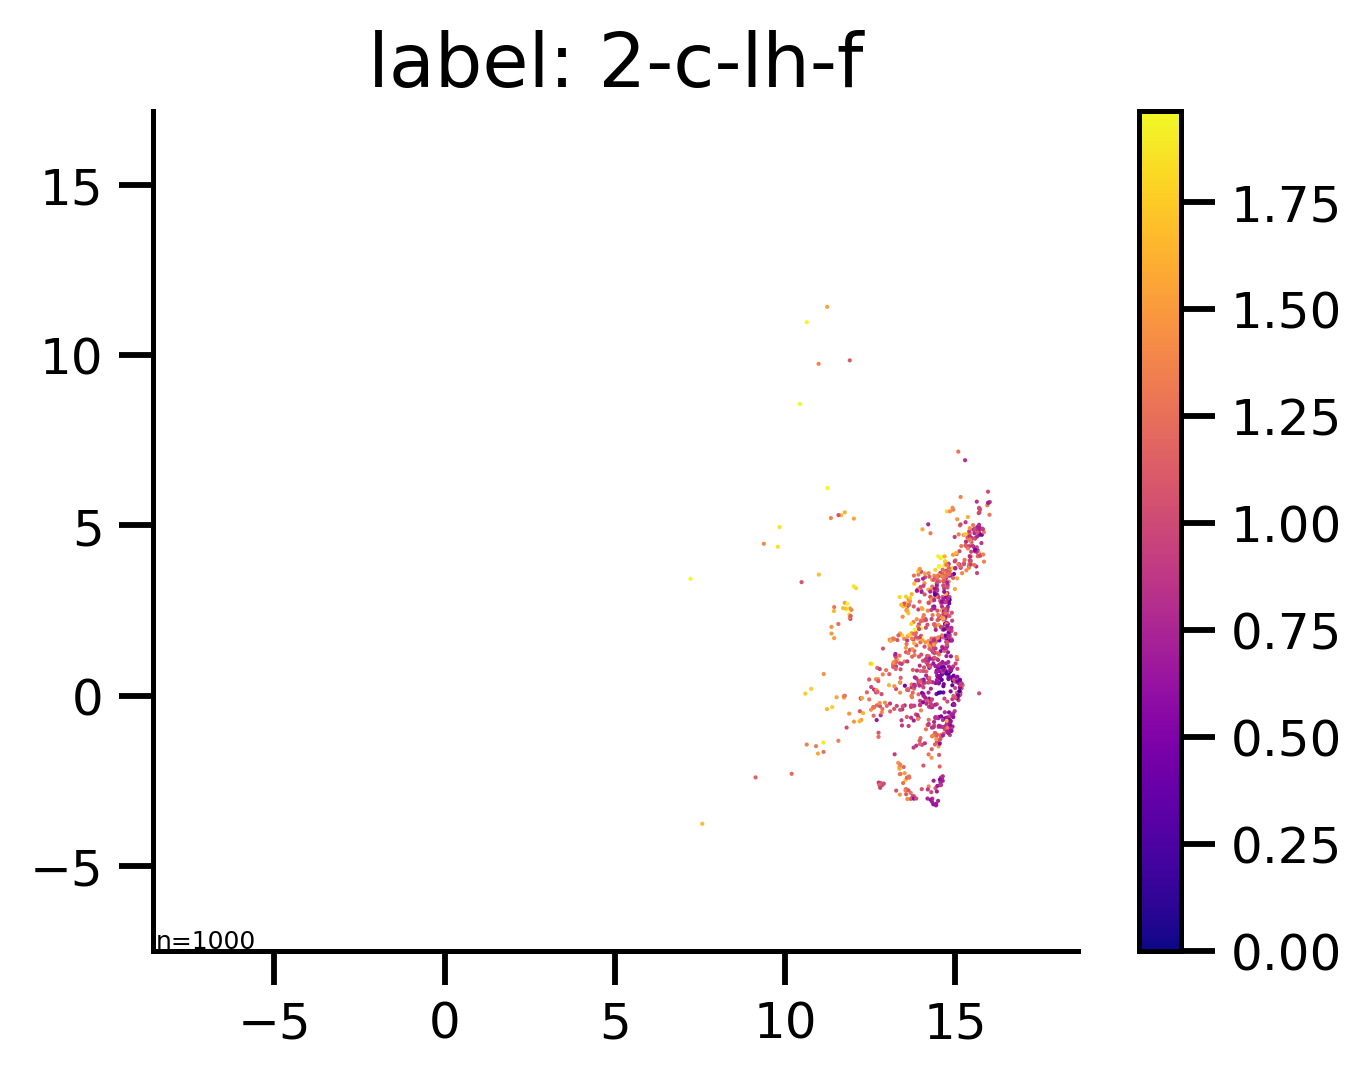

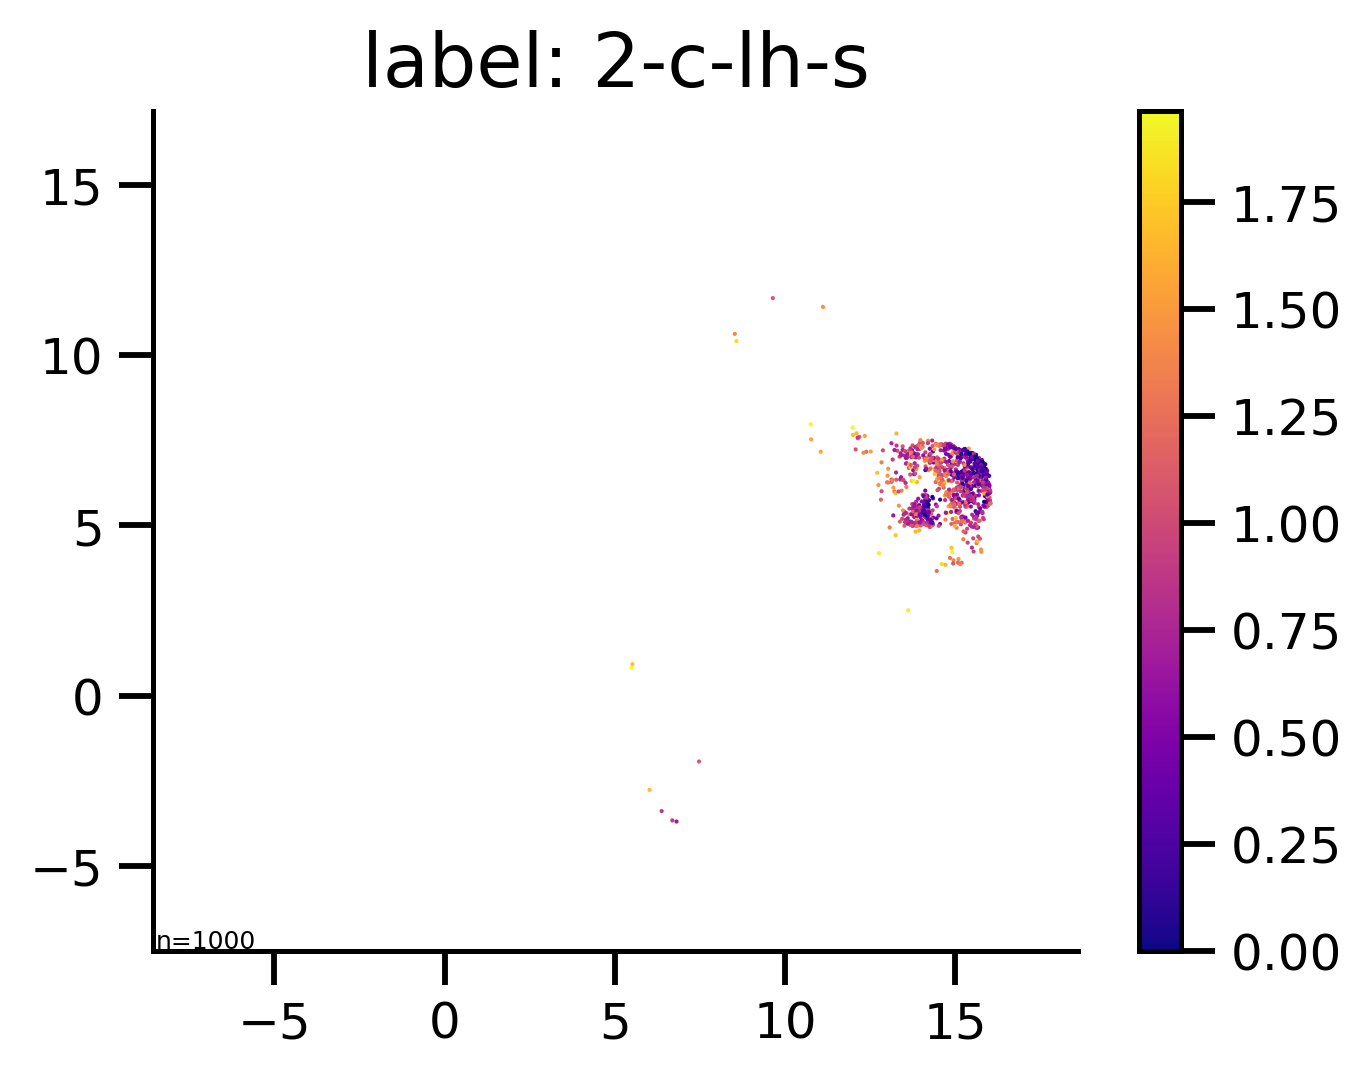

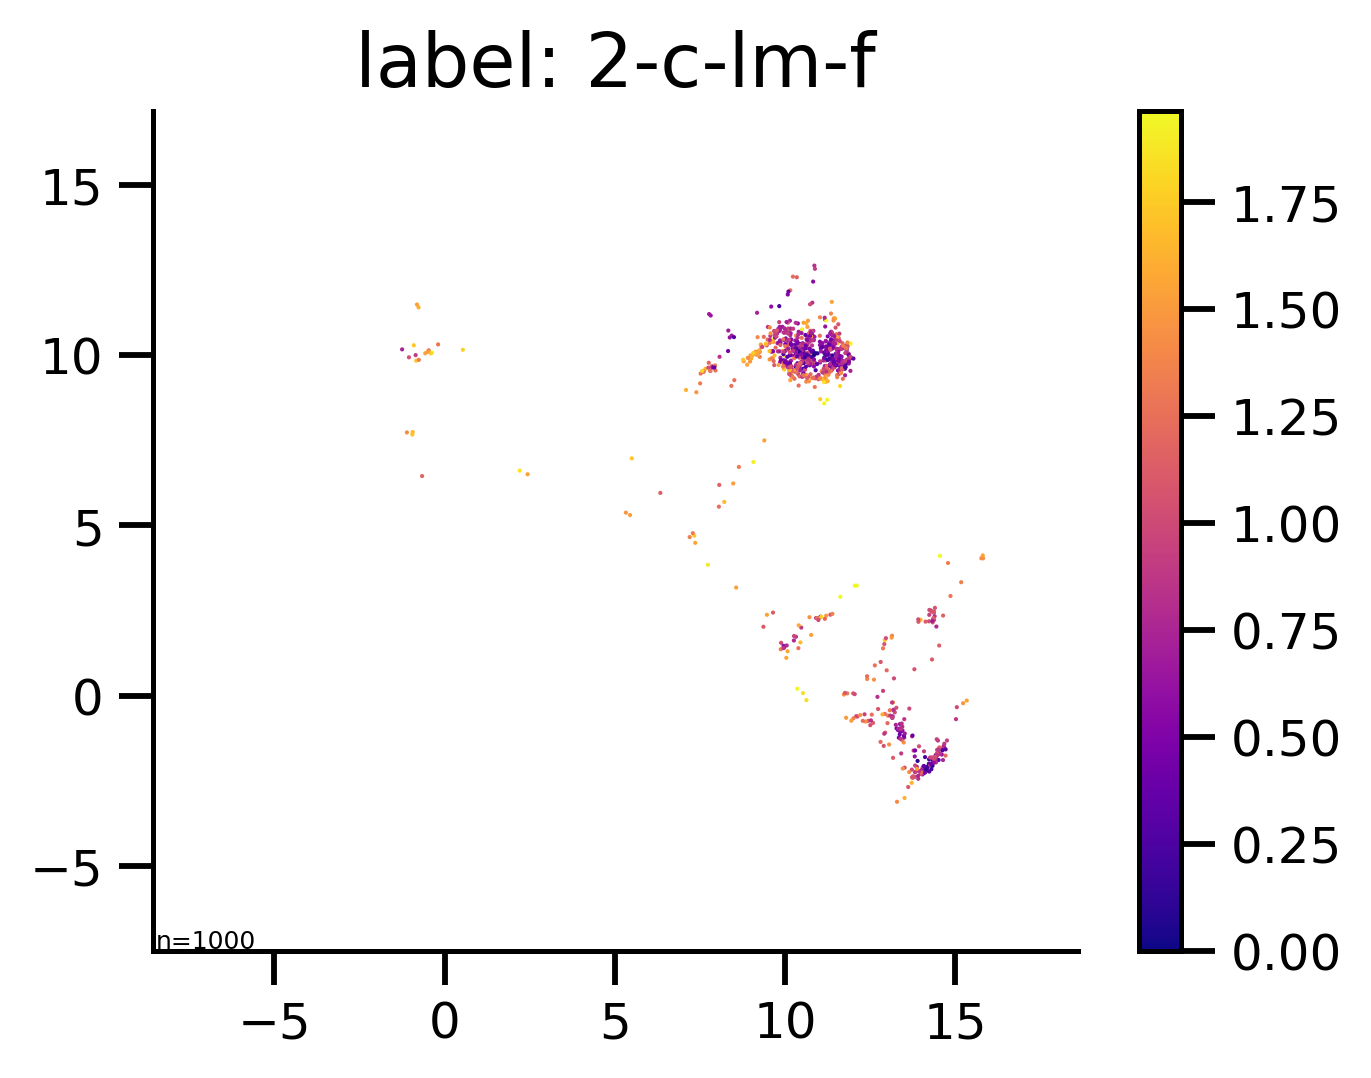

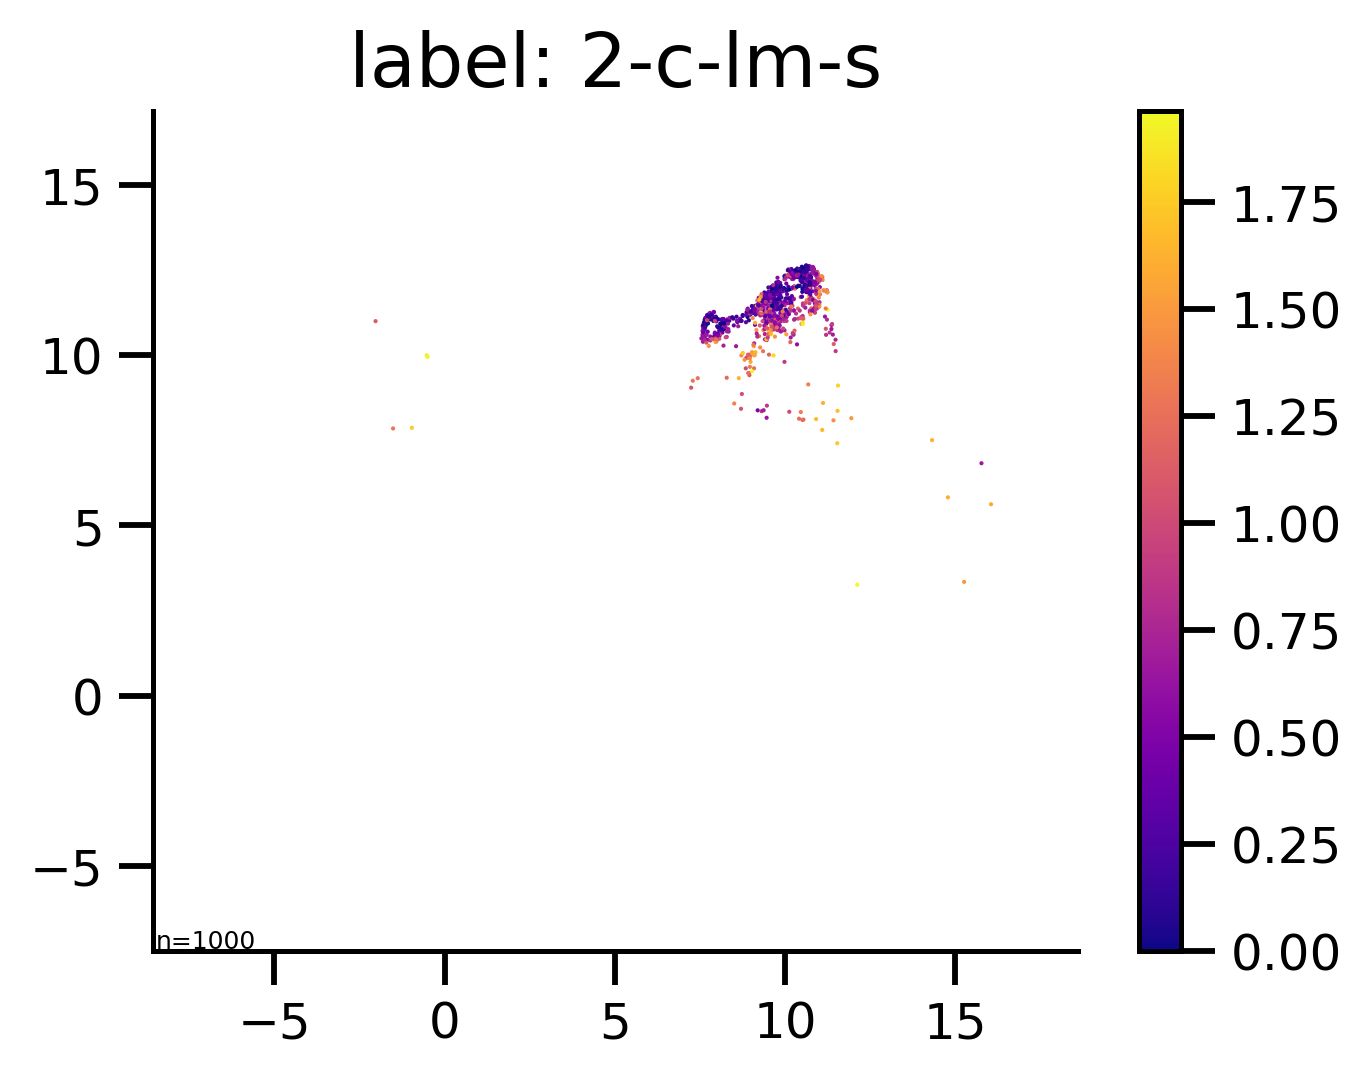

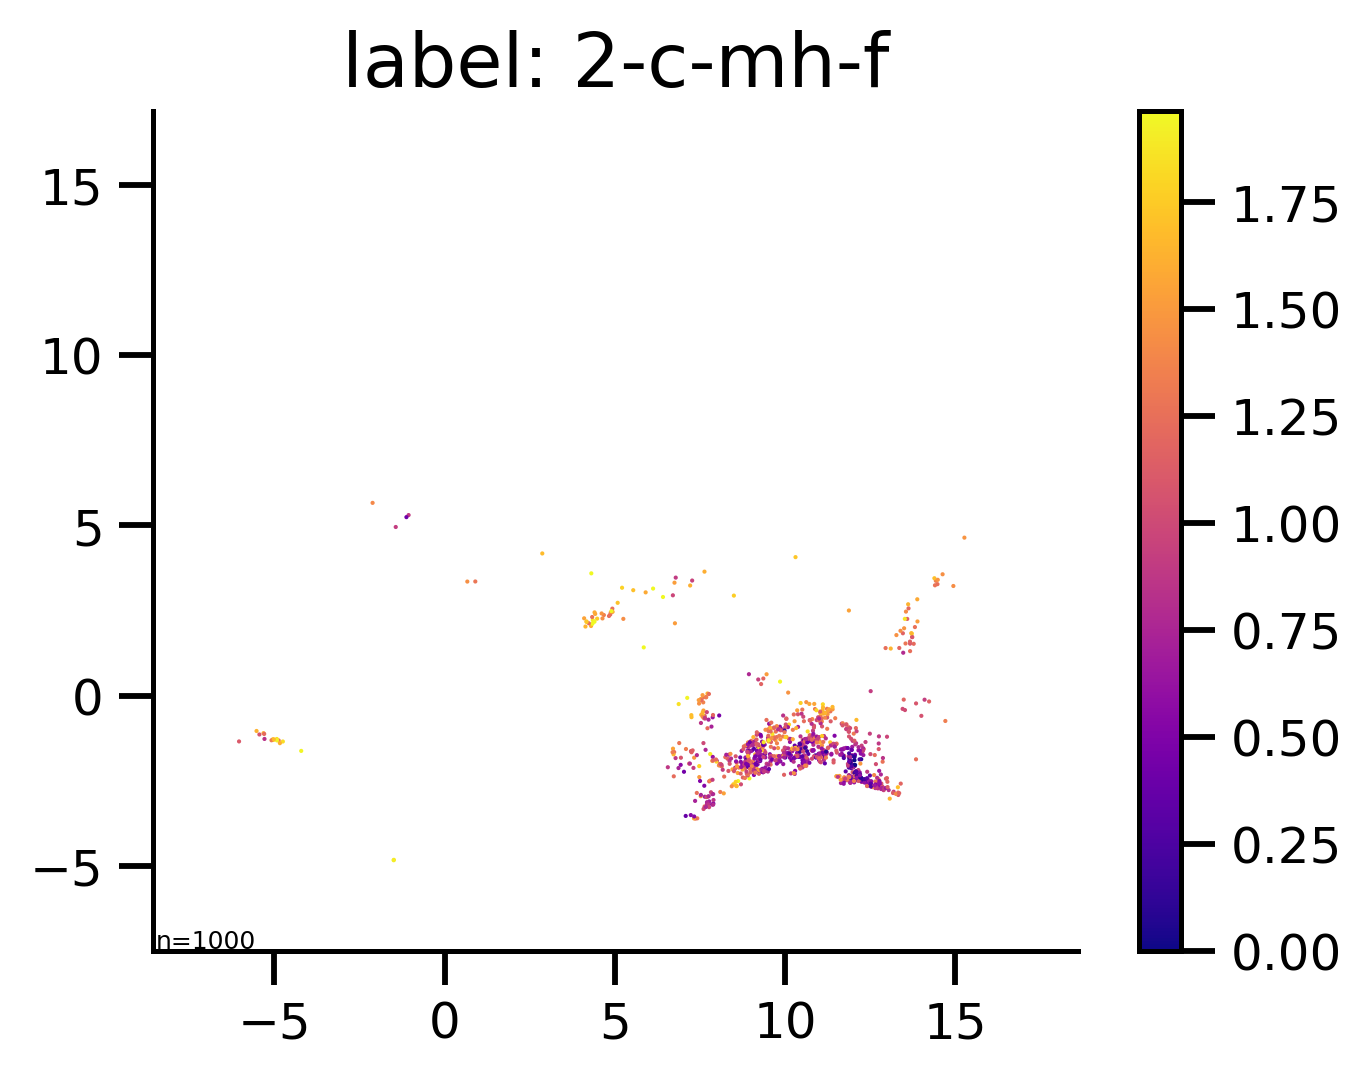

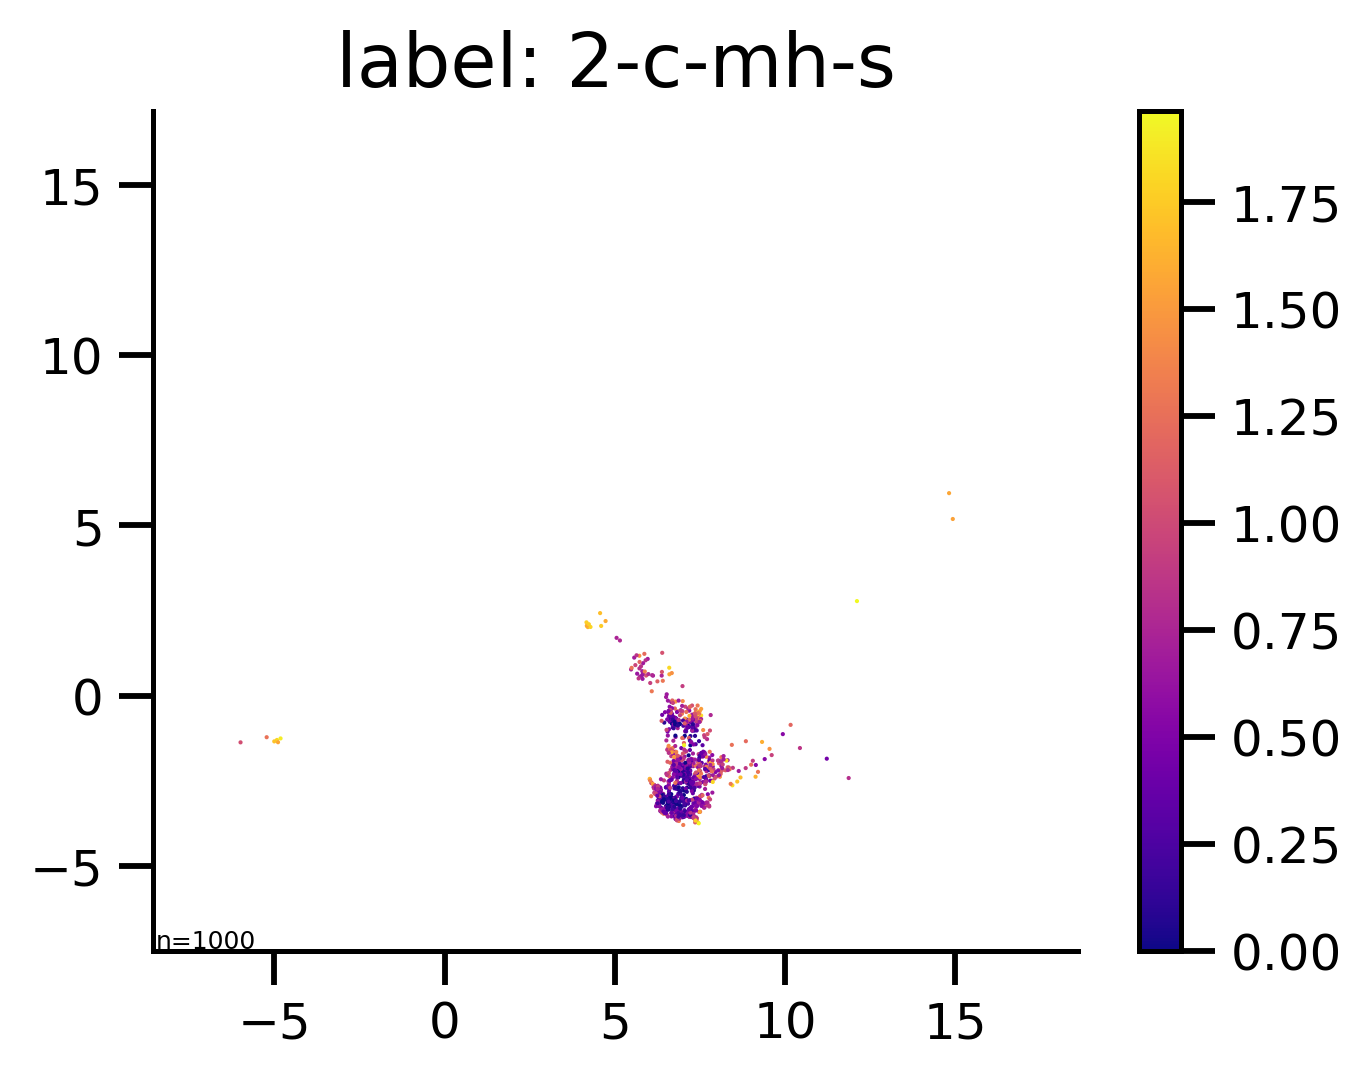

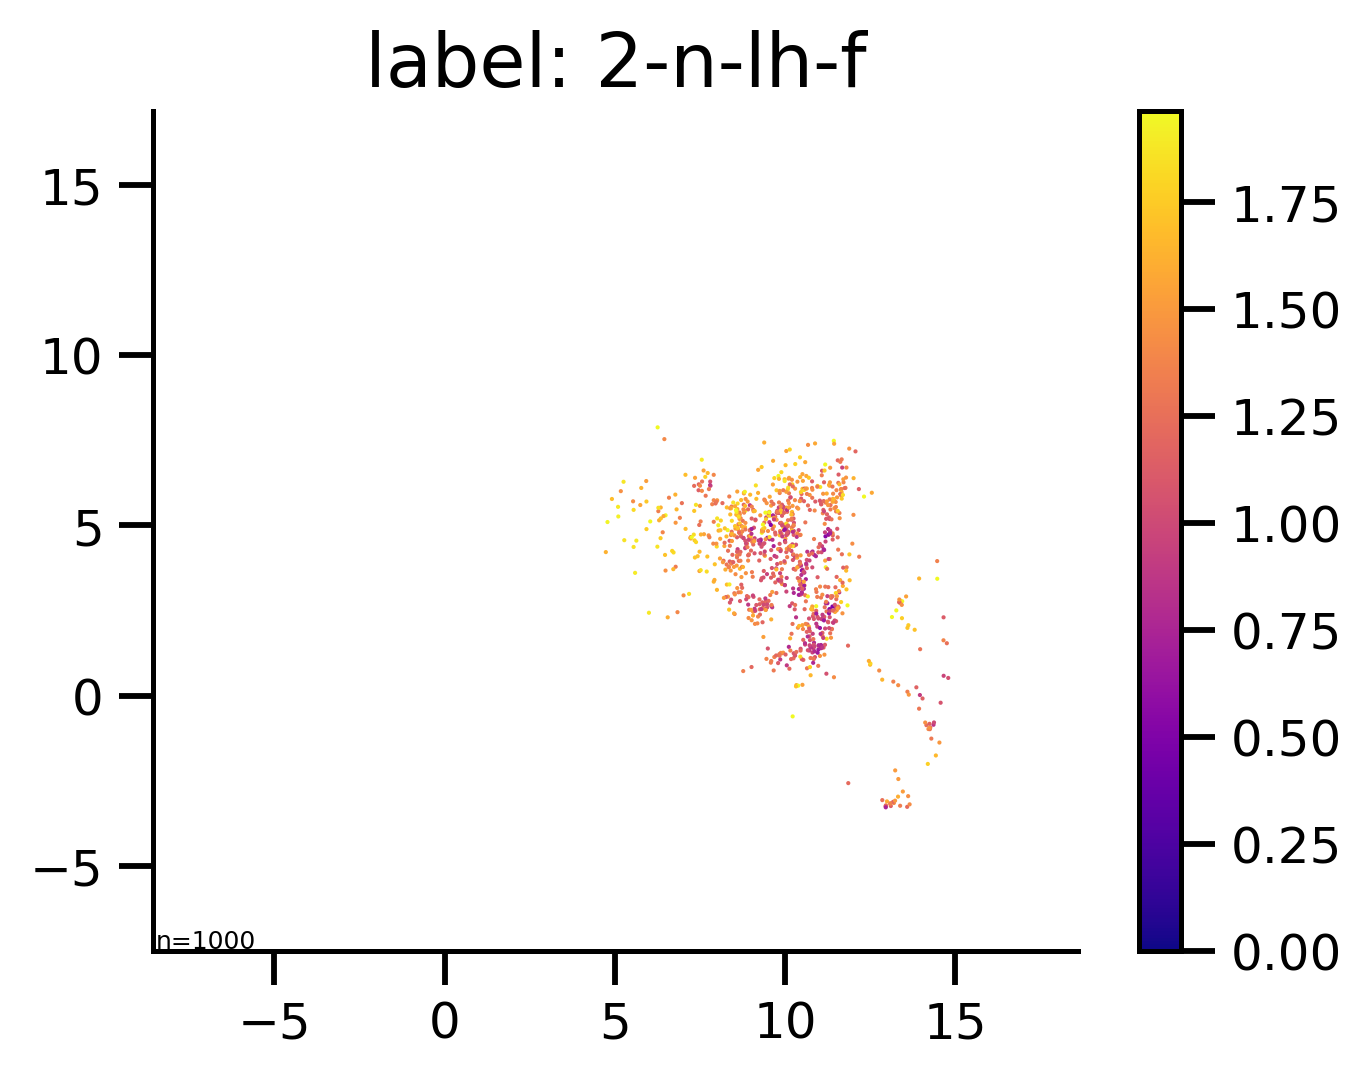

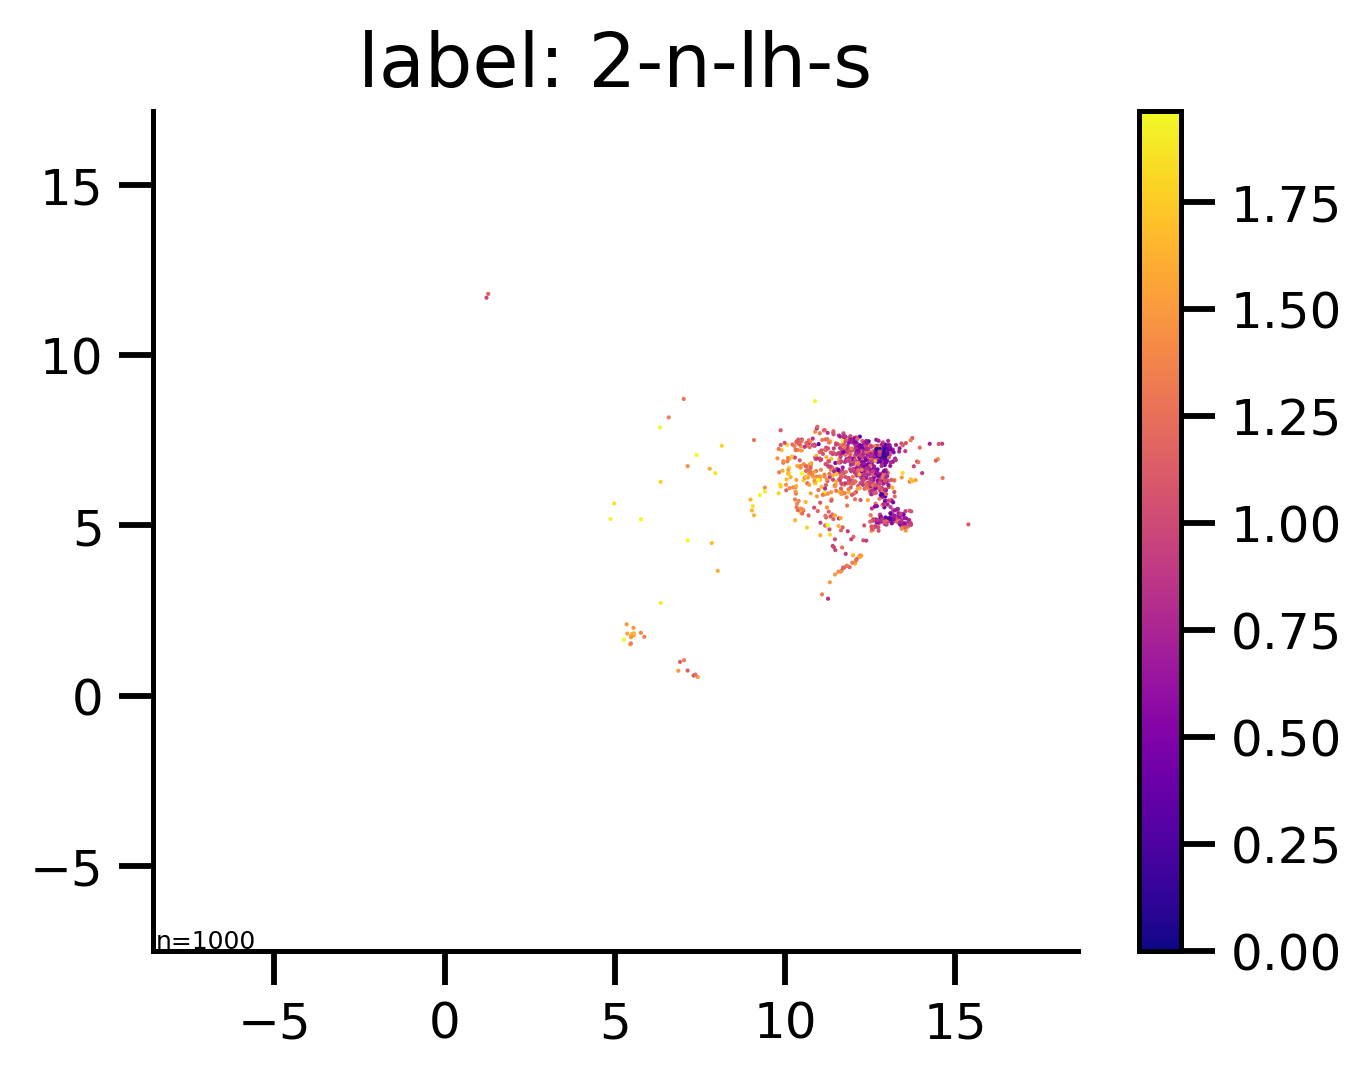

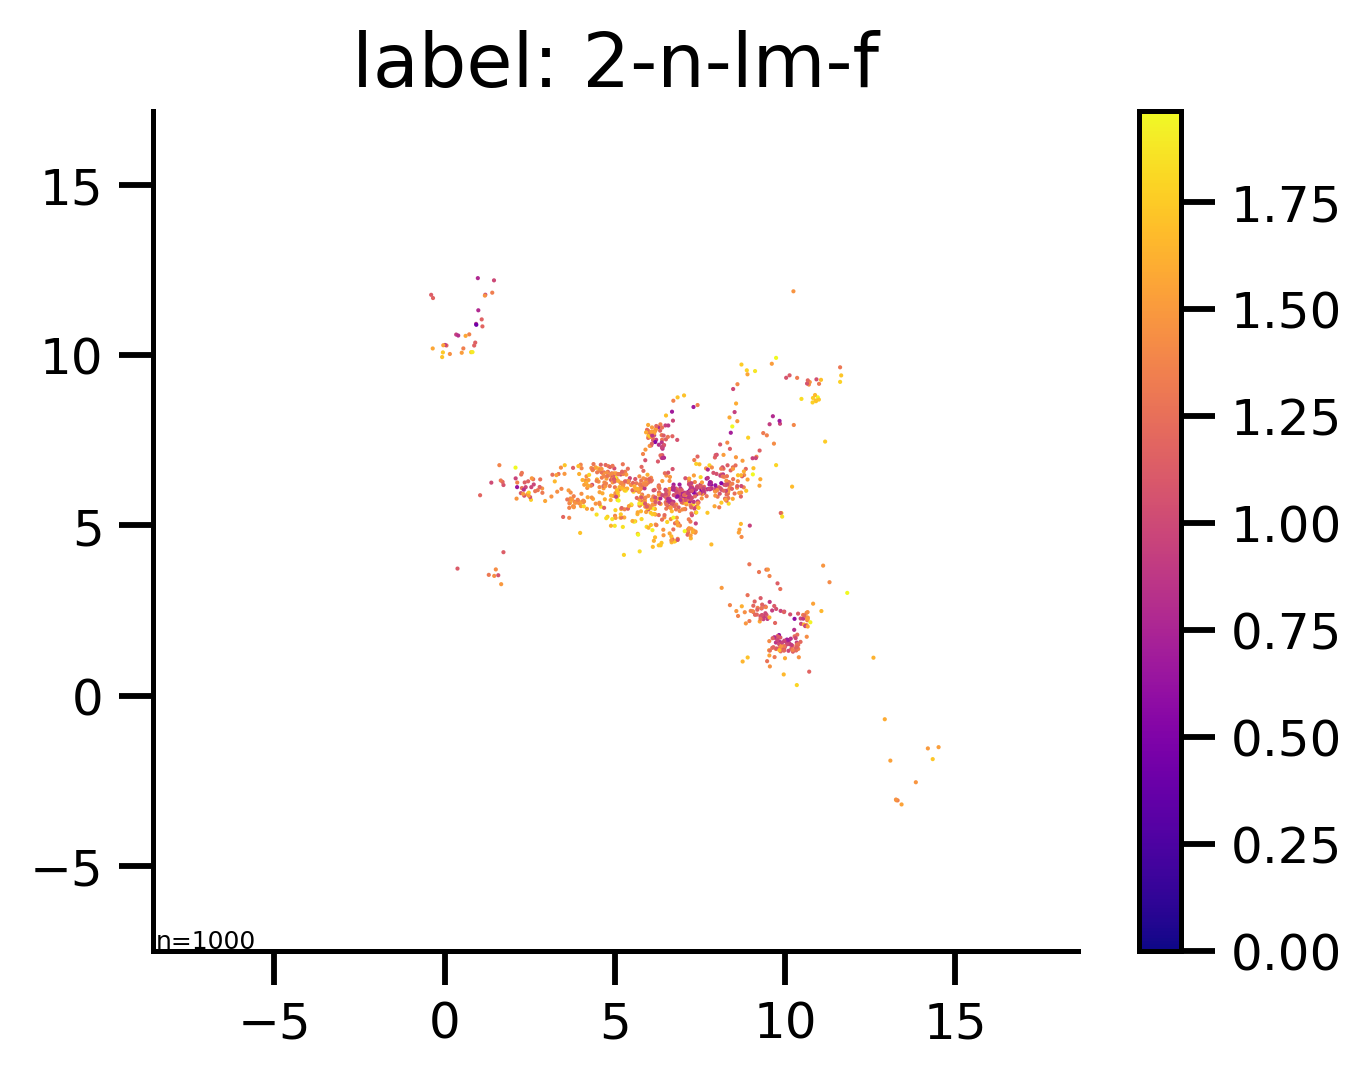

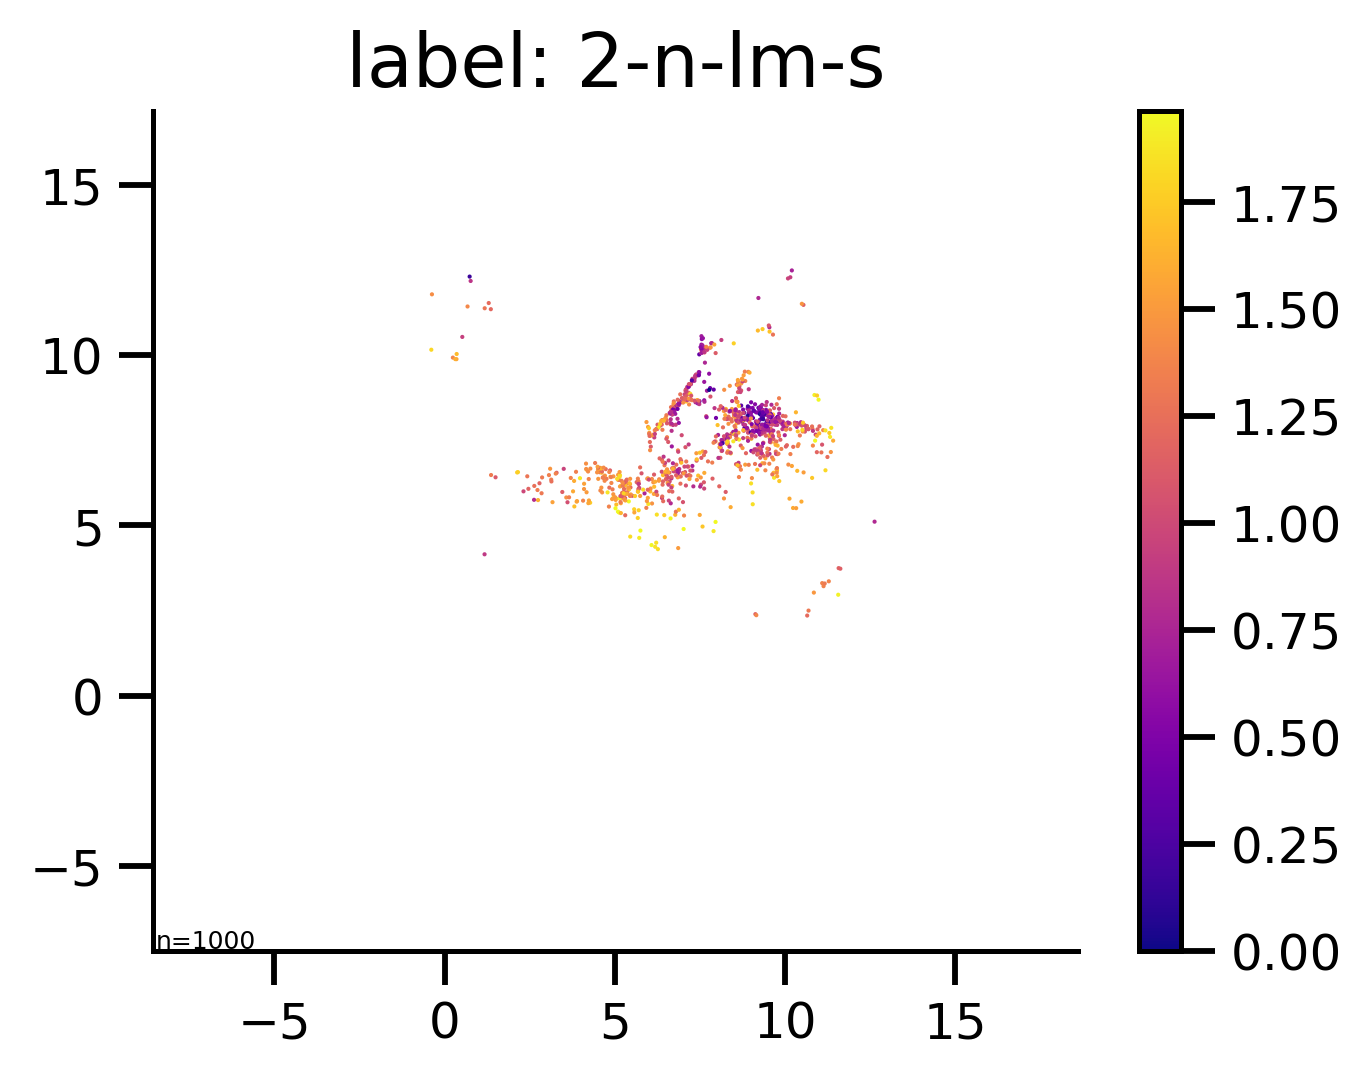

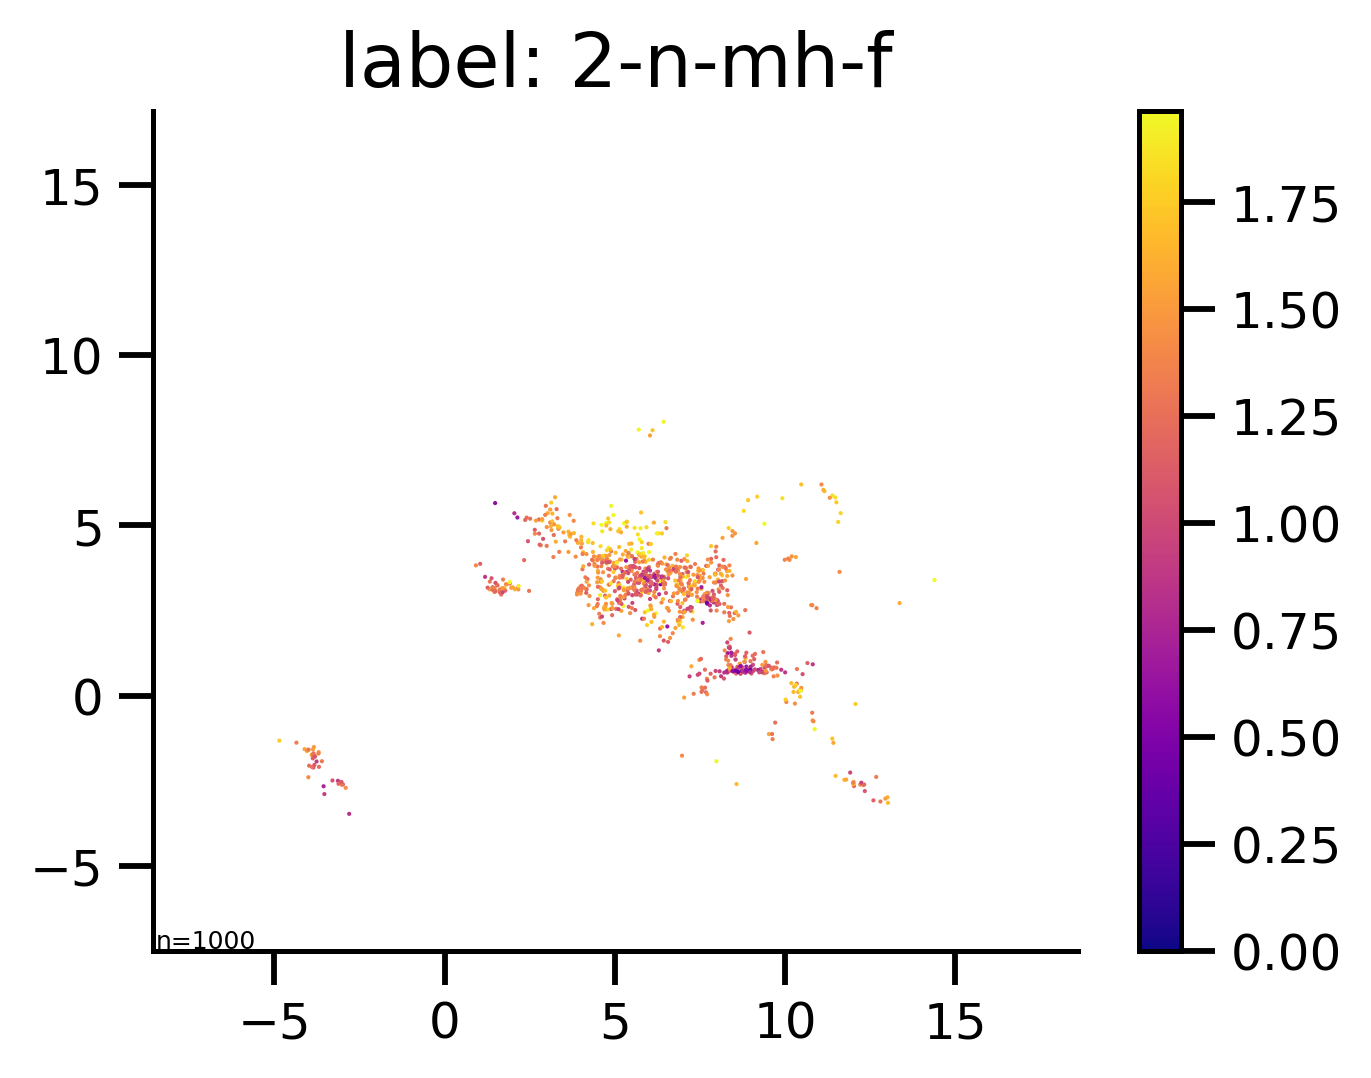

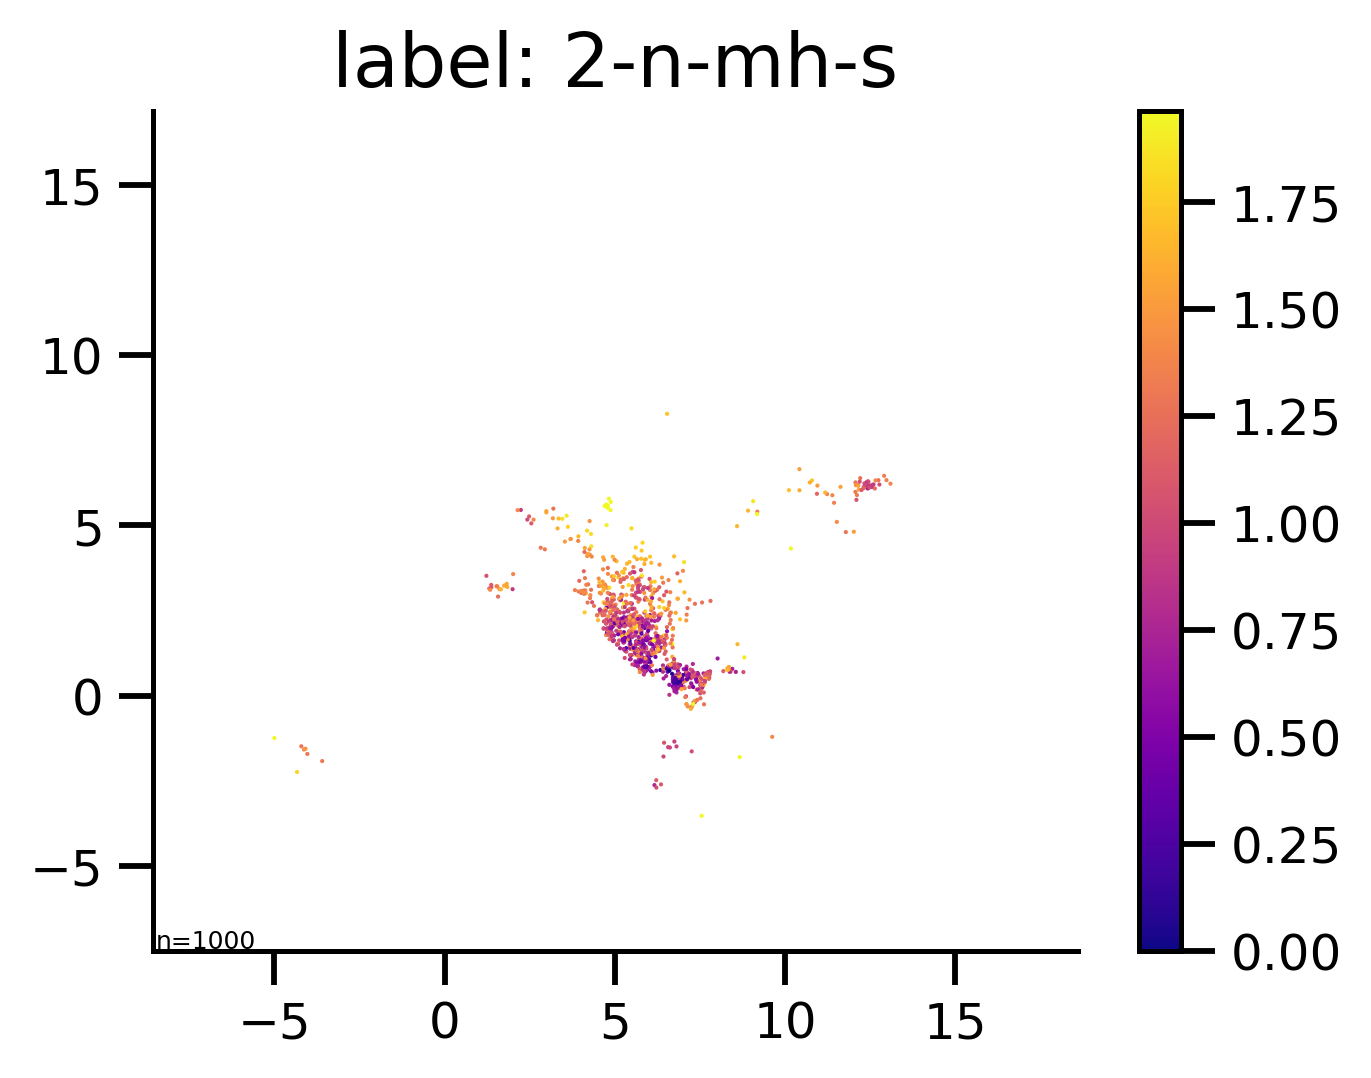

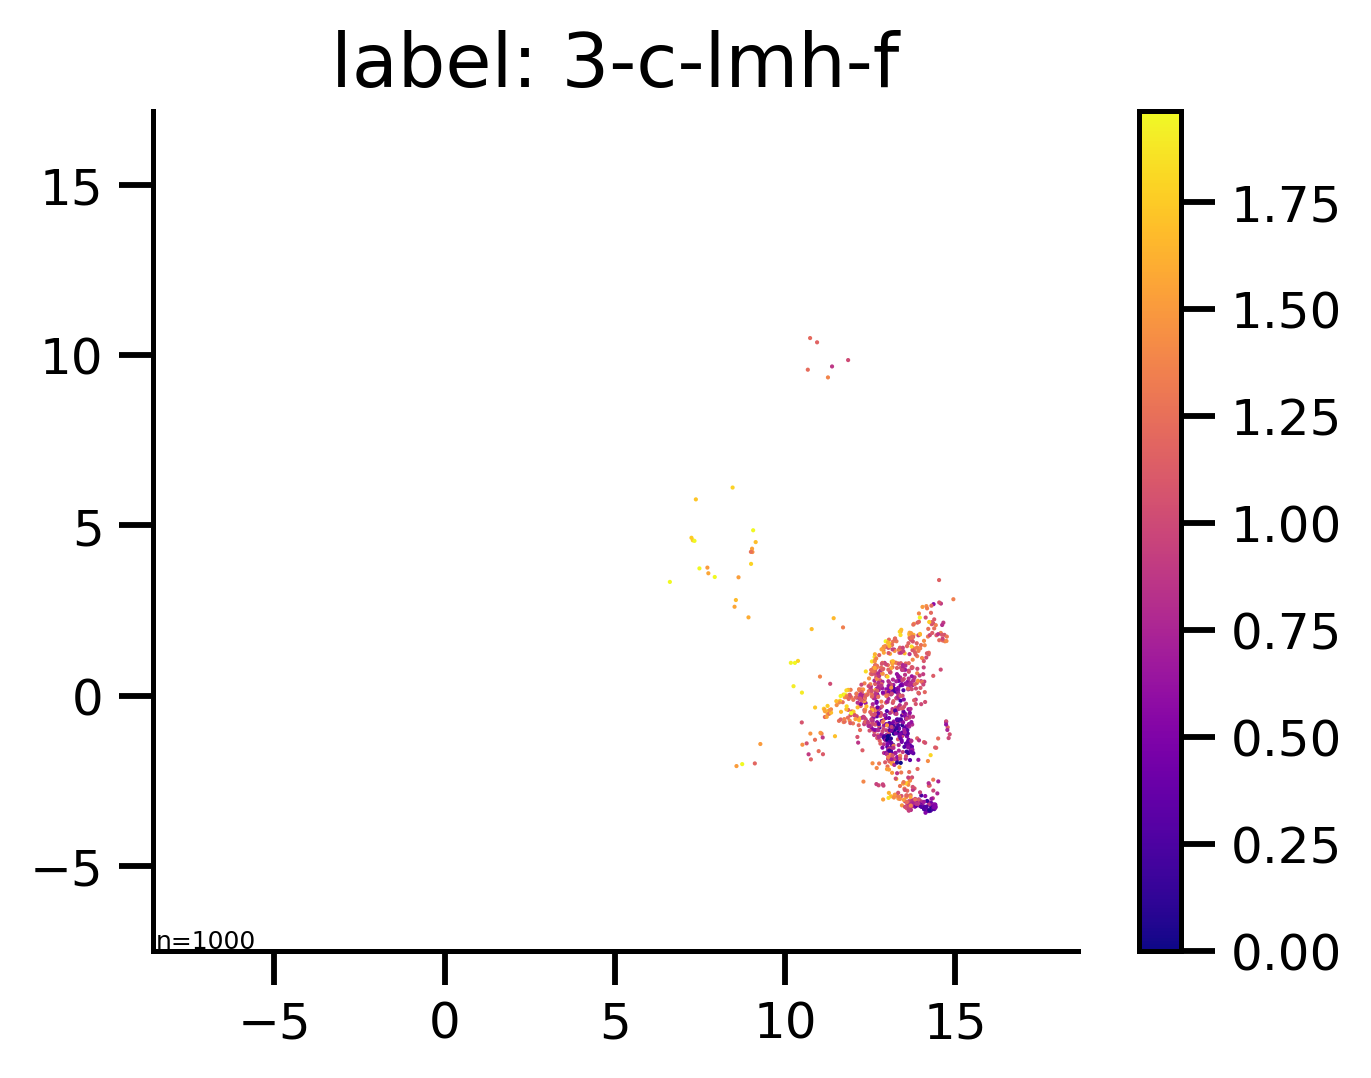

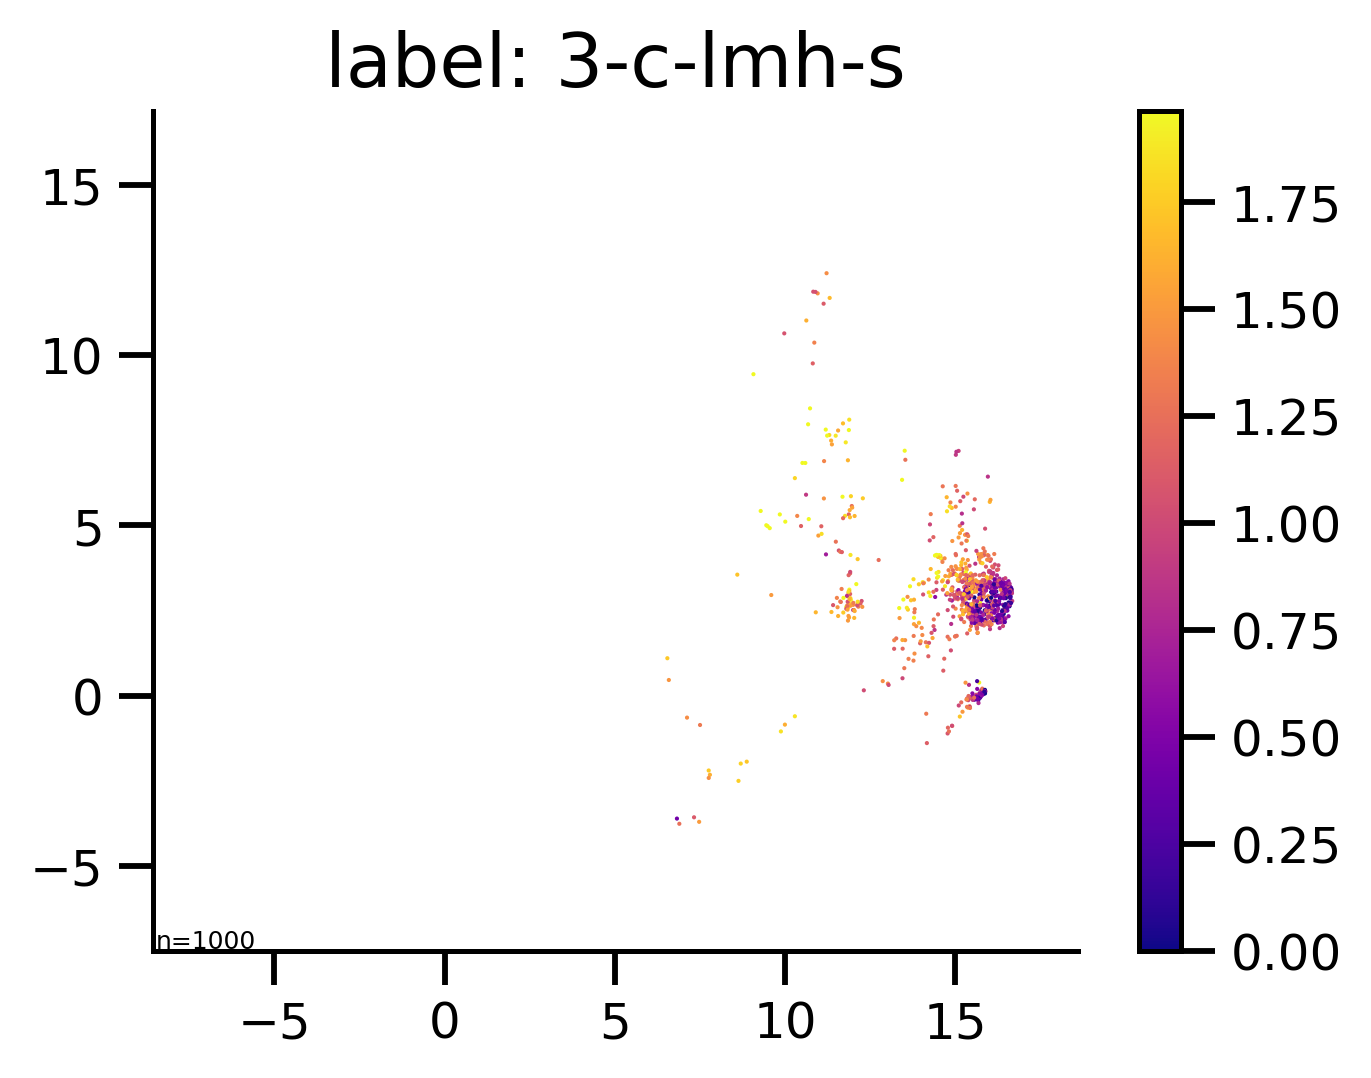

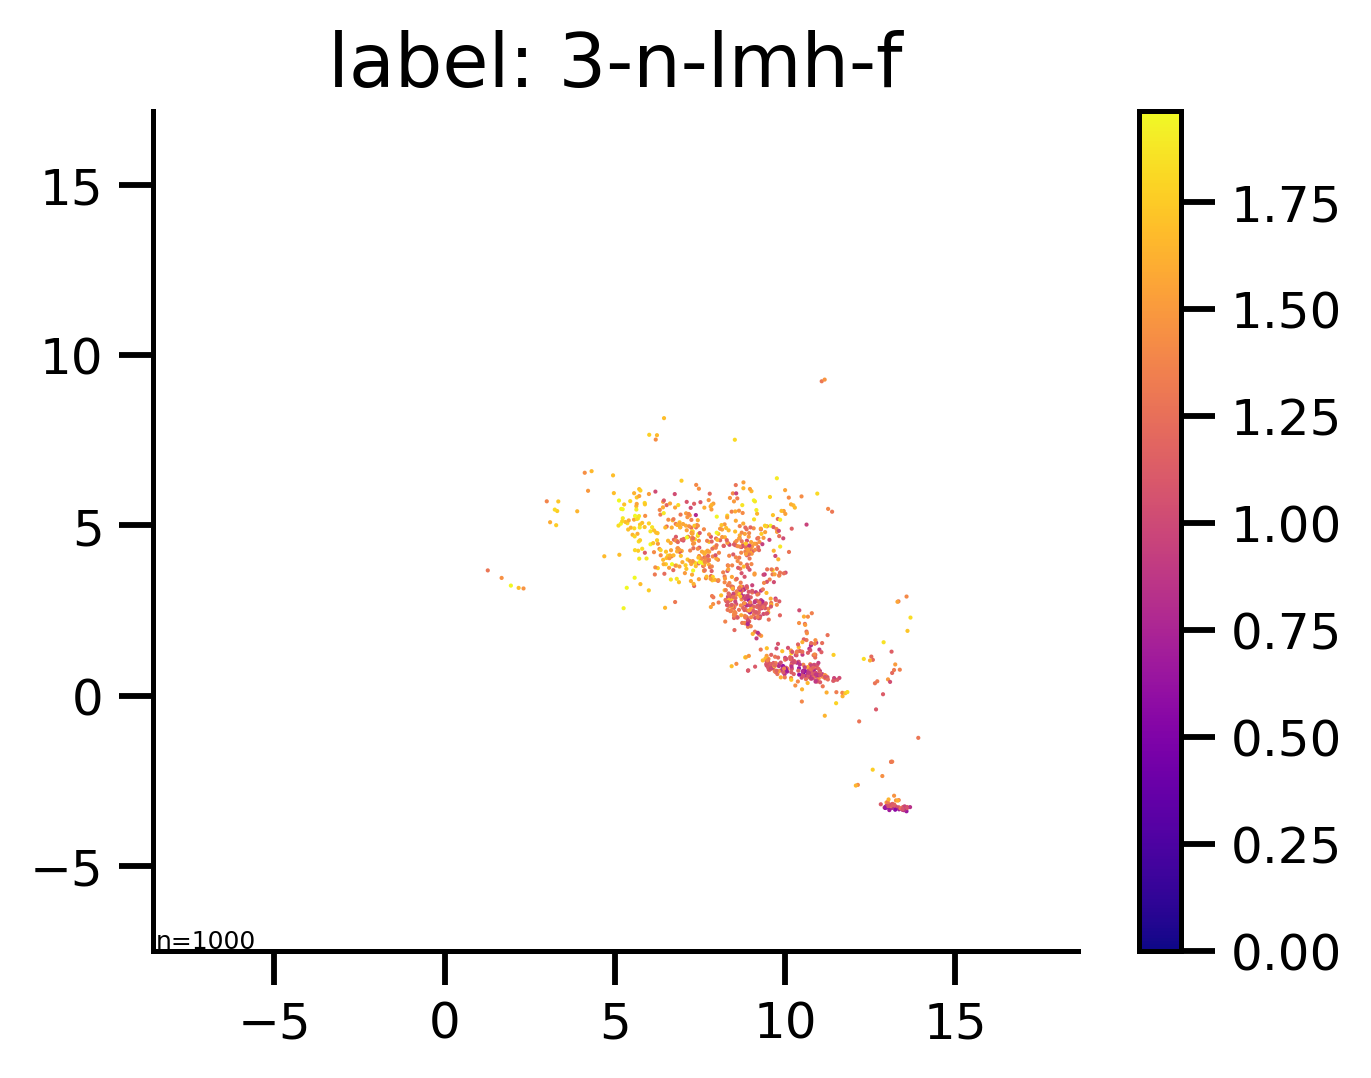

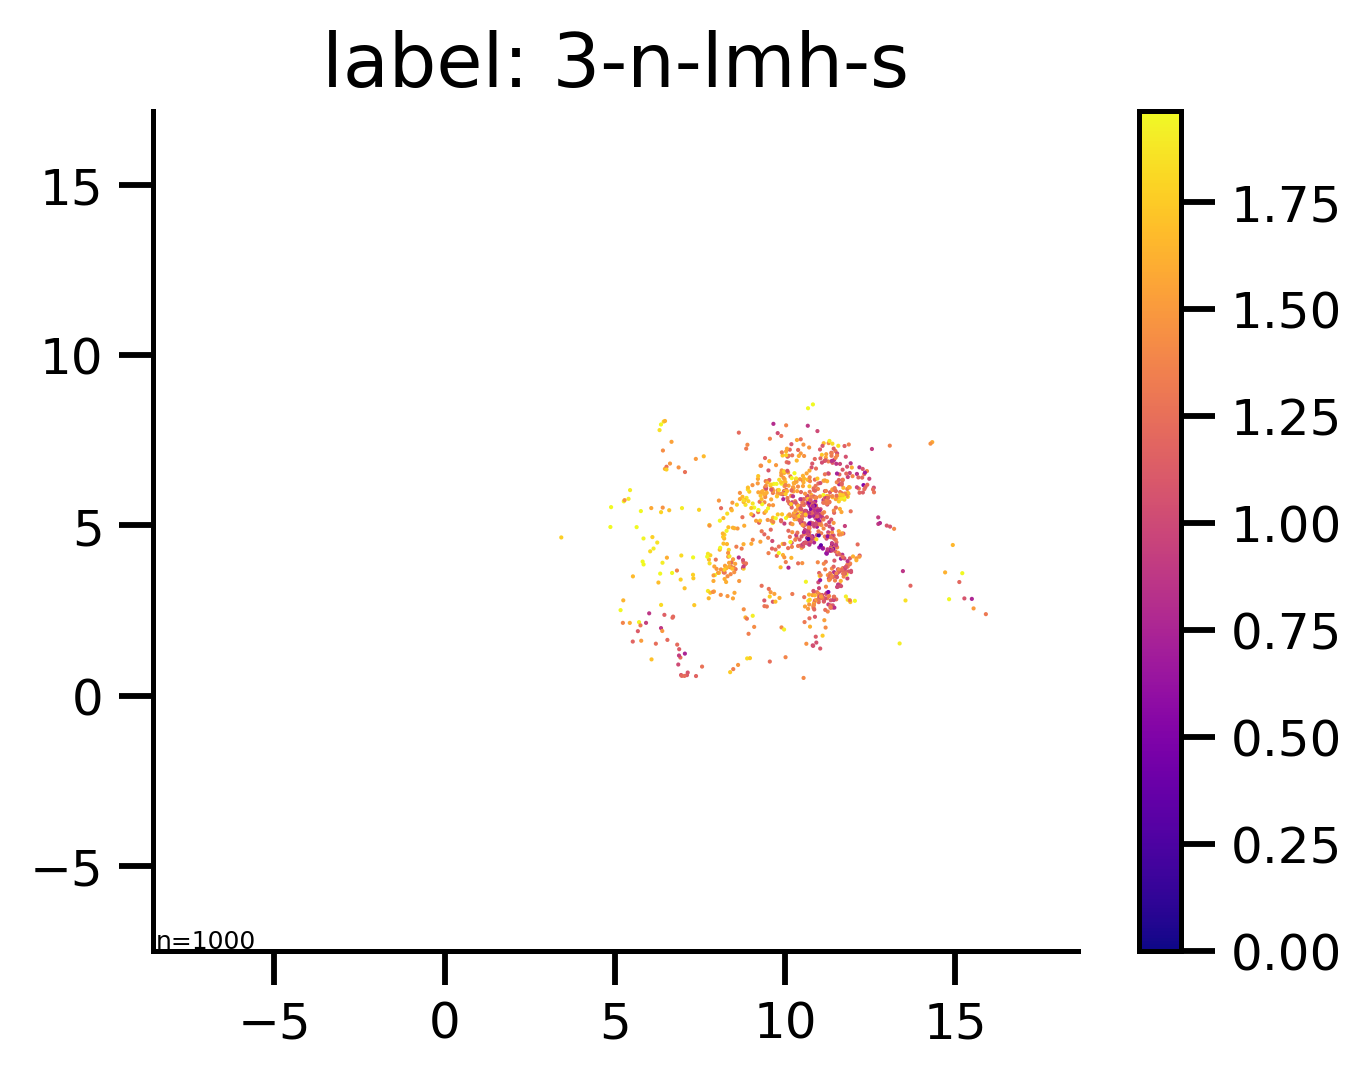

In [271]:
cutoff = np.quantile(perplexity_simulated, 1.0)
unique_labels = np.unique(simulated_label)
simulated_h = principal_projection(simulated_embedding, projection_matrices, PRINCIPAL_DIMENTIONS)
for l in sorted(unique_labels, key=lambda s: int(re.findall(string=s, pattern='\d+')[0])):
    idx = (simulated_label == l)
    z = reducer.transform(simulated_h[idx, :])
    with plt.style.context(spstyle.get_style('nature-reviews')):
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
        s = ax.scatter(z[:, 0], z[:, 1], s=1, c=perplexity_simulated[idx], alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_simulated, 0.01), vmax=np.quantile(perplexity_simulated, 0.99))
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.set_xlim([np.min(umap_embedding[:, 0]) - 2, np.max(umap_embedding[:, 0]) + 2])
        ax.set_ylim([np.min(umap_embedding[:, 1]) - 2, np.max(umap_embedding[:, 1]) + 2])
        ax.set_aspect('equal')
        plt.title(f'label: {l}')
        ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 6})
        fig.colorbar(s, ax=ax)

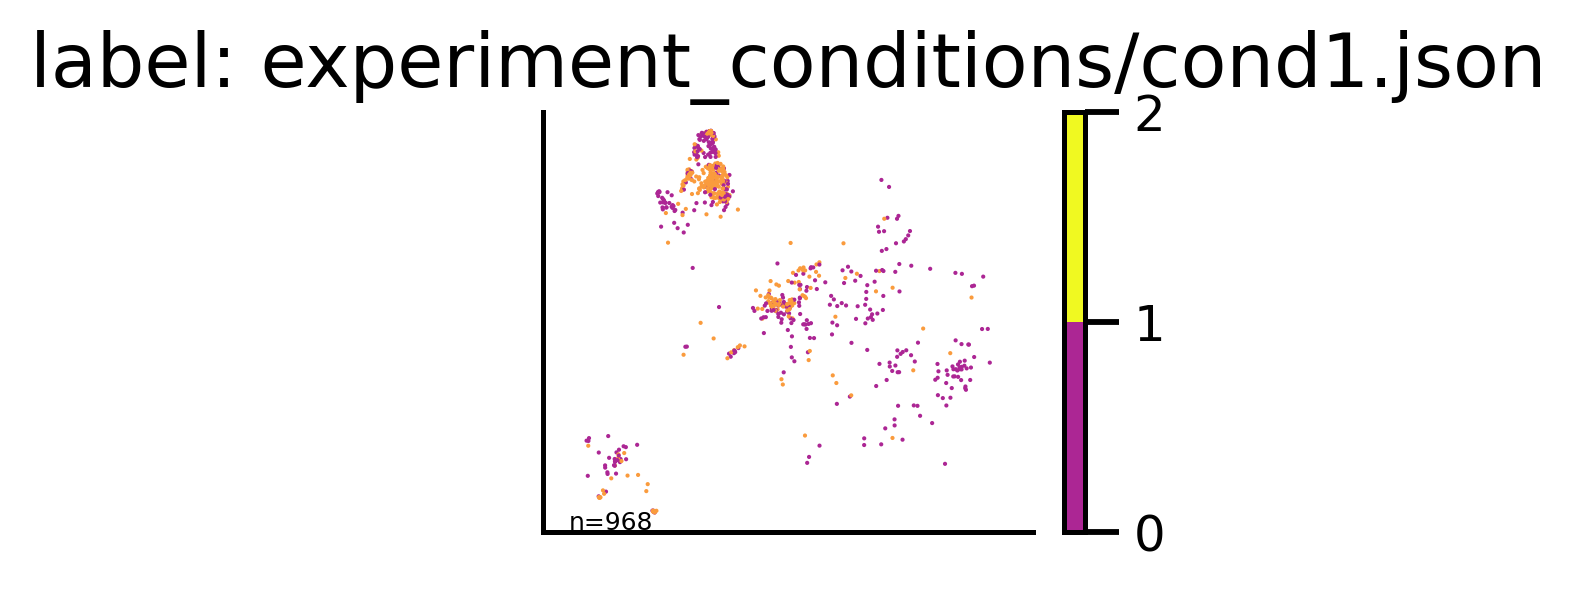

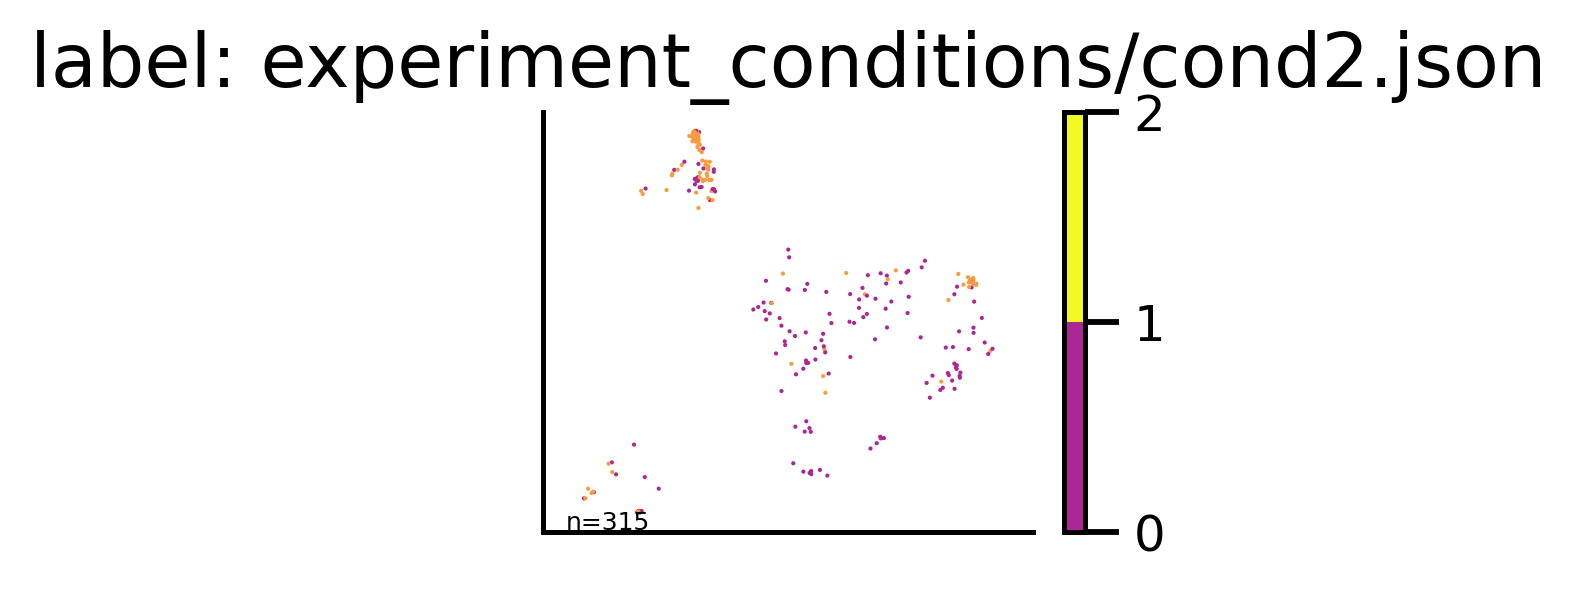

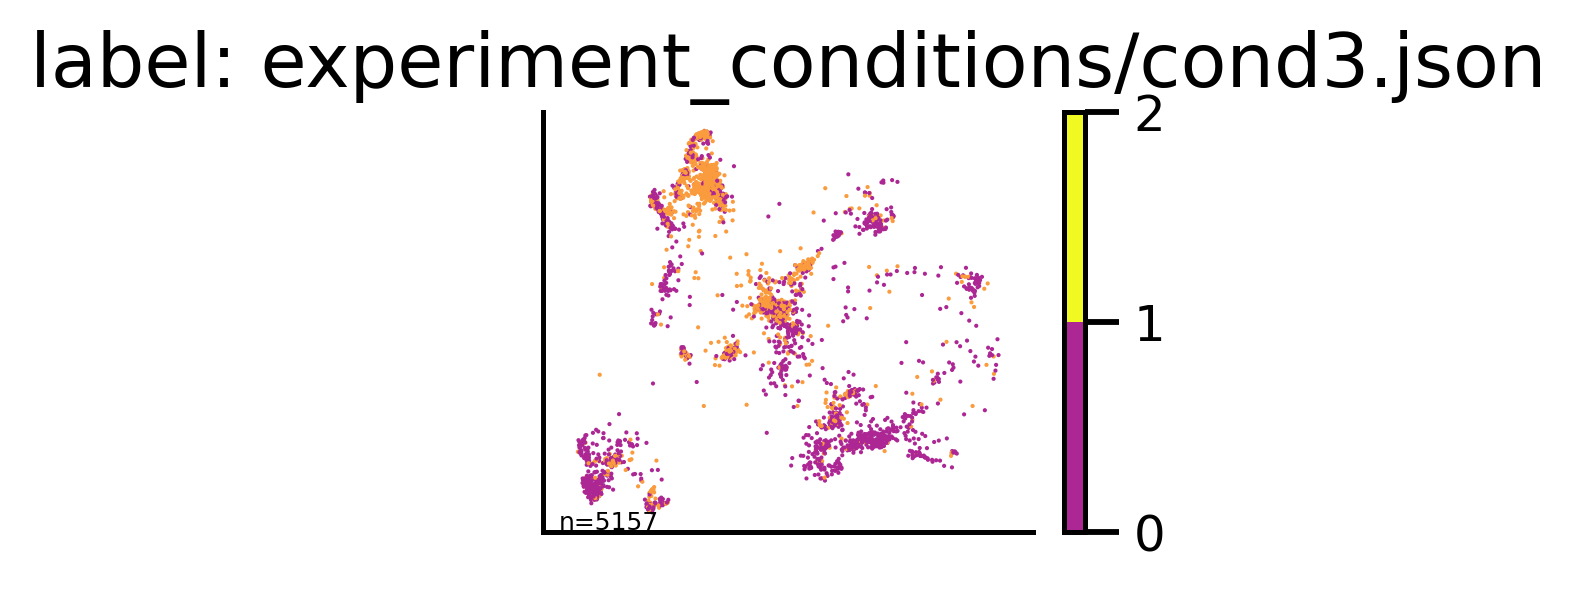

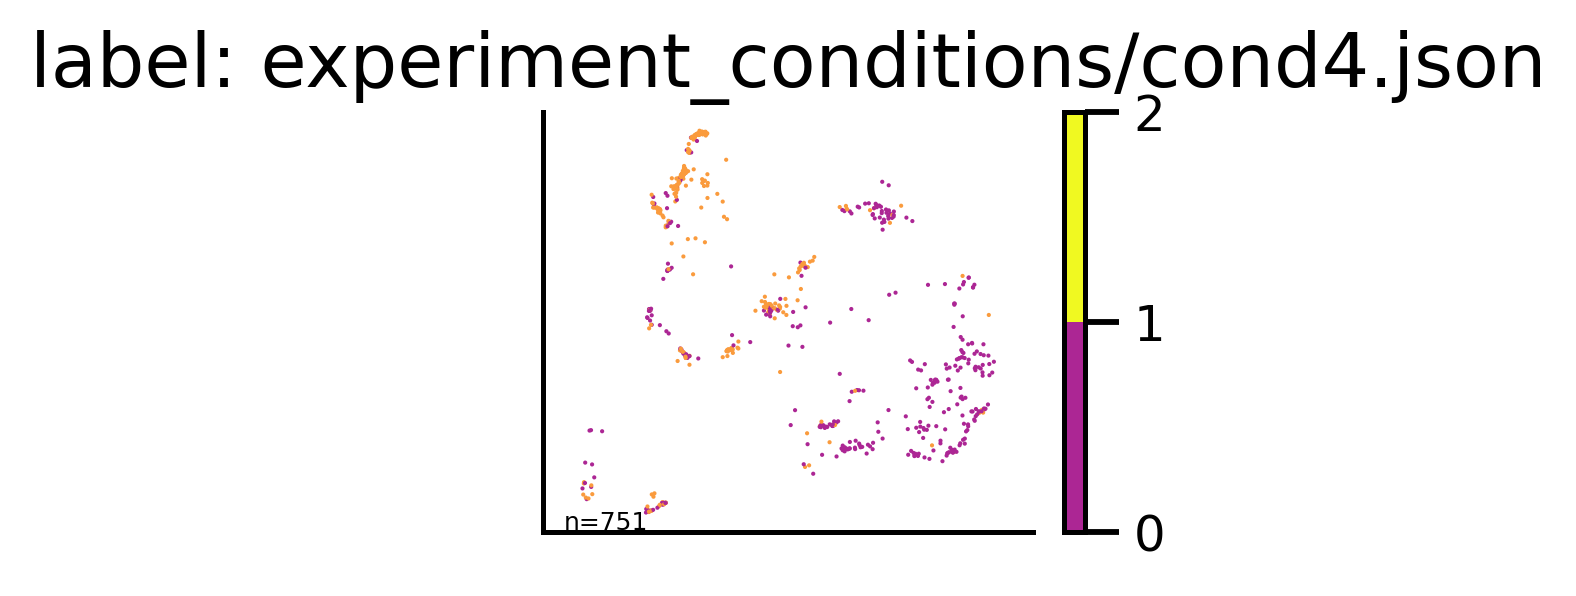

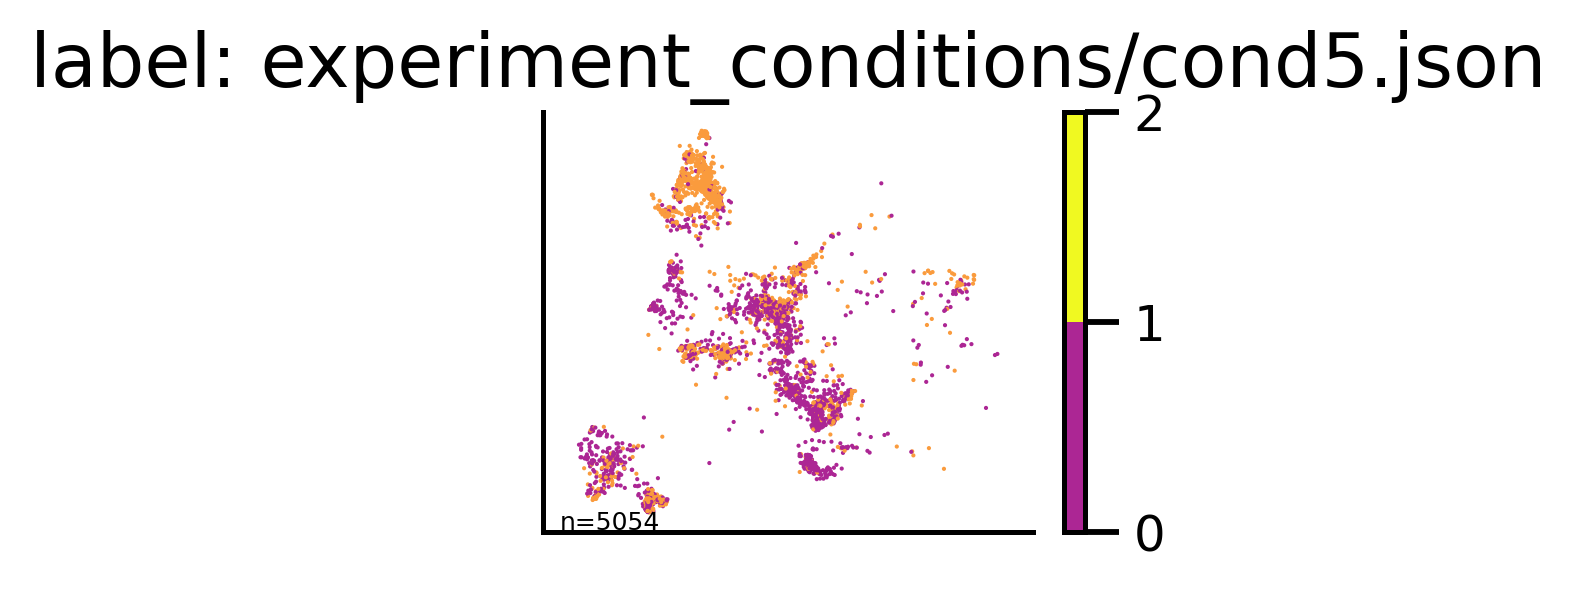

In [275]:
h = principal_projection(embedding, projection_matrices, PRINCIPAL_DIMENTIONS)

for l in sorted(list(set(label.tolist())), key=lambda s: int(re.findall(string=s, pattern='\d+')[0])):
    idx = (label == l)
    z = reducer.transform(h[idx, :])
    with plt.style.context(spstyle.get_style('nature-reviews')):
        fig = plt.figure(figsize=(3, 2))
        ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
        s = ax.scatter(z[:, 0], z[:, 1], c=(np.ones_like(perplexity) - 0.5 * human_label)[idx], s=1, alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity, 0.01), vmax=np.quantile(perplexity, 0.99))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal', 'datalim')
        plt.title(f'label: {l}')
        ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 6})
        fig.colorbar(s, ax=ax, boundaries=np.arange(np.floor(np.min(perplexity)), np.ceil(np.max(perplexity)) + 1))
        # plt.savefig('figures/perplexity_umap_'+l+'.png')

In [276]:
h = principal_projection(embedding_spot, projection_matrices, ['Kinetic Rate', 'FRET State Number', 'FRET Value', 'Noise', 'Photobleaching Steps'])
perplexity_spot = get_perplexity(h, label_spot, branching_factor=50)

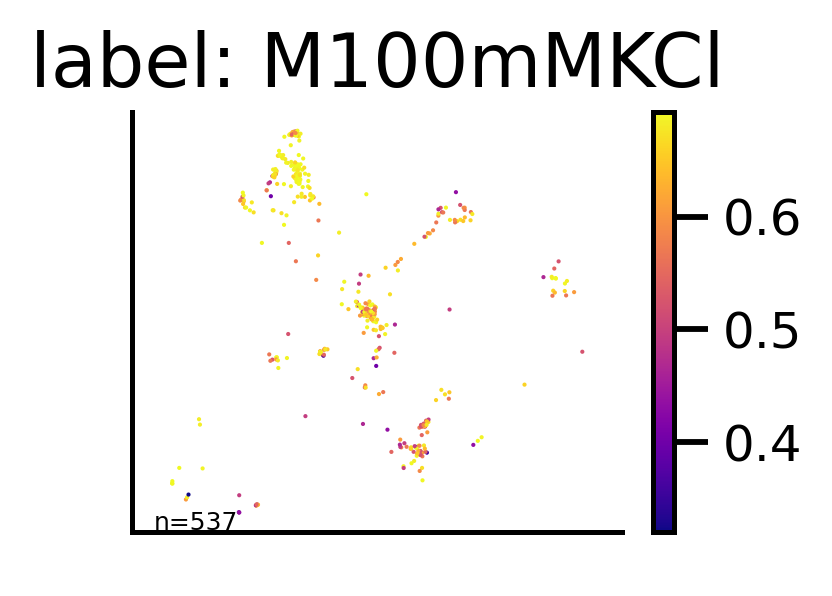

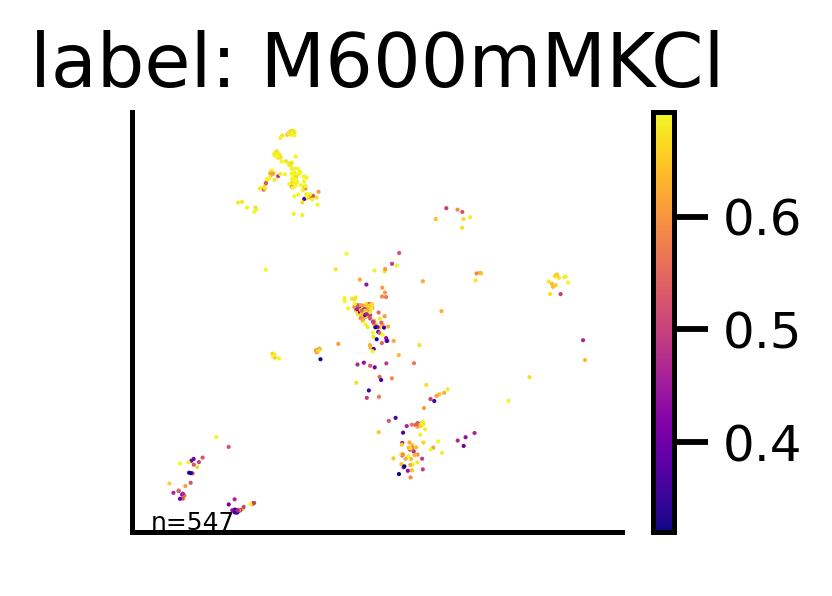

In [277]:
n = len(set(label_spot.tolist()))
cutoff = np.quantile(perplexity_spot, 1.0)
for l in sorted(list(set(label_spot.tolist())), key=lambda s: int(re.findall(string=s, pattern='\d+')[0])):
    idx = (label_spot == l) & (perplexity_spot <= cutoff)
    z = reducer.transform(h[idx, :])
    with plt.style.context(spstyle.get_style('nature-reviews')):
        fig = plt.figure(figsize=(3, 2))
        ax = fig.add_axes([0.2, 0.17, 0.68, 0.7])
        s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=1, alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal', 'datalim')
        plt.title(f'label: {l}')
        ax.text(x=s.axes.get_xlim()[0]+ 0.1, y=s.axes.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 6})
        fig.colorbar(s, ax=ax)